# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [185]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

The following code block contains an 8x8 matrix that will be used as a maze object:

In [186]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [187]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [188]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


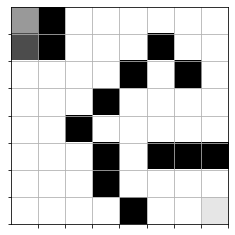

In [189]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [190]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [191]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [192]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [193]:
def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon 

    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    
    for epoch in range(n_epoch):
        Agent_cell = random.choice(qmaze.free_cells)
        qmaze.reset(Agent_cell)
        envstate = qmaze.observe()
        state = "not_gameOver"
        while state is not game_over:
            previous_envstate = envstate
            q = model.predict(previous_envstate)
            action = random.choice(actions_dict)
            envstate, reward, game_status = qmaze.act(action)
            actionInt = list(actions_dict.keys())[list(actions_dict.values()).index(action)]
            episode = [previous_envstate, actionInt, reward, envstate, game_status]
            experience.remember(episode)
            inputs,targets = experience.get_data()
            model.fit(inputs, targets)
            if win_rate > 0.9 and complete_check(model, qmaze):
                epoch = i
                print(i)
    # pseudocode:
    # For each epoch:
    #    Agent_cell = randomly select a free cell
    #    Reset the maze with agent set to above position
    #    Hint: Review the reset method in the TreasureMaze.py class.
    #    envstate = Environment.current_state
    #    Hint: Review the observe method in the TreasureMaze.py class.
    #    While state is not game over:
    #        previous_envstate = envstate
    #        Action = randomly choose action (left, right, up, down) either by exploration or by exploitation
    #        envstate, reward, game_status = qmaze.act(action)
    #    Hint: Review the act method in the TreasureMaze.py class.
    #        episode = [previous_envstate, action, reward, envstate, game_status]
    #        Store episode in Experience replay object
    #    Hint: Review the remember method in the GameExperience.py class.
    #        Train neural network model and evaluate loss
    #    Hint: Call GameExperience.get_data to retrieve training data (input and target) and pass to model.fit method 
    #          to train the model. You can call model.evaluate to determine loss.
    #    If the win rate is above the threshold and your model passes the completion check, that would be your epoch.


    #Print the epoch, loss, episodes, win count, and win rate for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # We simply check if training has exhausted all free cells and if in all
        # cases the agent won.
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break
    
    
    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

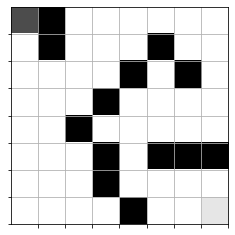

In [194]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [ ]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

Epoch 1/1
1/1 [==============================] - 1s 572ms/step - loss: 0.0392
Epoch 1/1
2/2 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 1/1
3/3 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 1/1
4/4 [==============================] - 0s 734us/step - loss: 0.0018
Epoch 1/1
5/5 [==============================] - 0s 623us/step - loss: 0.0048
Epoch 1/1
6/6 [==============================] - 0s 505us/step - loss: 0.0116
Epoch 1/1
7/7 [==============================] - 0s 115us/step - loss: 0.0106
Epoch 1/1
8/8 [==============================] - 0s 501us/step - loss: 0.0107
Epoch 1/1
9/9 [==============================] - 0s 133us/step - loss: 0.0072
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 0.0060
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 0.0065
Epoch 1/1
10/10 [==============================] - 0s 258us/step - loss: 0.0049
Epoch 1/1
10/10 [==============================] - 0s 299us/step

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.9477e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.2669e-06
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.1056e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 3.9615e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.8944e-06
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 6.2935e-06
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 4.9401e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.1441e-06
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 4.7909e-06
Epoch 1/1
10/10 [==============================] - 0s 292us/step - loss: 4.5556e-06
Epoch 1/1
10/10 [==============================] - 0s 612us/step - loss: 1.9078e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 3.7335e

Epoch 1/1
10/10 [==============================] - 0s 263us/step - loss: 3.4441e-08
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.1601e-08
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 5.0390e-09
Epoch 1/1
10/10 [==============================] - 0s 230us/step - loss: 1.5296e-09
Epoch 1/1
10/10 [==============================] - 0s 195us/step - loss: 2.3254e-09
Epoch 1/1
10/10 [==============================] - 0s 261us/step - loss: 6.3049e-09
Epoch 1/1
10/10 [==============================] - 0s 190us/step - loss: 2.1734e-09
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.6631e-08
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 5.7885e-10
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.4127e-09
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.9831e-09
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 9.9

Epoch 1/1
10/10 [==============================] - 0s 255us/step - loss: 4.2329e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.7578e-11
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 3.1676e-11
Epoch 1/1
10/10 [==============================] - 0s 226us/step - loss: 2.5496e-11
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 2.8945e-11
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.1855e-11
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 9.7776e-12
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.3257e-11
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 3.2024e-11
Epoch 1/1
10/10 [==============================] - 0s 342us/step - loss: 9.3100e-11
Epoch 1/1
10/10 [==============================] - 0s 288us/step - loss: 1.8435e-11
Epoch 1/1
10/10 [==============================] - 0s 260us/step - loss: 1.571

Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 5.6488e-11
Epoch 1/1
10/10 [==============================] - 0s 116us/step - loss: 2.3205e-11
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 4.4140e-11
Epoch 1/1
10/10 [==============================] - 0s 224us/step - loss: 3.8200e-11
Epoch 1/1
10/10 [==============================] - 0s 224us/step - loss: 5.8559e-11
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 4.2699e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.3348e-11
Epoch 1/1
10/10 [==============================] - 0s 332us/step - loss: 4.1172e-11
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 4.0125e-11
Epoch 1/1
10/10 [==============================] - 0s 231us/step - loss: 8.7902e-11
Epoch 1/1
10/10 [==============================] - 0s 139us/step - loss: 5.3768e-11
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 3.2

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.6911e-11
Epoch 1/1
10/10 [==============================] - 0s 195us/step - loss: 2.6479e-11
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.3365e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.8968e-11
Epoch 1/1
10/10 [==============================] - 0s 311us/step - loss: 6.1015e-12
Epoch 1/1
10/10 [==============================] - 0s 220us/step - loss: 9.0718e-11
Epoch 1/1
10/10 [==============================] - 0s 261us/step - loss: 6.6224e-11
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 2.0027e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.7899e-11
Epoch 1/1
10/10 [==============================] - 0s 333us/step - loss: 4.3101e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.3523e-12
Epoch 1/1
10/10 [==============================] - 0s 251us/step - loss: 5.014

Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.5954e-12
Epoch 1/1
10/10 [==============================] - 0s 273us/step - loss: 1.1425e-12
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 8.9581e-13
Epoch 1/1
10/10 [==============================] - 0s 219us/step - loss: 1.6272e-12
Epoch 1/1
10/10 [==============================] - 0s 290us/step - loss: 1.3734e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.8281e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.3727e-12
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.3307e-12
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 1.7442e-12
Epoch 1/1
10/10 [==============================] - 0s 251us/step - loss: 1.6522e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.9985e-13
Epoch 1/1
10/10 [==============================] - 0s 358us/step - loss: 8.4

Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 5.4546e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.5233e-12
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 5.8833e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 8.0891e-12
Epoch 1/1
10/10 [==============================] - 0s 336us/step - loss: 1.1138e-12
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.2771e-11
Epoch 1/1
10/10 [==============================] - 0s 246us/step - loss: 1.6645e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.9646e-11
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.3883e-11
Epoch 1/1
10/10 [==============================] - 0s 72us/step - loss: 4.1063e-11
Epoch 1/1
10/10 [==============================] - 0s 230us/step - loss: 1.0996e-11
Epoch 1/1
10/10 [==============================] - 0s 71us/step - loss: 1.886

Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 9.3629e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.3817e-09
Epoch 1/1
10/10 [==============================] - 0s 210us/step - loss: 1.0725e-09
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 4.8041e-09
Epoch 1/1
10/10 [==============================] - 0s 165us/step - loss: 1.5495e-09
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.7125e-09
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 3.3619e-09
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.3831e-10
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 3.8337e-09
Epoch 1/1
10/10 [==============================] - 0s 283us/step - loss: 8.4087e-10
Epoch 1/1
10/10 [==============================] - 0s 278us/step - loss: 5.3347e-09
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.6

Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.9700e-09
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.1874e-09
Epoch 1/1
10/10 [==============================] - 0s 295us/step - loss: 2.0263e-09
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.4674e-09
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.7596e-09
Epoch 1/1
10/10 [==============================] - 0s 192us/step - loss: 1.5466e-09
Epoch 1/1
10/10 [==============================] - 0s 283us/step - loss: 2.4903e-10
Epoch 1/1
10/10 [==============================] - 0s 322us/step - loss: 2.3161e-09
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.0286e-10
Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 1.6739e-09
Epoch 1/1
10/10 [==============================] - 0s 338us/step - loss: 2.5114e-09
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 8.6

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.7001e-07
Epoch 1/1
10/10 [==============================] - 0s 122us/step - loss: 7.6762e-07
Epoch 1/1
10/10 [==============================] - 0s 232us/step - loss: 7.5209e-07
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.9360e-06
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.5587e-07
Epoch 1/1
10/10 [==============================] - 0s 224us/step - loss: 1.4600e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.6575e-06
Epoch 1/1
10/10 [==============================] - 0s 228us/step - loss: 6.2190e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.4487e-06
Epoch 1/1
10/10 [==============================] - 0s 322us/step - loss: 1.3726e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.6270e-06
Epoch 1/1
10/10 [==============================] - 0s 180us/step - loss: 1.587

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.6772e-05
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.3184e-04
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.7261e-05
Epoch 1/1
10/10 [==============================] - 0s 264us/step - loss: 1.3719e-04
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 7.4569e-05
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.5439e-04
Epoch 1/1
10/10 [==============================] - 0s 194us/step - loss: 1.0532e-04
Epoch 1/1
10/10 [==============================] - 0s 650us/step - loss: 1.8228e-04
Epoch 1/1
10/10 [==============================] - 0s 225us/step - loss: 2.5844e-04
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 3.9201e-04
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 5.0262e-04
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 3.3

Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 2.0340e-04
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 1.3780e-04
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.0552e-05
Epoch 1/1
10/10 [==============================] - 0s 104us/step - loss: 7.0444e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.2461e-04
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 9.5460e-05
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 3.1134e-04
Epoch 1/1
10/10 [==============================] - 0s 474us/step - loss: 4.7537e-04
Epoch 1/1
10/10 [==============================] - 0s 335us/step - loss: 6.3448e-04
Epoch 1/1
10/10 [==============================] - 0s 627us/step - loss: 2.0808e-04
Epoch 1/1
10/10 [==============================] - 0s 353us/step - loss: 7.5087e-04
Epoch 1/1
10/10 [==============================] - 0s 239us/step - loss: 0.0

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.4111e-05
Epoch 1/1
10/10 [==============================] - 0s 278us/step - loss: 1.0952e-04
Epoch 1/1
10/10 [==============================] - 0s 263us/step - loss: 9.5852e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.2784e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.6179e-05
Epoch 1/1
10/10 [==============================] - 0s 317us/step - loss: 1.0150e-05
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 1.4093e-04
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.6151e-05
Epoch 1/1
10/10 [==============================] - 0s 396us/step - loss: 4.7583e-05
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 8.3766e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.6957e-05
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 4.9

Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.5071e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.9693e-05
Epoch 1/1
10/10 [==============================] - 0s 357us/step - loss: 1.6942e-05
Epoch 1/1
10/10 [==============================] - 0s 277us/step - loss: 2.1403e-05
Epoch 1/1
10/10 [==============================] - 0s 216us/step - loss: 2.7451e-05
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 1.8752e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 9.6357e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 9.3593e-06
Epoch 1/1
10/10 [==============================] - 0s 275us/step - loss: 6.0923e-05
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 8.4671e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.3904e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.6

Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 4.3072e-07
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 5.0163e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.0141e-06
Epoch 1/1
10/10 [==============================] - 0s 218us/step - loss: 8.5886e-07
Epoch 1/1
10/10 [==============================] - 0s 213us/step - loss: 5.0445e-08
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.1486e-07
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 4.9752e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 5.1365e-07
Epoch 1/1
10/10 [==============================] - 0s 361us/step - loss: 4.9455e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 5.3861e-07
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.8695e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.4

Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.1909e-07
Epoch 1/1
10/10 [==============================] - 0s 191us/step - loss: 1.9741e-07
Epoch 1/1
10/10 [==============================] - 0s 359us/step - loss: 2.3537e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.1323e-07
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 6.1510e-07
Epoch 1/1
10/10 [==============================] - 0s 188us/step - loss: 7.3015e-08
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.3383e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.1986e-07
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 5.6138e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.5037e-08
Epoch 1/1
10/10 [==============================] - 0s 385us/step - loss: 6.6416e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.2

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.9671e-09
Epoch 1/1
10/10 [==============================] - 0s 500us/step - loss: 3.7538e-09
Epoch 1/1
10/10 [==============================] - 0s 284us/step - loss: 7.2596e-09
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 1.0727e-08
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 4.6795e-09
Epoch 1/1
10/10 [==============================] - 0s 309us/step - loss: 5.5911e-09
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.0354e-08
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 5.4765e-09
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.6431e-09
Epoch 1/1
10/10 [==============================] - 0s 226us/step - loss: 6.7482e-09
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.0310e-09
Epoch 1/1
10/10 [==============================] - 0s 213us/step - loss: 1.2

Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.4072e-11
Epoch 1/1
10/10 [==============================] - 0s 228us/step - loss: 5.8289e-11
Epoch 1/1
10/10 [==============================] - 0s 355us/step - loss: 7.7656e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.8696e-11
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 5.7141e-11
Epoch 1/1
10/10 [==============================] - 0s 282us/step - loss: 3.7325e-11
Epoch 1/1
10/10 [==============================] - 0s 331us/step - loss: 7.5709e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.3427e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.3497e-10
Epoch 1/1
10/10 [==============================] - 0s 157us/step - loss: 8.5419e-12
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 1.0843e-10
Epoch 1/1
10/10 [==============================] - 0s 347us/step - loss: 1.6

Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 3.1467e-11
Epoch 1/1
10/10 [==============================] - 0s 621us/step - loss: 4.5317e-11
Epoch 1/1
10/10 [==============================] - 0s 295us/step - loss: 6.4293e-11
Epoch 1/1
10/10 [==============================] - 0s 344us/step - loss: 2.2478e-11
Epoch 1/1
10/10 [==============================] - 0s 308us/step - loss: 4.7198e-11
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 6.1956e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.8983e-11
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.2461e-10
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 3.8658e-11
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.7503e-11
Epoch 1/1
10/10 [==============================] - 0s 88us/step - loss: 3.1701e-11
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 8.1179e-11

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.5147e-12
Epoch 1/1
10/10 [==============================] - 0s 388us/step - loss: 1.0500e-11
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 7.1033e-12
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.4775e-12
Epoch 1/1
10/10 [==============================] - 0s 255us/step - loss: 1.3686e-12
Epoch 1/1
10/10 [==============================] - 0s 359us/step - loss: 3.7935e-12
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 8.4317e-12
Epoch 1/1
10/10 [==============================] - 0s 130us/step - loss: 3.6035e-11
Epoch 1/1
10/10 [==============================] - 0s 277us/step - loss: 5.5544e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.0110e-11
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.0123e-11
Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 1.03

Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 2.2575e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.5070e-12
Epoch 1/1
10/10 [==============================] - 0s 469us/step - loss: 9.2575e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.7801e-12
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 1.5411e-12
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.6556e-12
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.9026e-12
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 4.8696e-12
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.1484e-12
Epoch 1/1
10/10 [==============================] - 0s 309us/step - loss: 2.7678e-13
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 5.2227e-12
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.0

Epoch 1/1
10/10 [==============================] - 0s 219us/step - loss: 1.5795e-11
Epoch 1/1
10/10 [==============================] - 0s 349us/step - loss: 5.5335e-12
Epoch 1/1
10/10 [==============================] - 0s 391us/step - loss: 1.6949e-11
Epoch 1/1
10/10 [==============================] - 0s 341us/step - loss: 4.7042e-12
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 1.6434e-12
Epoch 1/1
10/10 [==============================] - 0s 275us/step - loss: 6.2045e-12
Epoch 1/1
10/10 [==============================] - 0s 189us/step - loss: 1.2398e-11
Epoch 1/1
10/10 [==============================] - 0s 459us/step - loss: 9.9584e-12
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.9180e-12
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.9037e-12
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 9.4429e-12
Epoch 1/1
10/10 [==============================] - 0s 254us/step - loss: 1.1

Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.5274e-11
Epoch 1/1
10/10 [==============================] - 0s 211us/step - loss: 1.2922e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.5705e-11
Epoch 1/1
10/10 [==============================] - 0s 254us/step - loss: 9.7381e-12
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.2506e-11
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.7470e-12
Epoch 1/1
10/10 [==============================] - 0s 240us/step - loss: 1.4497e-11
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 8.8527e-12
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 2.2323e-12
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.1927e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.2234e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.1

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.7571e-08
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.1811e-08
Epoch 1/1
10/10 [==============================] - 0s 328us/step - loss: 3.5140e-09
Epoch 1/1
10/10 [==============================] - 0s 333us/step - loss: 4.2790e-09
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.4048e-08
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.4243e-09
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.0192e-09
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 7.2385e-09
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.5608e-08
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.1610e-08
Epoch 1/1
10/10 [==============================] - 0s 104us/step - loss: 3.9859e-09
Epoch 1/1
10/10 [==============================] - 0s 281us/step - loss: 9.298

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 5.1209e-08
Epoch 1/1
10/10 [==============================] - 0s 237us/step - loss: 2.2370e-08
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 9.6369e-08
Epoch 1/1
10/10 [==============================] - 0s 186us/step - loss: 6.9429e-08
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.9803e-08
Epoch 1/1
10/10 [==============================] - 0s 327us/step - loss: 7.3691e-08
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.8221e-08
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.0014e-08
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 4.0773e-08
Epoch 1/1
10/10 [==============================] - 0s 310us/step - loss: 1.6881e-07
Epoch 1/1
10/10 [==============================] - 0s 152us/step - loss: 1.5104e-07
Epoch 1/1
10/10 [==============================] - 0s 194us/step - loss: 5.6

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.6188e-08
Epoch 1/1
10/10 [==============================] - 0s 264us/step - loss: 9.3301e-08
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 1.2970e-07
Epoch 1/1
10/10 [==============================] - 0s 328us/step - loss: 6.1141e-08
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.1873e-07
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.2143e-08
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.4942e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.2361e-08
Epoch 1/1
10/10 [==============================] - 0s 359us/step - loss: 2.2039e-07
Epoch 1/1
10/10 [==============================] - 0s 291us/step - loss: 4.6764e-08
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.3241e-08
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.3

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.3909e-04
Epoch 1/1
10/10 [==============================] - 0s 268us/step - loss: 3.9426e-04
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.1045e-04
Epoch 1/1
10/10 [==============================] - 0s 192us/step - loss: 1.7516e-04
Epoch 1/1
10/10 [==============================] - 0s 174us/step - loss: 4.6104e-04
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.9710e-04
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 1.6350e-04
Epoch 1/1
10/10 [==============================] - 0s 216us/step - loss: 2.6182e-04
Epoch 1/1
10/10 [==============================] - 0s 265us/step - loss: 3.3737e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.0210e-05
Epoch 1/1
10/10 [==============================] - 0s 272us/step - loss: 2.1189e-04
Epoch 1/1
10/10 [==============================] - 0s 337us/step - loss: 2.4

Epoch 1/1
10/10 [==============================] - 0s 295us/step - loss: 7.7051e-05
Epoch 1/1
10/10 [==============================] - 0s 153us/step - loss: 3.1869e-06
Epoch 1/1
10/10 [==============================] - 0s 466us/step - loss: 3.2390e-05
Epoch 1/1
10/10 [==============================] - 0s 170us/step - loss: 7.1403e-05
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 5.5839e-05
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 3.1296e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.0984e-05
Epoch 1/1
10/10 [==============================] - 0s 657us/step - loss: 3.1909e-05
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 3.3321e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.1413e-05
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 3.1898e-05
Epoch 1/1
10/10 [==============================] - 0s 375us/step - loss: 9.9

Epoch 1/1
10/10 [==============================] - 0s 135us/step - loss: 4.0799e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 9.7595e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 6.1752e-06
Epoch 1/1
10/10 [==============================] - 0s 187us/step - loss: 2.5902e-06
Epoch 1/1
10/10 [==============================] - 0s 231us/step - loss: 6.1192e-06
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 6.9470e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.6449e-06
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 4.7098e-06
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 3.9663e-06
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.4928e-06
Epoch 1/1
10/10 [==============================] - 0s 276us/step - loss: 4.5476e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.2

Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.4630e-04
Epoch 1/1
10/10 [==============================] - 0s 255us/step - loss: 6.8647e-05
Epoch 1/1
10/10 [==============================] - 0s 368us/step - loss: 4.7818e-05
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 7.4749e-05
Epoch 1/1
10/10 [==============================] - 0s 358us/step - loss: 1.3149e-04
Epoch 1/1
10/10 [==============================] - 0s 271us/step - loss: 1.3010e-04
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 2.1449e-04
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.0865e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.0718e-05
Epoch 1/1
10/10 [==============================] - 0s 311us/step - loss: 1.6234e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.9194e-04
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 1.6

Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 3.3068e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.7140e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.7932e-07
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.4745e-06
Epoch 1/1
10/10 [==============================] - 0s 193us/step - loss: 1.1727e-06
Epoch 1/1
10/10 [==============================] - 0s 183us/step - loss: 2.0068e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.9681e-06
Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 2.3825e-06
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.5740e-07
Epoch 1/1
10/10 [==============================] - 0s 358us/step - loss: 9.2062e-07
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.4325e-06
Epoch 1/1
10/10 [==============================] - 0s 226us/step - loss: 8.3

Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.7521e-09
Epoch 1/1
10/10 [==============================] - 0s 128us/step - loss: 2.6743e-09
Epoch 1/1
10/10 [==============================] - 0s 272us/step - loss: 1.7269e-09
Epoch 1/1
10/10 [==============================] - 0s 818us/step - loss: 3.7121e-09
Epoch 1/1
10/10 [==============================] - 0s 246us/step - loss: 1.8222e-08
Epoch 1/1
10/10 [==============================] - 0s 266us/step - loss: 6.0659e-09
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 2.2737e-09
Epoch 1/1
10/10 [==============================] - 0s 153us/step - loss: 5.6641e-09
Epoch 1/1
10/10 [==============================] - 0s 367us/step - loss: 9.4218e-09
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.1852e-09
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.2474e-09
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 9.5

Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 2.8175e-11
Epoch 1/1
10/10 [==============================] - 0s 139us/step - loss: 6.2118e-11
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 1.1862e-10
Epoch 1/1
10/10 [==============================] - 0s 528us/step - loss: 1.1762e-10
Epoch 1/1
10/10 [==============================] - 0s 252us/step - loss: 1.1340e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.8735e-11
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.5768e-11
Epoch 1/1
10/10 [==============================] - 0s 173us/step - loss: 6.2630e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.0226e-10
Epoch 1/1
10/10 [==============================] - 0s 224us/step - loss: 5.3468e-11
Epoch 1/1
10/10 [==============================] - 0s 165us/step - loss: 1.9175e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.8

Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 2.3565e-12
Epoch 1/1
10/10 [==============================] - 0s 210us/step - loss: 4.8933e-13
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 7.2106e-13
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.4237e-12
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 8.5924e-13
Epoch 1/1
10/10 [==============================] - 0s 190us/step - loss: 2.3936e-13
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.0279e-13
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.1887e-13
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 7.8479e-13
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.3658e-13
Epoch 1/1
10/10 [==============================] - 0s 216us/step - loss: 3.3534e-13
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.4

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.9362e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.0586e-13
Epoch 1/1
10/10 [==============================] - 0s 335us/step - loss: 6.2489e-13
Epoch 1/1
10/10 [==============================] - 0s 284us/step - loss: 7.3921e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.6496e-13
Epoch 1/1
10/10 [==============================] - 0s 153us/step - loss: 7.0162e-13
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 9.6388e-13
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 3.7074e-13
Epoch 1/1
10/10 [==============================] - 0s 404us/step - loss: 8.1224e-13
Epoch 1/1
10/10 [==============================] - 0s 123us/step - loss: 1.4869e-12
Epoch 1/1
10/10 [==============================] - 0s 243us/step - loss: 2.1260e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 8.3

Epoch 1/1
10/10 [==============================] - 0s 381us/step - loss: 2.9615e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.3356e-14
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 3.7703e-14
Epoch 1/1
10/10 [==============================] - 0s 312us/step - loss: 6.0002e-14
Epoch 1/1
10/10 [==============================] - 0s 348us/step - loss: 5.1020e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.5432e-14
Epoch 1/1
10/10 [==============================] - 0s 340us/step - loss: 6.9889e-15
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.1820e-14
Epoch 1/1
10/10 [==============================] - 0s 214us/step - loss: 4.8134e-14
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 5.0016e-14
Epoch 1/1
10/10 [==============================] - 0s 431us/step - loss: 1.4644e-14
Epoch 1/1
10/10 [==============================] - 0s 385us/step - loss: 5.3

Epoch 1/1
10/10 [==============================] - 0s 169us/step - loss: 1.1104e-12
Epoch 1/1
10/10 [==============================] - 0s 227us/step - loss: 3.7002e-13
Epoch 1/1
10/10 [==============================] - 0s 325us/step - loss: 2.2475e-13
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 4.7375e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.3125e-13
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 6.3838e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 6.6330e-13
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 3.4998e-13
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 1.4108e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.0513e-13
Epoch 1/1
10/10 [==============================] - 0s 160us/step - loss: 1.5713e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.358

Epoch 1/1
10/10 [==============================] - 0s 255us/step - loss: 2.4180e-12
Epoch 1/1
10/10 [==============================] - 0s 232us/step - loss: 7.1356e-12
Epoch 1/1
10/10 [==============================] - 0s 191us/step - loss: 6.9326e-12
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.7782e-12
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 1.1797e-12
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.7886e-12
Epoch 1/1
10/10 [==============================] - 0s 161us/step - loss: 1.1579e-11
Epoch 1/1
10/10 [==============================] - 0s 166us/step - loss: 1.4507e-12
Epoch 1/1
10/10 [==============================] - 0s 226us/step - loss: 2.5835e-12
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 1.4372e-11
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 9.9624e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.8

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.2897e-11
Epoch 1/1
10/10 [==============================] - 0s 163us/step - loss: 1.8546e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.2190e-12
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 8.3411e-12
Epoch 1/1
10/10 [==============================] - 0s 262us/step - loss: 8.0000e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.0258e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 8.3131e-12
Epoch 1/1
10/10 [==============================] - 0s 281us/step - loss: 1.2935e-11
Epoch 1/1
10/10 [==============================] - 0s 246us/step - loss: 1.5060e-11
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.2281e-11
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 7.1551e-12
Epoch 1/1
10/10 [==============================] - 0s 249us/step - loss: 8.6

Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.7245e-11
Epoch 1/1
10/10 [==============================] - 0s 210us/step - loss: 9.1940e-11
Epoch 1/1
10/10 [==============================] - 0s 176us/step - loss: 2.7394e-10
Epoch 1/1
10/10 [==============================] - 0s 274us/step - loss: 4.5085e-11
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 5.4648e-11
Epoch 1/1
10/10 [==============================] - 0s 215us/step - loss: 2.1394e-10
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 9.5405e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.0935e-11
Epoch 1/1
10/10 [==============================] - 0s 179us/step - loss: 5.2361e-11
Epoch 1/1
10/10 [==============================] - 0s 219us/step - loss: 8.4955e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.3237e-11
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.3

Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 4.8531e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.2842e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.2621e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.4290e-11
Epoch 1/1
10/10 [==============================] - 0s 269us/step - loss: 1.9416e-11
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 4.9703e-11
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 6.7781e-12
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.8612e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.2802e-11
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 1.0137e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.5729e-11
Epoch 1/1
10/10 [==============================] - 0s 236us/step - loss: 6.750

Epoch 1/1
10/10 [==============================] - 0s 274us/step - loss: 9.4827e-11
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.7154e-11
Epoch 1/1
10/10 [==============================] - 0s 232us/step - loss: 2.8852e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.2797e-12
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 7.5842e-11
Epoch 1/1
10/10 [==============================] - 0s 227us/step - loss: 7.4627e-11
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 5.7112e-11
Epoch 1/1
10/10 [==============================] - 0s 313us/step - loss: 8.7004e-11
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 5.2445e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 6.8762e-11
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 6.6349e-11
Epoch 1/1
10/10 [==============================] - 0s 394us/step - loss: 9.2

Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 4.7445e-12
Epoch 1/1
10/10 [==============================] - 0s 191us/step - loss: 4.0782e-11
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.7395e-11
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.7518e-11
Epoch 1/1
10/10 [==============================] - 0s 336us/step - loss: 1.7540e-11
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.5308e-11
Epoch 1/1
10/10 [==============================] - 0s 263us/step - loss: 1.7172e-11
Epoch 1/1
10/10 [==============================] - 0s 260us/step - loss: 2.9343e-12
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 8.8084e-12
Epoch 1/1
10/10 [==============================] - 0s 142us/step - loss: 1.4225e-12
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.0341e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.3

Epoch 1/1
10/10 [==============================] - 0s 389us/step - loss: 1.0642e-10
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.0973e-10
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.6349e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 6.0794e-11
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.7326e-10
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.2651e-10
Epoch 1/1
10/10 [==============================] - 0s 247us/step - loss: 2.1118e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.3238e-10
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.6781e-10
Epoch 1/1
10/10 [==============================] - 0s 221us/step - loss: 2.4359e-10
Epoch 1/1
10/10 [==============================] - 0s 277us/step - loss: 2.8630e-10
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.3

Epoch 1/1
10/10 [==============================] - 0s 355us/step - loss: 1.7041e-09
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.7853e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.7516e-10
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.1947e-09
Epoch 1/1
10/10 [==============================] - 0s 240us/step - loss: 4.4920e-10
Epoch 1/1
10/10 [==============================] - 0s 161us/step - loss: 9.5716e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.2645e-09
Epoch 1/1
10/10 [==============================] - 0s 175us/step - loss: 3.9878e-10
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.0872e-09
Epoch 1/1
10/10 [==============================] - 0s 328us/step - loss: 3.6314e-09
Epoch 1/1
10/10 [==============================] - 0s 181us/step - loss: 2.4478e-09
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.0

Epoch 1/1
10/10 [==============================] - 0s 256us/step - loss: 4.7265e-08
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.6855e-10
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.0338e-08
Epoch 1/1
10/10 [==============================] - 0s 212us/step - loss: 1.0797e-08
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 4.8668e-09
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.4434e-08
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 6.2491e-09
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 6.5621e-09
Epoch 1/1
10/10 [==============================] - 0s 225us/step - loss: 1.3126e-08
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 9.2757e-09
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 4.1369e-09
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 1.5

Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.5423e-06
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.8965e-06
Epoch 1/1
10/10 [==============================] - 0s 233us/step - loss: 5.8038e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.9290e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 8.4234e-06
Epoch 1/1
10/10 [==============================] - 0s 257us/step - loss: 7.0154e-06
Epoch 1/1
10/10 [==============================] - 0s 227us/step - loss: 2.8238e-06
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 8.6262e-06
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 2.6616e-06
Epoch 1/1
10/10 [==============================] - 0s 327us/step - loss: 6.8799e-06
Epoch 1/1
10/10 [==============================] - 0s 268us/step - loss: 2.0413e-06
Epoch 1/1
10/10 [==============================] - 0s 237us/step - loss: 2.264

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.0753e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.0247e-05
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 3.3431e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.4959e-04
Epoch 1/1
10/10 [==============================] - 0s 272us/step - loss: 9.3379e-05
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 3.5008e-04
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 2.1515e-04
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 4.9968e-05
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.5114e-04
Epoch 1/1
10/10 [==============================] - 0s 266us/step - loss: 0.0012
Epoch 1/1
10/10 [==============================] - 0s 220us/step - loss: 1.6137e-04
Epoch 1/1
10/10 [==============================] - 0s 111us/step - loss: 7.7283e-0

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.8805e-06
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 2.5219e-06
Epoch 1/1
10/10 [==============================] - 0s 274us/step - loss: 4.6804e-07
Epoch 1/1
10/10 [==============================] - 0s 263us/step - loss: 4.1954e-07
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.3069e-06
Epoch 1/1
10/10 [==============================] - 0s 132us/step - loss: 2.0403e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 9.2108e-07
Epoch 1/1
10/10 [==============================] - 0s 163us/step - loss: 6.4039e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.2769e-07
Epoch 1/1
10/10 [==============================] - 0s 262us/step - loss: 1.3343e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.6420e-07
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 5.5

Epoch 1/1
10/10 [==============================] - 0s 328us/step - loss: 8.2321e-10
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 8.9899e-10
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 5.4568e-10
Epoch 1/1
10/10 [==============================] - 0s 330us/step - loss: 1.9573e-10
Epoch 1/1
10/10 [==============================] - 0s 138us/step - loss: 9.6211e-10
Epoch 1/1
10/10 [==============================] - 0s 265us/step - loss: 8.1567e-10
Epoch 1/1
10/10 [==============================] - 0s 135us/step - loss: 7.9389e-10
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 3.6298e-10
Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 2.6374e-10
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 3.7081e-10
Epoch 1/1
10/10 [==============================] - 0s 216us/step - loss: 4.7974e-10
Epoch 1/1
10/10 [==============================] - 0s 311us/step - loss: 1.64

Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 6.2866e-13
Epoch 1/1
10/10 [==============================] - 0s 277us/step - loss: 1.9047e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.7873e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.4668e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.9539e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.2341e-13
Epoch 1/1
10/10 [==============================] - 0s 232us/step - loss: 1.6142e-13
Epoch 1/1
10/10 [==============================] - 0s 286us/step - loss: 6.5059e-14
Epoch 1/1
10/10 [==============================] - 0s 375us/step - loss: 3.3856e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.5326e-14
Epoch 1/1
10/10 [==============================] - 0s 326us/step - loss: 1.4353e-13
Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 1.00

Epoch 1/1
10/10 [==============================] - 0s 392us/step - loss: 1.1235e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.8826e-15
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 1.8707e-14
Epoch 1/1
10/10 [==============================] - 0s 225us/step - loss: 4.1367e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.3182e-14
Epoch 1/1
10/10 [==============================] - 0s 314us/step - loss: 1.7242e-14
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.1905e-14
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.1722e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.7039e-14
Epoch 1/1
10/10 [==============================] - 0s 266us/step - loss: 2.7989e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.3442e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.5

Epoch 1/1
10/10 [==============================] - 0s 151us/step - loss: 3.0764e-14
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.0265e-14
Epoch 1/1
10/10 [==============================] - 0s 350us/step - loss: 1.5771e-14
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 5.5045e-14
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.0553e-14
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.2119e-14
Epoch 1/1
10/10 [==============================] - 0s 326us/step - loss: 5.3119e-14
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 5.0787e-14
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 6.8212e-14
Epoch 1/1
10/10 [==============================] - 0s 292us/step - loss: 8.4244e-14
Epoch 1/1
10/10 [==============================] - 0s 273us/step - loss: 5.1259e-14
Epoch 1/1
10/10 [==============================] - 0s 227us/step - loss: 1.6

Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.5676e-14
Epoch 1/1
10/10 [==============================] - 0s 268us/step - loss: 1.4366e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.1490e-15
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 7.9270e-15
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.1728e-15
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.7978e-15
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.1237e-15
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 9.6534e-15
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 6.3116e-15
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 2.8222e-14
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.4849e-14
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.6

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.8793e-13
Epoch 1/1
10/10 [==============================] - 0s 138us/step - loss: 6.9511e-14
Epoch 1/1
10/10 [==============================] - 0s 230us/step - loss: 1.3369e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.4743e-13
Epoch 1/1
10/10 [==============================] - 0s 106us/step - loss: 1.1496e-13
Epoch 1/1
10/10 [==============================] - 0s 233us/step - loss: 5.9464e-14
Epoch 1/1
10/10 [==============================] - 0s 348us/step - loss: 8.7330e-14
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 5.9042e-14
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 5.5556e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.8771e-14
Epoch 1/1
10/10 [==============================] - 0s 161us/step - loss: 6.9350e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 8.7

Epoch 1/1
10/10 [==============================] - 0s 396us/step - loss: 1.4133e-14
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.0281e-13
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.4184e-13
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 4.0901e-14
Epoch 1/1
10/10 [==============================] - 0s 217us/step - loss: 1.2226e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.8997e-13
Epoch 1/1
10/10 [==============================] - 0s 273us/step - loss: 1.1918e-13
Epoch 1/1
10/10 [==============================] - 0s 266us/step - loss: 5.7104e-14
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 8.7752e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.5132e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.1753e-13
Epoch 1/1
10/10 [==============================] - 0s 194us/step - loss: 1.605

Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 9.3875e-14
Epoch 1/1
10/10 [==============================] - 0s 159us/step - loss: 2.4331e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 8.0513e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 9.1349e-14
Epoch 1/1
10/10 [==============================] - 0s 210us/step - loss: 1.7741e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.8280e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.9729e-14
Epoch 1/1
10/10 [==============================] - 0s 224us/step - loss: 2.2782e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.9960e-15
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.4400e-14
Epoch 1/1
10/10 [==============================] - 0s 334us/step - loss: 5.7765e-14
Epoch 1/1
10/10 [==============================] - 0s 332us/step - loss: 3.0

Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 4.5675e-14
Epoch 1/1
10/10 [==============================] - 0s 230us/step - loss: 2.4042e-14
Epoch 1/1
10/10 [==============================] - 0s 315us/step - loss: 5.9741e-14
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 5.8009e-15
Epoch 1/1
10/10 [==============================] - 0s 295us/step - loss: 8.7313e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.6213e-13
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.9423e-14
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.1986e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.5015e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.5615e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.1388e-13
Epoch 1/1
10/10 [==============================] - 0s 214us/step - loss: 4.5

Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 9.5024e-14
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 6.1673e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.7911e-14
Epoch 1/1
10/10 [==============================] - 0s 539us/step - loss: 6.0085e-14
Epoch 1/1
10/10 [==============================] - 0s 162us/step - loss: 4.9349e-14
Epoch 1/1
10/10 [==============================] - 0s 145us/step - loss: 6.6047e-14
Epoch 1/1
10/10 [==============================] - 0s 176us/step - loss: 8.2323e-14
Epoch 1/1
10/10 [==============================] - 0s 261us/step - loss: 4.5930e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 9.4036e-15
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.0957e-14
Epoch 1/1
10/10 [==============================] - 0s 334us/step - loss: 8.9528e-14
Epoch 1/1
10/10 [==============================] - 0s 150us/step - loss: 8.1

Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.9335e-14
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 2.9188e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.5794e-14
Epoch 1/1
10/10 [==============================] - 0s 106us/step - loss: 7.7383e-15
Epoch 1/1
10/10 [==============================] - 0s 342us/step - loss: 7.7494e-15
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.2090e-14
Epoch 1/1
10/10 [==============================] - 0s 364us/step - loss: 2.4403e-14
Epoch 1/1
10/10 [==============================] - 0s 226us/step - loss: 2.1455e-14
Epoch 1/1
10/10 [==============================] - 0s 293us/step - loss: 2.7550e-14
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 3.7598e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.1863e-14
Epoch 1/1
10/10 [==============================] - 0s 218us/step - loss: 1.3

Epoch 1/1
10/10 [==============================] - 0s 411us/step - loss: 8.2823e-14
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 5.6716e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.6286e-14
Epoch 1/1
10/10 [==============================] - 0s 286us/step - loss: 2.6179e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.8458e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.3287e-13
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.5232e-14
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 8.5570e-14
Epoch 1/1
10/10 [==============================] - 0s 170us/step - loss: 7.3608e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 8.2490e-14
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 1.2854e-13
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 9.2

Epoch 1/1
10/10 [==============================] - 0s 257us/step - loss: 7.1232e-14
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 4.6241e-14
Epoch 1/1
10/10 [==============================] - 0s 232us/step - loss: 1.0338e-13
Epoch 1/1
10/10 [==============================] - 0s 284us/step - loss: 3.8991e-13
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 2.2123e-13
Epoch 1/1
10/10 [==============================] - 0s 167us/step - loss: 3.5016e-14
Epoch 1/1
10/10 [==============================] - 0s 308us/step - loss: 9.6501e-14
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 6.7313e-14
Epoch 1/1
10/10 [==============================] - 0s 324us/step - loss: 2.5252e-13
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 7.5595e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 6.8034e-14
Epoch 1/1
10/10 [==============================] - 0s 274us/step - loss: 1.0

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.4624e-13
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 8.1141e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.5564e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.7435e-13
Epoch 1/1
10/10 [==============================] - 0s 534us/step - loss: 7.1737e-13
Epoch 1/1
10/10 [==============================] - 0s 192us/step - loss: 1.3723e-12
Epoch 1/1
10/10 [==============================] - 0s 213us/step - loss: 1.0625e-12
Epoch 1/1
10/10 [==============================] - 0s 277us/step - loss: 5.0698e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.5142e-12
Epoch 1/1
10/10 [==============================] - 0s 315us/step - loss: 7.5426e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.4037e-13
Epoch 1/1
10/10 [==============================] - 0s 225us/step - loss: 2.1

Epoch 1/1
10/10 [==============================] - 0s 125us/step - loss: 8.5265e-15
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.3066e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.7725e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.1149e-15
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 5.3013e-15
Epoch 1/1
10/10 [==============================] - 0s 314us/step - loss: 4.8733e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.0184e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.5630e-15
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.1535e-14
Epoch 1/1
10/10 [==============================] - 0s 164us/step - loss: 9.9809e-15
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.7342e-14
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.8

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.4044e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.4904e-13
Epoch 1/1
10/10 [==============================] - 0s 312us/step - loss: 2.6079e-14
Epoch 1/1
10/10 [==============================] - 0s 230us/step - loss: 1.9602e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.7060e-13
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 4.4124e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.0075e-13
Epoch 1/1
10/10 [==============================] - 0s 253us/step - loss: 4.2984e-13
Epoch 1/1
10/10 [==============================] - 0s 233us/step - loss: 9.1152e-13
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 1.2784e-12
Epoch 1/1
10/10 [==============================] - 0s 321us/step - loss: 7.8355e-13
Epoch 1/1
10/10 [==============================] - 0s 314us/step - loss: 3.5

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.7976e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.9894e-12
Epoch 1/1
10/10 [==============================] - 0s 262us/step - loss: 2.0940e-12
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 3.4497e-12
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.0233e-12
Epoch 1/1
10/10 [==============================] - 0s 134us/step - loss: 7.9321e-12
Epoch 1/1
10/10 [==============================] - 0s 278us/step - loss: 3.3264e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.2505e-11
Epoch 1/1
10/10 [==============================] - 0s 248us/step - loss: 6.9118e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.0242e-12
Epoch 1/1
10/10 [==============================] - 0s 504us/step - loss: 7.4273e-12
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.8

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.2834e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.7200e-14
Epoch 1/1
10/10 [==============================] - 0s 342us/step - loss: 1.1060e-13
Epoch 1/1
10/10 [==============================] - 0s 228us/step - loss: 1.0243e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.6854e-14
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.2648e-13
Epoch 1/1
10/10 [==============================] - 0s 315us/step - loss: 5.7576e-14
Epoch 1/1
10/10 [==============================] - 0s 382us/step - loss: 6.9245e-14
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 9.6523e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.2771e-13
Epoch 1/1
10/10 [==============================] - 0s 410us/step - loss: 4.6386e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.6

Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 3.0822e-11
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.0647e-10
Epoch 1/1
10/10 [==============================] - 0s 392us/step - loss: 4.0815e-11
Epoch 1/1
10/10 [==============================] - 0s 191us/step - loss: 1.4223e-10
Epoch 1/1
10/10 [==============================] - 0s 338us/step - loss: 1.0124e-10
Epoch 1/1
10/10 [==============================] - 0s 393us/step - loss: 2.5826e-11
Epoch 1/1
10/10 [==============================] - 0s 251us/step - loss: 7.7830e-11
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.0246e-10
Epoch 1/1
10/10 [==============================] - 0s 227us/step - loss: 1.4505e-10
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.0790e-10
Epoch 1/1
10/10 [==============================] - 0s 195us/step - loss: 9.7432e-11
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 1.8

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.8138e-12
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 7.2331e-12
Epoch 1/1
10/10 [==============================] - 0s 252us/step - loss: 6.9930e-13
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 5.8991e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.6299e-12
Epoch 1/1
10/10 [==============================] - 0s 241us/step - loss: 8.9012e-13
Epoch 1/1
10/10 [==============================] - 0s 159us/step - loss: 4.5958e-12
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.1379e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.4981e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.0287e-13
Epoch 1/1
10/10 [==============================] - 0s 244us/step - loss: 1.8127e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.7

Epoch 1/1
10/10 [==============================] - 0s 227us/step - loss: 1.3782e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.3834e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.9314e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 9.5244e-11
Epoch 1/1
10/10 [==============================] - 0s 249us/step - loss: 2.3472e-11
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.3208e-11
Epoch 1/1
10/10 [==============================] - 0s 334us/step - loss: 4.4869e-11
Epoch 1/1
10/10 [==============================] - 0s 468us/step - loss: 5.7012e-11
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.7828e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.2860e-11
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 1.1849e-10
Epoch 1/1
10/10 [==============================] - 0s 116us/step - loss: 2.647

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.6339e-11
Epoch 1/1
10/10 [==============================] - 0s 287us/step - loss: 5.7701e-11
Epoch 1/1
10/10 [==============================] - 0s 288us/step - loss: 1.1910e-10
Epoch 1/1
10/10 [==============================] - 0s 269us/step - loss: 7.6377e-11
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 6.0612e-11
Epoch 1/1
10/10 [==============================] - 0s 292us/step - loss: 1.8865e-10
Epoch 1/1
10/10 [==============================] - 0s 109us/step - loss: 8.2577e-11
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 1.1729e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.0859e-10
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.7958e-10
Epoch 1/1
10/10 [==============================] - 0s 337us/step - loss: 5.1787e-11
Epoch 1/1
10/10 [==============================] - 0s 230us/step - loss: 2.6

Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.8679e-08
Epoch 1/1
10/10 [==============================] - 0s 250us/step - loss: 1.2017e-08
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 1.4119e-08
Epoch 1/1
10/10 [==============================] - 0s 273us/step - loss: 3.5465e-09
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.9038e-08
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.1320e-09
Epoch 1/1
10/10 [==============================] - 0s 211us/step - loss: 1.0867e-08
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 8.6563e-09
Epoch 1/1
10/10 [==============================] - 0s 220us/step - loss: 1.9282e-08
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 4.9377e-09
Epoch 1/1
10/10 [==============================] - 0s 164us/step - loss: 8.0413e-09
Epoch 1/1
10/10 [==============================] - 0s 346us/step - loss: 1.1

Epoch 1/1
10/10 [==============================] - 0s 268us/step - loss: 2.9437e-07
Epoch 1/1
10/10 [==============================] - 0s 343us/step - loss: 1.3969e-07
Epoch 1/1
10/10 [==============================] - 0s 274us/step - loss: 6.6549e-07
Epoch 1/1
10/10 [==============================] - 0s 308us/step - loss: 1.8501e-07
Epoch 1/1
10/10 [==============================] - 0s 216us/step - loss: 1.7382e-07
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.2960e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.0427e-07
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 6.1313e-07
Epoch 1/1
10/10 [==============================] - 0s 219us/step - loss: 1.0484e-06
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.2724e-08
Epoch 1/1
10/10 [==============================] - 0s 312us/step - loss: 5.3050e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 7.0

Epoch 1/1
10/10 [==============================] - 0s 268us/step - loss: 3.3909e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.2492e-07
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 2.5222e-06
Epoch 1/1
10/10 [==============================] - 0s 429us/step - loss: 4.7725e-07
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.4687e-07
Epoch 1/1
10/10 [==============================] - 0s 317us/step - loss: 3.0943e-06
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.0919e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 3.7297e-07
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.8371e-06
Epoch 1/1
10/10 [==============================] - 0s 345us/step - loss: 2.7175e-06
Epoch 1/1
10/10 [==============================] - 0s 404us/step - loss: 3.7807e-07
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 6.9

Epoch 1/1
10/10 [==============================] - 0s 182us/step - loss: 2.0747e-08
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.6292e-08
Epoch 1/1
10/10 [==============================] - 0s 405us/step - loss: 6.6902e-08
Epoch 1/1
10/10 [==============================] - 0s 387us/step - loss: 8.9471e-08
Epoch 1/1
10/10 [==============================] - 0s 272us/step - loss: 2.2632e-08
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.6718e-07
Epoch 1/1
10/10 [==============================] - 0s 195us/step - loss: 7.3364e-08
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.5634e-08
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.2847e-07
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 4.1126e-08
Epoch 1/1
10/10 [==============================] - 0s 255us/step - loss: 2.6970e-08
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 1.9

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.2637e-08
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 2.2567e-08
Epoch 1/1
10/10 [==============================] - 0s 690us/step - loss: 3.9875e-09
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.2473e-08
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 5.4396e-09
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.4880e-08
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.6901e-08
Epoch 1/1
10/10 [==============================] - 0s 218us/step - loss: 1.3633e-08
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 6.9854e-09
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 5.3736e-09
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 8.0923e-09
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.8

Epoch 1/1
10/10 [==============================] - 0s 276us/step - loss: 1.5663e-09
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 3.5266e-09
Epoch 1/1
10/10 [==============================] - 0s 226us/step - loss: 4.2859e-09
Epoch 1/1
10/10 [==============================] - 0s 448us/step - loss: 3.7819e-10
Epoch 1/1
10/10 [==============================] - 0s 237us/step - loss: 4.0010e-09
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 6.3134e-09
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.1947e-10
Epoch 1/1
10/10 [==============================] - 0s 233us/step - loss: 2.3136e-09
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 3.5139e-09
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.6562e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.0753e-09
Epoch 1/1
10/10 [==============================] - 0s 335us/step - loss: 2.0

Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.5504e-10
Epoch 1/1
10/10 [==============================] - 0s 223us/step - loss: 3.2787e-10
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.5829e-10
Epoch 1/1
10/10 [==============================] - 0s 448us/step - loss: 1.1452e-10
Epoch 1/1
10/10 [==============================] - 0s 367us/step - loss: 5.7371e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.6622e-10
Epoch 1/1
10/10 [==============================] - 0s 258us/step - loss: 3.2109e-10
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.1154e-11
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 8.7758e-11
Epoch 1/1
10/10 [==============================] - 0s 580us/step - loss: 2.7870e-10
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.2401e-10
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.5

Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 2.1720e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.4264e-13
Epoch 1/1
10/10 [==============================] - 0s 231us/step - loss: 9.5695e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.7030e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.0800e-12
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 9.2837e-13
Epoch 1/1
10/10 [==============================] - 0s 313us/step - loss: 7.0390e-13
Epoch 1/1
10/10 [==============================] - 0s 277us/step - loss: 4.1115e-13
Epoch 1/1
10/10 [==============================] - 0s 384us/step - loss: 1.1170e-12
Epoch 1/1
10/10 [==============================] - 0s 285us/step - loss: 1.1961e-12
Epoch 1/1
10/10 [==============================] - 0s 218us/step - loss: 3.4409e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.1

Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.1326e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.9577e-11
Epoch 1/1
10/10 [==============================] - 0s 182us/step - loss: 1.1546e-10
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.7009e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.1456e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.9109e-11
Epoch 1/1
10/10 [==============================] - 0s 221us/step - loss: 4.6763e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.3107e-11
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.4280e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.1037e-11
Epoch 1/1
10/10 [==============================] - 0s 499us/step - loss: 3.0717e-11
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 9.4

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.6656e-11
Epoch 1/1
10/10 [==============================] - 0s 229us/step - loss: 2.8329e-11
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.2132e-11
Epoch 1/1
10/10 [==============================] - 0s 431us/step - loss: 1.7092e-11
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 4.7516e-11
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 2.7166e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.2464e-11
Epoch 1/1
10/10 [==============================] - 0s 189us/step - loss: 7.6336e-12
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.5645e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.1486e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 8.2912e-12
Epoch 1/1
10/10 [==============================] - 0s 323us/step - loss: 1.849

Epoch 1/1
10/10 [==============================] - 0s 192us/step - loss: 7.2521e-12
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 7.6480e-12
Epoch 1/1
10/10 [==============================] - 0s 273us/step - loss: 9.1551e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.8725e-12
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 5.9578e-12
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 5.4882e-12
Epoch 1/1
10/10 [==============================] - 0s 187us/step - loss: 1.5095e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.0922e-12
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 1.2516e-11
Epoch 1/1
10/10 [==============================] - 0s 245us/step - loss: 1.6567e-11
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 3.8672e-11
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 2.1

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.1319e-11
Epoch 1/1
10/10 [==============================] - 0s 268us/step - loss: 6.8673e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.7856e-11
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 9.2083e-11
Epoch 1/1
10/10 [==============================] - 0s 229us/step - loss: 9.3542e-11
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.0931e-10
Epoch 1/1
10/10 [==============================] - 0s 271us/step - loss: 4.6562e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 7.5573e-11
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 4.9579e-11
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 4.6475e-11
Epoch 1/1
10/10 [==============================] - 0s 263us/step - loss: 2.3449e-11
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 9.1

Epoch 1/1
10/10 [==============================] - 0s 158us/step - loss: 2.7807e-09
Epoch 1/1
10/10 [==============================] - 0s 228us/step - loss: 2.3206e-10
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.5166e-09
Epoch 1/1
10/10 [==============================] - 0s 223us/step - loss: 2.1907e-10
Epoch 1/1
10/10 [==============================] - 0s 323us/step - loss: 3.0405e-09
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 9.1782e-10
Epoch 1/1
10/10 [==============================] - 0s 110us/step - loss: 6.0125e-09
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 9.1593e-10
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.0973e-09
Epoch 1/1
10/10 [==============================] - 0s 272us/step - loss: 1.1842e-09
Epoch 1/1
10/10 [==============================] - 0s 248us/step - loss: 1.0381e-09
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 1.1

Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.1645e-08
Epoch 1/1
10/10 [==============================] - 0s 274us/step - loss: 2.6876e-07
Epoch 1/1
10/10 [==============================] - 0s 364us/step - loss: 4.8738e-08
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.5413e-08
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 9.9603e-08
Epoch 1/1
10/10 [==============================] - 0s 334us/step - loss: 1.3259e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.3336e-07
Epoch 1/1
10/10 [==============================] - 0s 335us/step - loss: 3.4929e-08
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.5023e-07
Epoch 1/1
10/10 [==============================] - 0s 293us/step - loss: 1.3293e-07
Epoch 1/1
10/10 [==============================] - 0s 339us/step - loss: 2.4967e-09
Epoch 1/1
10/10 [==============================] - 0s 232us/step - loss: 9.4

Epoch 1/1
10/10 [==============================] - 0s 214us/step - loss: 4.4906e-08
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.2281e-07
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 1.6508e-07
Epoch 1/1
10/10 [==============================] - 0s 295us/step - loss: 2.0677e-07
Epoch 1/1
10/10 [==============================] - 0s 192us/step - loss: 1.4936e-07
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 2.2980e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.0353e-07
Epoch 1/1
10/10 [==============================] - 0s 190us/step - loss: 2.4349e-07
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.3066e-07
Epoch 1/1
10/10 [==============================] - 0s 273us/step - loss: 2.3212e-07
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 3.2012e-07
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 8.0

Epoch 1/1
10/10 [==============================] - 0s 405us/step - loss: 1.1017e-05
Epoch 1/1
10/10 [==============================] - 0s 350us/step - loss: 1.6199e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.9901e-06
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 7.6542e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.5662e-06
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.5575e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.9291e-06
Epoch 1/1
10/10 [==============================] - 0s 227us/step - loss: 1.1857e-05
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.0296e-06
Epoch 1/1
10/10 [==============================] - 0s 167us/step - loss: 1.0516e-05
Epoch 1/1
10/10 [==============================] - 0s 699us/step - loss: 5.6104e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.9

Epoch 1/1
10/10 [==============================] - 0s 250us/step - loss: 4.7268e-08
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.8663e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.2826e-06
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 6.3247e-07
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 2.7326e-06
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.5941e-07
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 5.6233e-07
Epoch 1/1
10/10 [==============================] - 0s 329us/step - loss: 7.6477e-07
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 1.5411e-06
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 2.6773e-06
Epoch 1/1
10/10 [==============================] - 0s 234us/step - loss: 6.4773e-07
Epoch 1/1
10/10 [==============================] - 0s 277us/step - loss: 2.8

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.4819e-07
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.4235e-08
Epoch 1/1
10/10 [==============================] - 0s 246us/step - loss: 3.6160e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.7295e-07
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.4630e-08
Epoch 1/1
10/10 [==============================] - 0s 232us/step - loss: 3.1309e-08
Epoch 1/1
10/10 [==============================] - 0s 193us/step - loss: 6.4701e-08
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 1.0577e-07
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 1.5038e-07
Epoch 1/1
10/10 [==============================] - 0s 253us/step - loss: 2.4072e-08
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.0407e-08
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.4

Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.7701e-10
Epoch 1/1
10/10 [==============================] - 0s 250us/step - loss: 2.8394e-10
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 3.4019e-10
Epoch 1/1
10/10 [==============================] - 0s 447us/step - loss: 2.5146e-10
Epoch 1/1
10/10 [==============================] - 0s 285us/step - loss: 4.1619e-10
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.5400e-10
Epoch 1/1
10/10 [==============================] - 0s 120us/step - loss: 1.9470e-10
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.7853e-10
Epoch 1/1
10/10 [==============================] - 0s 327us/step - loss: 2.6872e-10
Epoch 1/1
10/10 [==============================] - 0s 220us/step - loss: 4.3201e-11
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.3862e-11
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 4.5

Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.8156e-11
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.1862e-10
Epoch 1/1
10/10 [==============================] - 0s 190us/step - loss: 1.6620e-10
Epoch 1/1
10/10 [==============================] - 0s 194us/step - loss: 1.0462e-10
Epoch 1/1
10/10 [==============================] - 0s 309us/step - loss: 1.1878e-10
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.6755e-10
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 5.3398e-11
Epoch 1/1
10/10 [==============================] - 0s 367us/step - loss: 3.0673e-10
Epoch 1/1
10/10 [==============================] - 0s 193us/step - loss: 7.2763e-10
Epoch 1/1
10/10 [==============================] - 0s 333us/step - loss: 2.0921e-11
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.6091e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.5

Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 1.2299e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.1921e-12
Epoch 1/1
10/10 [==============================] - 0s 326us/step - loss: 4.1790e-12
Epoch 1/1
10/10 [==============================] - 0s 195us/step - loss: 1.2955e-11
Epoch 1/1
10/10 [==============================] - 0s 213us/step - loss: 1.2863e-13
Epoch 1/1
10/10 [==============================] - 0s 187us/step - loss: 7.6132e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.2488e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.3304e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.0015e-12
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.5098e-12
Epoch 1/1
10/10 [==============================] - 0s 154us/step - loss: 8.4145e-12
Epoch 1/1
10/10 [==============================] - 0s 364us/step - loss: 6.8

Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.0942e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.5172e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.6651e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.8803e-13
Epoch 1/1
10/10 [==============================] - 0s 480us/step - loss: 1.7861e-13
Epoch 1/1
10/10 [==============================] - 0s 211us/step - loss: 6.7163e-14
Epoch 1/1
10/10 [==============================] - 0s 195us/step - loss: 1.8054e-13
Epoch 1/1
10/10 [==============================] - 0s 166us/step - loss: 1.6237e-13
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.0025e-13
Epoch 1/1
10/10 [==============================] - 0s 310us/step - loss: 2.1994e-13
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 7.0838e-14
Epoch 1/1
10/10 [==============================] - 0s 231us/step - loss: 5.7

Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 3.6450e-12
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 9.4011e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.3346e-12
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.7449e-12
Epoch 1/1
10/10 [==============================] - 0s 237us/step - loss: 3.5169e-12
Epoch 1/1
10/10 [==============================] - 0s 227us/step - loss: 2.3952e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 9.3194e-12
Epoch 1/1
10/10 [==============================] - 0s 246us/step - loss: 3.7017e-12
Epoch 1/1
10/10 [==============================] - 0s 226us/step - loss: 5.0896e-12
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.2775e-12
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.7973e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.1

Epoch 1/1
10/10 [==============================] - 0s 186us/step - loss: 7.5525e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 9.0676e-13
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 6.5463e-13
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 6.5690e-13
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.2455e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.7527e-13
Epoch 1/1
10/10 [==============================] - 0s 255us/step - loss: 1.2019e-12
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.0972e-13
Epoch 1/1
10/10 [==============================] - 0s 325us/step - loss: 5.1394e-13
Epoch 1/1
10/10 [==============================] - 0s 252us/step - loss: 1.0945e-12
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 3.5414e-13
Epoch 1/1
10/10 [==============================] - 0s 272us/step - loss: 2.9

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.5304e-13
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.6199e-13
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 1.1107e-12
Epoch 1/1
10/10 [==============================] - 0s 234us/step - loss: 6.0867e-13
Epoch 1/1
10/10 [==============================] - 0s 125us/step - loss: 1.1246e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.1847e-13
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.8535e-13
Epoch 1/1
10/10 [==============================] - 0s 312us/step - loss: 2.4152e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.9254e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.6310e-13
Epoch 1/1
10/10 [==============================] - 0s 183us/step - loss: 4.0477e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.5

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.7273e-12
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.6594e-12
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 8.0456e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.2870e-12
Epoch 1/1
10/10 [==============================] - 0s 285us/step - loss: 1.7626e-12
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 3.2190e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.9500e-12
Epoch 1/1
10/10 [==============================] - 0s 310us/step - loss: 2.7141e-12
Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 4.5280e-12
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.6244e-12
Epoch 1/1
10/10 [==============================] - 0s 220us/step - loss: 7.3670e-12
Epoch 1/1
10/10 [==============================] - 0s 276us/step - loss: 6.6

Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.7348e-12
Epoch 1/1
10/10 [==============================] - 0s 221us/step - loss: 2.2505e-11
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.8632e-12
Epoch 1/1
10/10 [==============================] - 0s 263us/step - loss: 9.5991e-12
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 7.9923e-12
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 9.5255e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.4304e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.8944e-11
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 4.6726e-12
Epoch 1/1
10/10 [==============================] - 0s 249us/step - loss: 6.6299e-12
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.3823e-12
Epoch 1/1
10/10 [==============================] - 0s 310us/step - loss: 3.7

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.0829e-11
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 6.2617e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.6427e-11
Epoch 1/1
10/10 [==============================] - 0s 211us/step - loss: 8.4246e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.3750e-11
Epoch 1/1
10/10 [==============================] - 0s 214us/step - loss: 4.7386e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.0118e-11
Epoch 1/1
10/10 [==============================] - 0s 213us/step - loss: 4.3248e-12
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.0046e-10
Epoch 1/1
10/10 [==============================] - 0s 236us/step - loss: 2.2127e-11
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.8494e-11
Epoch 1/1
10/10 [==============================] - 0s 193us/step - loss: 4.764

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.5498e-11
Epoch 1/1
10/10 [==============================] - 0s 215us/step - loss: 4.5177e-11
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 3.6263e-12
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.9588e-11
Epoch 1/1
10/10 [==============================] - 0s 227us/step - loss: 9.5364e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.4137e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.8601e-11
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.8626e-11
Epoch 1/1
10/10 [==============================] - 0s 176us/step - loss: 5.4186e-11
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.8503e-11
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 7.0042e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.7

Epoch 1/1
10/10 [==============================] - 0s 195us/step - loss: 1.6835e-11
Epoch 1/1
10/10 [==============================] - 0s 216us/step - loss: 2.1953e-12
Epoch 1/1
10/10 [==============================] - 0s 363us/step - loss: 2.9416e-11
Epoch 1/1
10/10 [==============================] - 0s 214us/step - loss: 5.5355e-12
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.0828e-11
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 1.5931e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.9826e-12
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.1223e-11
Epoch 1/1
10/10 [==============================] - 0s 268us/step - loss: 1.8439e-11
Epoch 1/1
10/10 [==============================] - 0s 285us/step - loss: 4.6969e-12
Epoch 1/1
10/10 [==============================] - 0s 393us/step - loss: 2.2313e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 6.0

Epoch 1/1
10/10 [==============================] - 0s 253us/step - loss: 1.2432e-10
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 3.9951e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 8.6924e-11
Epoch 1/1
10/10 [==============================] - 0s 283us/step - loss: 4.0064e-11
Epoch 1/1
10/10 [==============================] - 0s 262us/step - loss: 8.0459e-11
Epoch 1/1
10/10 [==============================] - 0s 332us/step - loss: 2.9044e-11
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.7090e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.2059e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.6649e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.2963e-11
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 7.2630e-11
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 7.7

Epoch 1/1
10/10 [==============================] - 0s 179us/step - loss: 2.4416e-11
Epoch 1/1
10/10 [==============================] - 0s 524us/step - loss: 1.2173e-11
Epoch 1/1
10/10 [==============================] - 0s 172us/step - loss: 4.8324e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.6236e-11
Epoch 1/1
10/10 [==============================] - 0s 120us/step - loss: 5.1927e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.3744e-11
Epoch 1/1
10/10 [==============================] - 0s 226us/step - loss: 3.8748e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.6031e-11
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.6229e-11
Epoch 1/1
10/10 [==============================] - 0s 225us/step - loss: 9.1796e-11
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.7309e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.5

Epoch 1/1
10/10 [==============================] - 0s 315us/step - loss: 1.4163e-09
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 3.1009e-09
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 4.2626e-09
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 5.1240e-09
Epoch 1/1
10/10 [==============================] - 0s 651us/step - loss: 3.4368e-09
Epoch 1/1
10/10 [==============================] - 0s 195us/step - loss: 4.6787e-09
Epoch 1/1
10/10 [==============================] - 0s 421us/step - loss: 4.5071e-09
Epoch 1/1
10/10 [==============================] - 0s 334us/step - loss: 7.4988e-09
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 2.6475e-09
Epoch 1/1
10/10 [==============================] - 0s 189us/step - loss: 7.8915e-09
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.2781e-09
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.6

Epoch 1/1
10/10 [==============================] - 0s 261us/step - loss: 1.1504e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.8856e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.7111e-07
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 3.3863e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.2866e-06
Epoch 1/1
10/10 [==============================] - 0s 278us/step - loss: 4.1326e-07
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 9.5514e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.6317e-07
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 6.0583e-07
Epoch 1/1
10/10 [==============================] - 0s 240us/step - loss: 7.4259e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.6356e-07
Epoch 1/1
10/10 [==============================] - 0s 254us/step - loss: 6.7

Epoch 1/1
10/10 [==============================] - 0s 275us/step - loss: 3.2470e-05
Epoch 1/1
10/10 [==============================] - 0s 124us/step - loss: 2.1049e-04
Epoch 1/1
10/10 [==============================] - 0s 213us/step - loss: 1.8666e-05
Epoch 1/1
10/10 [==============================] - 0s 313us/step - loss: 1.3261e-04
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 4.8412e-05
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 3.0606e-05
Epoch 1/1
10/10 [==============================] - 0s 318us/step - loss: 1.7324e-04
Epoch 1/1
10/10 [==============================] - 0s 212us/step - loss: 4.5085e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 9.6317e-05
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.3050e-05
Epoch 1/1
10/10 [==============================] - 0s 370us/step - loss: 2.0153e-05
Epoch 1/1
10/10 [==============================] - 0s 184us/step - loss: 5.1

Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.0581e-07
Epoch 1/1
10/10 [==============================] - 0s 286us/step - loss: 1.0346e-07
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.4383e-07
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.3303e-07
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 8.2217e-08
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 9.9652e-08
Epoch 1/1
10/10 [==============================] - 0s 387us/step - loss: 2.5046e-08
Epoch 1/1
10/10 [==============================] - 0s 308us/step - loss: 4.8148e-08
Epoch 1/1
10/10 [==============================] - 0s 263us/step - loss: 6.7412e-08
Epoch 1/1
10/10 [==============================] - 0s 194us/step - loss: 5.7936e-08
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.3517e-08
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 8.7

Epoch 1/1
10/10 [==============================] - 0s 365us/step - loss: 2.7161e-09
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.8158e-09
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 5.3816e-09
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.6491e-09
Epoch 1/1
10/10 [==============================] - 0s 251us/step - loss: 1.4813e-09
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 7.7999e-09
Epoch 1/1
10/10 [==============================] - 0s 232us/step - loss: 1.9845e-09
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.1835e-09
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 6.5282e-09
Epoch 1/1
10/10 [==============================] - 0s 397us/step - loss: 2.0787e-09
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 7.2235e-10
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.3

Epoch 1/1
10/10 [==============================] - 0s 313us/step - loss: 8.0940e-12
Epoch 1/1
10/10 [==============================] - 0s 497us/step - loss: 1.5924e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.8441e-12
Epoch 1/1
10/10 [==============================] - 0s 267us/step - loss: 1.3188e-11
Epoch 1/1
10/10 [==============================] - 0s 276us/step - loss: 2.4451e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.0328e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.3068e-11
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.1129e-11
Epoch 1/1
10/10 [==============================] - 0s 233us/step - loss: 7.9351e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.5684e-11
Epoch 1/1
10/10 [==============================] - 0s 234us/step - loss: 1.4457e-11
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.6

Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.1966e-13
Epoch 1/1
10/10 [==============================] - 0s 316us/step - loss: 2.3090e-13
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 2.3921e-13
Epoch 1/1
10/10 [==============================] - 0s 215us/step - loss: 3.5721e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.2834e-14
Epoch 1/1
10/10 [==============================] - 0s 311us/step - loss: 1.3242e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 9.5252e-14
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 8.0752e-14
Epoch 1/1
10/10 [==============================] - 0s 266us/step - loss: 7.0921e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.0161e-13
Epoch 1/1
10/10 [==============================] - 0s 375us/step - loss: 5.8653e-14
Epoch 1/1
10/10 [==============================] - 0s 437us/step - loss: 1.834

Epoch 1/1
10/10 [==============================] - 0s 389us/step - loss: 7.1221e-15
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 6.6114e-15
Epoch 1/1
10/10 [==============================] - 0s 629us/step - loss: 6.7946e-15
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.2907e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.3181e-14
Epoch 1/1
10/10 [==============================] - 0s 264us/step - loss: 9.8477e-15
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 6.2839e-15
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 4.8295e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.3234e-14
Epoch 1/1
10/10 [==============================] - 0s 273us/step - loss: 4.1239e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.6268e-14
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.4

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.4327e-13
Epoch 1/1
10/10 [==============================] - 0s 195us/step - loss: 5.0013e-13
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.4562e-13
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 3.5876e-13
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 4.7232e-13
Epoch 1/1
10/10 [==============================] - 0s 195us/step - loss: 2.9999e-13
Epoch 1/1
10/10 [==============================] - 0s 258us/step - loss: 7.4525e-13
Epoch 1/1
10/10 [==============================] - 0s 382us/step - loss: 3.5487e-13
Epoch 1/1
10/10 [==============================] - 0s 257us/step - loss: 1.0754e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 8.5790e-13
Epoch 1/1
10/10 [==============================] - 0s 159us/step - loss: 6.0131e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.858

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.1573e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.5914e-13
Epoch 1/1
10/10 [==============================] - 0s 269us/step - loss: 5.3796e-14
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.9866e-13
Epoch 1/1
10/10 [==============================] - 0s 249us/step - loss: 9.5940e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.1007e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.4026e-13
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 7.4296e-14
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 2.7027e-13
Epoch 1/1
10/10 [==============================] - 0s 308us/step - loss: 1.1776e-13
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 6.7452e-14
Epoch 1/1
10/10 [==============================] - 0s 262us/step - loss: 1.2

Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 3.0093e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.3580e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.6485e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.5109e-13
Epoch 1/1
10/10 [==============================] - 0s 310us/step - loss: 6.2644e-14
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 9.8332e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 8.7230e-14
Epoch 1/1
10/10 [==============================] - 0s 195us/step - loss: 5.8537e-14
Epoch 1/1
10/10 [==============================] - 0s 292us/step - loss: 8.6520e-14
Epoch 1/1
10/10 [==============================] - 0s 259us/step - loss: 3.1597e-13
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 9.2282e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.906

Epoch 1/1
10/10 [==============================] - 0s 245us/step - loss: 2.0111e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.2316e-13
Epoch 1/1
10/10 [==============================] - 0s 271us/step - loss: 3.0906e-13
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 3.0182e-13
Epoch 1/1
10/10 [==============================] - 0s 333us/step - loss: 3.5839e-13
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 5.6760e-13
Epoch 1/1
10/10 [==============================] - 0s 337us/step - loss: 3.6358e-13
Epoch 1/1
10/10 [==============================] - 0s 166us/step - loss: 4.4541e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.0136e-12
Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 1.9709e-13
Epoch 1/1
10/10 [==============================] - 0s 351us/step - loss: 8.1746e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.8

Epoch 1/1
10/10 [==============================] - 0s 328us/step - loss: 5.5331e-12
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 9.8891e-13
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 4.9062e-12
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 1.0164e-11
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 4.7715e-12
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 9.6344e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.3179e-12
Epoch 1/1
10/10 [==============================] - 0s 218us/step - loss: 6.2110e-12
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.9663e-12
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 3.9731e-12
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 4.7436e-12
Epoch 1/1
10/10 [==============================] - 0s 245us/step - loss: 4.7

Epoch 1/1
10/10 [==============================] - 0s 229us/step - loss: 6.1744e-11
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 3.0620e-11
Epoch 1/1
10/10 [==============================] - 0s 233us/step - loss: 1.3460e-10
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 5.9443e-11
Epoch 1/1
10/10 [==============================] - 0s 252us/step - loss: 1.3584e-10
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.5851e-11
Epoch 1/1
10/10 [==============================] - 0s 240us/step - loss: 8.3918e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.8614e-11
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 2.5750e-11
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.0910e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.1700e-12
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.8

Epoch 1/1
10/10 [==============================] - 0s 276us/step - loss: 5.0598e-10
Epoch 1/1
10/10 [==============================] - 0s 445us/step - loss: 7.7264e-09
Epoch 1/1
10/10 [==============================] - 0s 284us/step - loss: 5.8268e-10
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 6.3611e-09
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 1.5665e-09
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.7553e-09
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 4.1729e-09
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 3.6288e-09
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.8637e-09
Epoch 1/1
10/10 [==============================] - 0s 500us/step - loss: 8.9838e-09
Epoch 1/1
10/10 [==============================] - 0s 667us/step - loss: 1.9849e-09
Epoch 1/1
10/10 [==============================] - 0s 413us/step - loss: 4.7

Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 8.9363e-09
Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 4.3722e-09
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.0943e-09
Epoch 1/1
10/10 [==============================] - 0s 262us/step - loss: 6.7196e-09
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.1573e-08
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.0963e-09
Epoch 1/1
10/10 [==============================] - 0s 368us/step - loss: 5.3505e-09
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.8164e-09
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 5.3333e-09
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 5.8592e-09
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.8853e-09
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 3.5

Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 2.6678e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.7041e-06
Epoch 1/1
10/10 [==============================] - 0s 324us/step - loss: 7.0839e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.5114e-06
Epoch 1/1
10/10 [==============================] - 0s 171us/step - loss: 3.6813e-06
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 1.7109e-06
Epoch 1/1
10/10 [==============================] - 0s 359us/step - loss: 4.2411e-06
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 8.9064e-06
Epoch 1/1
10/10 [==============================] - 0s 227us/step - loss: 3.8525e-06
Epoch 1/1
10/10 [==============================] - 0s 329us/step - loss: 1.3002e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.8779e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 9.6

Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 6.4435e-08
Epoch 1/1
10/10 [==============================] - 0s 340us/step - loss: 2.6484e-08
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 5.0214e-08
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.3270e-07
Epoch 1/1
10/10 [==============================] - 0s 286us/step - loss: 2.8357e-08
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 2.7003e-08
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.2423e-07
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.5960e-08
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.5099e-08
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.6645e-08
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.4664e-08
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 4.2

Epoch 1/1
10/10 [==============================] - 0s 723us/step - loss: 3.1068e-09
Epoch 1/1
10/10 [==============================] - 0s 499us/step - loss: 2.5215e-10
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.7814e-09
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.4512e-09
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 8.1736e-10
Epoch 1/1
10/10 [==============================] - 0s 184us/step - loss: 5.9889e-10
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.1138e-10
Epoch 1/1
10/10 [==============================] - 0s 233us/step - loss: 3.0705e-10
Epoch 1/1
10/10 [==============================] - 0s 211us/step - loss: 1.0885e-09
Epoch 1/1
10/10 [==============================] - 0s 277us/step - loss: 5.9507e-10
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 9.7770e-10
Epoch 1/1
10/10 [==============================] - 0s 261us/step - loss: 2.0

Epoch 1/1
10/10 [==============================] - 0s 520us/step - loss: 3.2681e-12
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.9953e-12
Epoch 1/1
10/10 [==============================] - 0s 218us/step - loss: 6.9431e-12
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.0079e-12
Epoch 1/1
10/10 [==============================] - 0s 245us/step - loss: 9.9755e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 5.0556e-12
Epoch 1/1
10/10 [==============================] - 0s 331us/step - loss: 7.8018e-12
Epoch 1/1
10/10 [==============================] - 0s 411us/step - loss: 3.3268e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.2532e-12
Epoch 1/1
10/10 [==============================] - 0s 373us/step - loss: 6.4515e-12
Epoch 1/1
10/10 [==============================] - 0s 286us/step - loss: 3.9155e-12
Epoch 1/1
10/10 [==============================] - 0s 194us/step - loss: 3.3

Epoch 1/1
10/10 [==============================] - 0s 232us/step - loss: 2.3496e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.4092e-13
Epoch 1/1
10/10 [==============================] - 0s 280us/step - loss: 1.6996e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.2758e-14
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 5.5395e-14
Epoch 1/1
10/10 [==============================] - 0s 256us/step - loss: 5.2935e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.0698e-14
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 6.0885e-14
Epoch 1/1
10/10 [==============================] - 0s 309us/step - loss: 5.2075e-14
Epoch 1/1
10/10 [==============================] - 0s 289us/step - loss: 6.2272e-14
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 5.7593e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 7.4

Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.9449e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.8161e-13
Epoch 1/1
10/10 [==============================] - 0s 268us/step - loss: 2.8231e-12
Epoch 1/1
10/10 [==============================] - 0s 334us/step - loss: 4.0972e-12
Epoch 1/1
10/10 [==============================] - 0s 327us/step - loss: 4.8455e-13
Epoch 1/1
10/10 [==============================] - 0s 253us/step - loss: 2.1692e-12
Epoch 1/1
10/10 [==============================] - 0s 231us/step - loss: 6.3308e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.3188e-12
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 1.5900e-12
Epoch 1/1
10/10 [==============================] - 0s 314us/step - loss: 4.1830e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.3414e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.2

Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 1.7455e-12
Epoch 1/1
10/10 [==============================] - 0s 324us/step - loss: 9.4664e-13
Epoch 1/1
10/10 [==============================] - 0s 328us/step - loss: 1.1260e-12
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.2333e-13
Epoch 1/1
10/10 [==============================] - 0s 374us/step - loss: 5.1670e-13
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.1539e-13
Epoch 1/1
10/10 [==============================] - 0s 223us/step - loss: 7.3110e-13
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 1.2292e-12
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 5.4647e-13
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.2406e-12
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 3.4467e-12
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 1.2

Epoch 1/1
10/10 [==============================] - 0s 501us/step - loss: 8.7805e-12
Epoch 1/1
10/10 [==============================] - 0s 538us/step - loss: 2.9144e-12
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.2103e-12
Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 2.6345e-11
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 1.3234e-11
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.1330e-11
Epoch 1/1
10/10 [==============================] - 0s 272us/step - loss: 7.8475e-12
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 3.6036e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.6142e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.0549e-11
Epoch 1/1
10/10 [==============================] - 0s 233us/step - loss: 1.4185e-11
Epoch 1/1
10/10 [==============================] - 0s 254us/step - loss: 2.4

Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 1.1716e-09
Epoch 1/1
10/10 [==============================] - 0s 308us/step - loss: 1.8653e-09
Epoch 1/1
10/10 [==============================] - 0s 170us/step - loss: 1.7077e-09
Epoch 1/1
10/10 [==============================] - 0s 592us/step - loss: 9.7411e-10
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.7045e-09
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.9782e-09
Epoch 1/1
10/10 [==============================] - 0s 275us/step - loss: 6.9686e-10
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 8.2153e-10
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.3789e-09
Epoch 1/1
10/10 [==============================] - 0s 239us/step - loss: 9.2531e-10
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 7.0185e-10
Epoch 1/1
10/10 [==============================] - 0s 261us/step - loss: 5.1

Epoch 1/1
10/10 [==============================] - 0s 261us/step - loss: 9.4978e-11
Epoch 1/1
10/10 [==============================] - 0s 469us/step - loss: 1.3062e-10
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.2262e-10
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.5527e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.7636e-11
Epoch 1/1
10/10 [==============================] - 0s 138us/step - loss: 4.2137e-11
Epoch 1/1
10/10 [==============================] - 0s 433us/step - loss: 5.6810e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.1994e-10
Epoch 1/1
10/10 [==============================] - 0s 365us/step - loss: 3.1730e-11
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 1.8117e-10
Epoch 1/1
10/10 [==============================] - 0s 338us/step - loss: 1.4440e-10
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.1

Epoch 1/1
10/10 [==============================] - 0s 267us/step - loss: 6.5037e-10
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.4787e-09
Epoch 1/1
10/10 [==============================] - 0s 225us/step - loss: 8.8497e-10
Epoch 1/1
10/10 [==============================] - 0s 274us/step - loss: 5.1462e-10
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 9.8701e-10
Epoch 1/1
10/10 [==============================] - 0s 381us/step - loss: 1.4437e-09
Epoch 1/1
10/10 [==============================] - 0s 194us/step - loss: 1.7297e-09
Epoch 1/1
10/10 [==============================] - 0s 236us/step - loss: 1.1365e-09
Epoch 1/1
10/10 [==============================] - 0s 264us/step - loss: 2.0844e-09
Epoch 1/1
10/10 [==============================] - 0s 54us/step - loss: 4.3147e-10
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.4100e-09
Epoch 1/1
10/10 [==============================] - 0s 344us/step - loss: 1.14

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 8.4470e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.0115e-09
Epoch 1/1
10/10 [==============================] - 0s 224us/step - loss: 7.3432e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.7367e-09
Epoch 1/1
10/10 [==============================] - 0s 161us/step - loss: 4.2293e-10
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.7545e-09
Epoch 1/1
10/10 [==============================] - 0s 258us/step - loss: 2.4779e-10
Epoch 1/1
10/10 [==============================] - 0s 340us/step - loss: 3.4745e-09
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.7872e-09
Epoch 1/1
10/10 [==============================] - 0s 517us/step - loss: 6.6910e-09
Epoch 1/1
10/10 [==============================] - 0s 195us/step - loss: 1.4068e-10
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.4

Epoch 1/1
10/10 [==============================] - 0s 276us/step - loss: 9.2481e-09
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.1198e-08
Epoch 1/1
10/10 [==============================] - 0s 51us/step - loss: 9.3532e-09
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.0494e-08
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.3237e-08
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 7.2556e-09
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 2.9188e-08
Epoch 1/1
10/10 [==============================] - 0s 229us/step - loss: 6.4747e-08
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.2017e-09
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 6.2801e-09
Epoch 1/1
10/10 [==============================] - 0s 168us/step - loss: 1.6389e-07
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.43

Epoch 1/1
10/10 [==============================] - 0s 341us/step - loss: 6.8502e-06
Epoch 1/1
10/10 [==============================] - 0s 389us/step - loss: 1.4542e-05
Epoch 1/1
10/10 [==============================] - 0s 396us/step - loss: 6.1512e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.7000e-06
Epoch 1/1
10/10 [==============================] - 0s 280us/step - loss: 6.3222e-06
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.5109e-05
Epoch 1/1
10/10 [==============================] - 0s 394us/step - loss: 5.7663e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.3771e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.0821e-06
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.0611e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.1563e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.9

Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 5.4603e-06
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 5.7690e-06
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 5.6960e-05
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 2.3372e-05
Epoch 1/1
10/10 [==============================] - 0s 309us/step - loss: 1.2228e-04
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 2.2899e-05
Epoch 1/1
10/10 [==============================] - 0s 195us/step - loss: 5.9379e-05
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.2913e-04
Epoch 1/1
10/10 [==============================] - 0s 218us/step - loss: 7.5264e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.8035e-05
Epoch 1/1
10/10 [==============================] - 0s 393us/step - loss: 4.0125e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.9

Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 7.2005e-07
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 8.9116e-07
Epoch 1/1
10/10 [==============================] - 0s 271us/step - loss: 8.7942e-07
Epoch 1/1
10/10 [==============================] - 0s 232us/step - loss: 2.6333e-07
Epoch 1/1
10/10 [==============================] - 0s 333us/step - loss: 1.9364e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.8825e-07
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 3.8656e-07
Epoch 1/1
10/10 [==============================] - 0s 311us/step - loss: 3.3557e-07
Epoch 1/1
10/10 [==============================] - 0s 371us/step - loss: 3.3199e-07
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 6.1050e-07
Epoch 1/1
10/10 [==============================] - 0s 214us/step - loss: 1.8513e-07
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.4

Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.7581e-10
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.9258e-10
Epoch 1/1
10/10 [==============================] - 0s 216us/step - loss: 7.5326e-11
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.0619e-10
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.7203e-11
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.0069e-10
Epoch 1/1
10/10 [==============================] - 0s 444us/step - loss: 2.9675e-10
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 1.0209e-10
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.9136e-11
Epoch 1/1
10/10 [==============================] - 0s 275us/step - loss: 9.5379e-11
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.2744e-10
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.6

Epoch 1/1
10/10 [==============================] - 0s 342us/step - loss: 7.3653e-12
Epoch 1/1
10/10 [==============================] - 0s 397us/step - loss: 7.7925e-13
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 6.0458e-13
Epoch 1/1
10/10 [==============================] - 0s 329us/step - loss: 2.6616e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 9.5451e-14
Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 3.1634e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.6233e-12
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 7.8266e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.1441e-12
Epoch 1/1
10/10 [==============================] - 0s 353us/step - loss: 1.5658e-12
Epoch 1/1
10/10 [==============================] - 0s 416us/step - loss: 1.2783e-12
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.62

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.1783e-14
Epoch 1/1
10/10 [==============================] - 0s 365us/step - loss: 2.7256e-14
Epoch 1/1
10/10 [==============================] - 0s 262us/step - loss: 1.8535e-14
Epoch 1/1
10/10 [==============================] - 0s 338us/step - loss: 2.0661e-14
Epoch 1/1
10/10 [==============================] - 0s 269us/step - loss: 2.5269e-14
Epoch 1/1
10/10 [==============================] - 0s 264us/step - loss: 1.2224e-14
Epoch 1/1
10/10 [==============================] - 0s 119us/step - loss: 1.4722e-14
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 9.6922e-15
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 9.0150e-15
Epoch 1/1
10/10 [==============================] - 0s 351us/step - loss: 2.2116e-14
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.8668e-14
Epoch 1/1
10/10 [==============================] - 0s 191us/step - loss: 1.1

Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 5.3252e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.9072e-15
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.1159e-14
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 2.4114e-14
Epoch 1/1
10/10 [==============================] - 0s 170us/step - loss: 2.9698e-15
Epoch 1/1
10/10 [==============================] - 0s 314us/step - loss: 7.5989e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.6011e-15
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 4.9294e-15
Epoch 1/1
10/10 [==============================] - 0s 237us/step - loss: 2.5557e-14
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.4477e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.7136e-14
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 2.1

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.1111e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.3062e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.5955e-15
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.1413e-14
Epoch 1/1
10/10 [==============================] - 0s 311us/step - loss: 2.0939e-14
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.9795e-14
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 2.1694e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.6551e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.0020e-14
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 6.4171e-15
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.6690e-14
Epoch 1/1
10/10 [==============================] - 0s 312us/step - loss: 7.5

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.0006e-14
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 3.8414e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.4467e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.7131e-14
Epoch 1/1
10/10 [==============================] - 0s 224us/step - loss: 8.3267e-16
Epoch 1/1
10/10 [==============================] - 0s 325us/step - loss: 6.3283e-15
Epoch 1/1
10/10 [==============================] - 0s 233us/step - loss: 1.2951e-14
Epoch 1/1
10/10 [==============================] - 0s 243us/step - loss: 5.0798e-14
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.7128e-14
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 2.7478e-14
Epoch 1/1
10/10 [==============================] - 0s 334us/step - loss: 1.0880e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.7

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.1029e-14
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.5166e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.4577e-14
Epoch 1/1
10/10 [==============================] - 0s 212us/step - loss: 5.4229e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.5591e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.8244e-14
Epoch 1/1
10/10 [==============================] - 0s 544us/step - loss: 1.6087e-14
Epoch 1/1
10/10 [==============================] - 0s 275us/step - loss: 3.5894e-14
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 1.5721e-14
Epoch 1/1
10/10 [==============================] - 0s 290us/step - loss: 3.3396e-14
Epoch 1/1
10/10 [==============================] - 0s 356us/step - loss: 2.6629e-14
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.7

Epoch 1/1
10/10 [==============================] - 0s 224us/step - loss: 1.6609e-14
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 3.0553e-14
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.1774e-14
Epoch 1/1
10/10 [==============================] - 0s 277us/step - loss: 3.1625e-14
Epoch 1/1
10/10 [==============================] - 0s 188us/step - loss: 5.0876e-14
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 5.4012e-15
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.3996e-15
Epoch 1/1
10/10 [==============================] - 0s 149us/step - loss: 7.2886e-15
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 6.5836e-15
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.0036e-14
Epoch 1/1
10/10 [==============================] - 0s 172us/step - loss: 2.1172e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.7

Epoch 1/1
10/10 [==============================] - 0s 324us/step - loss: 9.4924e-15
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.5266e-14
Epoch 1/1
10/10 [==============================] - 0s 565us/step - loss: 1.4788e-14
Epoch 1/1
10/10 [==============================] - 0s 264us/step - loss: 6.9611e-15
Epoch 1/1
10/10 [==============================] - 0s 194us/step - loss: 1.1768e-14
Epoch 1/1
10/10 [==============================] - 0s 267us/step - loss: 6.5892e-15
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.9496e-14
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.2637e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 9.9531e-15
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 1.9096e-14
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.5194e-15
Epoch 1/1
10/10 [==============================] - 0s 524us/step - loss: 1.1

Epoch 1/1
10/10 [==============================] - 0s 242us/step - loss: 3.2779e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.2155e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.2705e-14
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 3.3507e-14
Epoch 1/1
10/10 [==============================] - 0s 263us/step - loss: 9.8088e-14
Epoch 1/1
10/10 [==============================] - 0s 257us/step - loss: 6.2150e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.9673e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.7859e-14
Epoch 1/1
10/10 [==============================] - 0s 177us/step - loss: 1.3012e-13
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 8.7208e-15
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.7645e-14
Epoch 1/1
10/10 [==============================] - 0s 241us/step - loss: 6.5

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.8241e-14
Epoch 1/1
10/10 [==============================] - 0s 500us/step - loss: 1.2174e-14
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.7303e-15
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 2.2982e-15
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.1624e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.0669e-14
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 1.0569e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 5.2625e-15
Epoch 1/1
10/10 [==============================] - 0s 238us/step - loss: 6.9444e-15
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.4033e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.2768e-14
Epoch 1/1
10/10 [==============================] - 0s 167us/step - loss: 5.2

Epoch 1/1
10/10 [==============================] - 0s 452us/step - loss: 3.5189e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.0840e-14
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 3.4472e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.7160e-14
Epoch 1/1
10/10 [==============================] - 0s 284us/step - loss: 1.0088e-13
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 8.4610e-14
Epoch 1/1
10/10 [==============================] - 0s 395us/step - loss: 5.7288e-14
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 6.4804e-14
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 2.4264e-14
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 4.5092e-14
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.6950e-13
Epoch 1/1
10/10 [==============================] - 0s 111us/step - loss: 5.6

Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 4.5941e-14
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 1.3467e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.2328e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 7.8337e-14
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 3.0526e-14
Epoch 1/1
10/10 [==============================] - 0s 189us/step - loss: 3.0764e-14
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.1791e-14
Epoch 1/1
10/10 [==============================] - 0s 225us/step - loss: 9.5035e-15
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 9.1149e-15
Epoch 1/1
10/10 [==============================] - 0s 515us/step - loss: 7.1221e-15
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 4.5075e-15
Epoch 1/1
10/10 [==============================] - 0s 126us/step - loss: 5.1

Epoch 1/1
10/10 [==============================] - 0s 274us/step - loss: 3.3125e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.2290e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.1478e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.0139e-13
Epoch 1/1
10/10 [==============================] - 0s 270us/step - loss: 4.1995e-13
Epoch 1/1
10/10 [==============================] - 0s 224us/step - loss: 1.8643e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.8297e-13
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 6.3577e-14
Epoch 1/1
10/10 [==============================] - 0s 213us/step - loss: 1.7941e-13
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 7.2126e-14
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.1464e-13
Epoch 1/1
10/10 [==============================] - 0s 250us/step - loss: 4.5

10/10 [==============================] - 0s 364us/step - loss: 8.4621e-14
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.6653e-14
Epoch 1/1
10/10 [==============================] - 0s 409us/step - loss: 4.6729e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.6945e-14
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.3159e-13
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 7.5162e-15
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 8.6131e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.8134e-14
Epoch 1/1
10/10 [==============================] - 0s 310us/step - loss: 1.6784e-13
Epoch 1/1
10/10 [==============================] - 0s 237us/step - loss: 3.3257e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.1994e-13
Epoch 1/1
10/10 [==============================] - 0s 92us/step - loss: 2.7117e-13
Epo

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.4636e-13
Epoch 1/1
10/10 [==============================] - 0s 293us/step - loss: 4.2155e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.2734e-13
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 9.3792e-14
Epoch 1/1
10/10 [==============================] - 0s 248us/step - loss: 6.4893e-14
Epoch 1/1
10/10 [==============================] - 0s 242us/step - loss: 1.2265e-13
Epoch 1/1
10/10 [==============================] - 0s 343us/step - loss: 7.6855e-14
Epoch 1/1
10/10 [==============================] - 0s 247us/step - loss: 4.3010e-14
Epoch 1/1
10/10 [==============================] - 0s 424us/step - loss: 1.4249e-13
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 3.5083e-15
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.8426e-14
Epoch 1/1
10/10 [==============================] - 0s 175us/step - loss: 1.7

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 7.4996e-13
Epoch 1/1
10/10 [==============================] - 0s 460us/step - loss: 3.3202e-13
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 4.4109e-13
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 6.2317e-13
Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 5.3941e-13
Epoch 1/1
10/10 [==============================] - 0s 330us/step - loss: 4.7047e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.5536e-12
Epoch 1/1
10/10 [==============================] - 0s 187us/step - loss: 1.5177e-13
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.7110e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 7.0721e-13
Epoch 1/1
10/10 [==============================] - 0s 381us/step - loss: 1.9443e-12
Epoch 1/1
10/10 [==============================] - 0s 343us/step - loss: 2.2

Epoch 1/1
10/10 [==============================] - 0s 343us/step - loss: 5.8560e-12
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.5838e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.4807e-12
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.5476e-11
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.9646e-11
Epoch 1/1
10/10 [==============================] - 0s 335us/step - loss: 2.3555e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.5989e-11
Epoch 1/1
10/10 [==============================] - 0s 210us/step - loss: 2.6249e-11
Epoch 1/1
10/10 [==============================] - 0s 226us/step - loss: 3.1808e-11
Epoch 1/1
10/10 [==============================] - 0s 242us/step - loss: 1.9209e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.9945e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.8

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.0811e-10
Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 6.1733e-10
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 1.5642e-10
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.6702e-10
Epoch 1/1
10/10 [==============================] - 0s 287us/step - loss: 2.3736e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.7248e-10
Epoch 1/1
10/10 [==============================] - 0s 345us/step - loss: 2.5975e-10
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.3192e-11
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 3.1181e-10
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.5366e-10
Epoch 1/1
10/10 [==============================] - 0s 291us/step - loss: 2.4351e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.9

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.5361e-10
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.1068e-10
Epoch 1/1
10/10 [==============================] - 0s 111us/step - loss: 2.7032e-10
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.0835e-10
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 6.8916e-10
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.3154e-10
Epoch 1/1
10/10 [==============================] - 0s 362us/step - loss: 9.7062e-10
Epoch 1/1
10/10 [==============================] - 0s 309us/step - loss: 5.6005e-11
Epoch 1/1
10/10 [==============================] - 0s 245us/step - loss: 3.9363e-10
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.5451e-10
Epoch 1/1
10/10 [==============================] - 0s 397us/step - loss: 2.2486e-10
Epoch 1/1
10/10 [==============================] - 0s 218us/step - loss: 1.007

Epoch 1/1
10/10 [==============================] - 0s 212us/step - loss: 3.9837e-10
Epoch 1/1
10/10 [==============================] - 0s 343us/step - loss: 4.1224e-09
Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 1.3089e-09
Epoch 1/1
10/10 [==============================] - 0s 244us/step - loss: 2.4794e-09
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.3471e-09
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 8.0743e-10
Epoch 1/1
10/10 [==============================] - 0s 495us/step - loss: 5.7539e-09
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.2482e-09
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 6.5427e-10
Epoch 1/1
10/10 [==============================] - 0s 217us/step - loss: 2.8568e-09
Epoch 1/1
10/10 [==============================] - 0s 68us/step - loss: 1.7424e-09
Epoch 1/1
10/10 [==============================] - 0s 439us/step - loss: 1.69

Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 7.9685e-09
Epoch 1/1
10/10 [==============================] - 0s 247us/step - loss: 5.6232e-09
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.4532e-09
Epoch 1/1
10/10 [==============================] - 0s 195us/step - loss: 5.3508e-09
Epoch 1/1
10/10 [==============================] - 0s 146us/step - loss: 1.2960e-08
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 2.6885e-09
Epoch 1/1
10/10 [==============================] - 0s 117us/step - loss: 1.2521e-08
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.8492e-09
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 1.2037e-08
Epoch 1/1
10/10 [==============================] - 0s 346us/step - loss: 1.4232e-09
Epoch 1/1
10/10 [==============================] - 0s 213us/step - loss: 7.9769e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.1019e

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.7324e-06
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 6.3464e-06
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 2.5886e-06
Epoch 1/1
10/10 [==============================] - 0s 238us/step - loss: 2.1408e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.5305e-06
Epoch 1/1
10/10 [==============================] - 0s 239us/step - loss: 3.8830e-06
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.5807e-06
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.6890e-06
Epoch 1/1
10/10 [==============================] - 0s 604us/step - loss: 4.3826e-06
Epoch 1/1
10/10 [==============================] - 0s 291us/step - loss: 3.7150e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.0764e-06
Epoch 1/1
10/10 [==============================] - 0s 598us/step - loss: 3.5184e

Epoch 1/1
10/10 [==============================] - 0s 258us/step - loss: 4.5532e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.7587e-05
Epoch 1/1
10/10 [==============================] - 0s 330us/step - loss: 6.0344e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.2815e-05
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 7.2700e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.2787e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.1537e-04
Epoch 1/1
10/10 [==============================] - 0s 229us/step - loss: 1.8641e-05
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 1.3632e-04
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 4.2680e-05
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.6050e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.0

Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.5876e-07
Epoch 1/1
10/10 [==============================] - 0s 229us/step - loss: 6.4462e-07
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.7463e-07
Epoch 1/1
10/10 [==============================] - 0s 386us/step - loss: 1.5830e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.5238e-07
Epoch 1/1
10/10 [==============================] - 0s 255us/step - loss: 5.4345e-07
Epoch 1/1
10/10 [==============================] - 0s 247us/step - loss: 4.8069e-08
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.4828e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 5.4247e-07
Epoch 1/1
10/10 [==============================] - 0s 194us/step - loss: 1.9374e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.3744e-08
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.2

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 8.1635e-09
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 8.5579e-09
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.2919e-08
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.1212e-09
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.6965e-09
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.1465e-08
Epoch 1/1
10/10 [==============================] - 0s 244us/step - loss: 8.2697e-09
Epoch 1/1
10/10 [==============================] - 0s 310us/step - loss: 1.5500e-09
Epoch 1/1
10/10 [==============================] - 0s 356us/step - loss: 3.8295e-09
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.5774e-08
Epoch 1/1
10/10 [==============================] - 0s 211us/step - loss: 5.2235e-09
Epoch 1/1
10/10 [==============================] - 0s 184us/step - loss: 3.1

Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.8423e-11
Epoch 1/1
10/10 [==============================] - 0s 281us/step - loss: 1.1646e-11
Epoch 1/1
10/10 [==============================] - 0s 236us/step - loss: 3.9690e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.4478e-11
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 2.7162e-11
Epoch 1/1
10/10 [==============================] - 0s 424us/step - loss: 2.7180e-12
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 1.5588e-11
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.5644e-11
Epoch 1/1
10/10 [==============================] - 0s 159us/step - loss: 2.4357e-12
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.0991e-12
Epoch 1/1
10/10 [==============================] - 0s 166us/step - loss: 1.3585e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.4

Epoch 1/1
10/10 [==============================] - 0s 354us/step - loss: 2.3670e-14
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 1.3267e-14
Epoch 1/1
10/10 [==============================] - 0s 515us/step - loss: 2.2016e-14
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.2579e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.3859e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.0564e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 7.1498e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.3645e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.9302e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.3529e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.2879e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.6333e-14
Epoc

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 9.8699e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.2403e-15
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.1524e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.4076e-15
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 5.6066e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.6120e-14
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 6.3838e-16
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.0079e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.3545e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.1716e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 9.4147e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.9518e-14
Epoch 1/1


Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.4100e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.3783e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.1269e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.5047e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 8.5665e-14
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 2.9399e-14
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 9.5313e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 8.5598e-15
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 2.8333e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.4588e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.8103e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.1078e-15
Epoch 1/1
10/10 

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.3631e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.8575e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.8571e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.4748e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 9.9520e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.6144e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.2297e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.3331e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.1494e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.0152e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.0418e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.1205e-13
Epoch 1/1
10/10 

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 7.8504e-14
Epoch 1/1
10/10 [==============================] - 0s 255us/step - loss: 2.5620e-13
Epoch 1/1
10/10 [==============================] - 0s 289us/step - loss: 1.1472e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.5768e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 7.9109e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.4009e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.0721e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.5064e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.5145e-13
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 1.6065e-13
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 1.8790e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.1642e-13
Epoch 1/1
10

Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 5.0804e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.5565e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.1120e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.9534e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.9607e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.2657e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.9175e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.0717e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.1638e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 7.8104e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.2224e-14
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.6479e-14
Epoch 1/1
10/1

Epoch 1/1
10/10 [==============================] - 0s 268us/step - loss: 2.1134e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.7890e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 8.1823e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.5836e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 7.0460e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.8620e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 6.8318e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.5317e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.9462e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.6238e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.3045e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.4233e-13
Epoch 1/1
10/1

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.6726e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 8.6220e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.5728e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.4901e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 7.9181e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.3324e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.4396e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.2328e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.1550e-13
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 9.8144e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.0091e-12
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.2050e-13
Epoch 1/1


Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 3.3836e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.7647e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.1807e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.3971e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.3410e-13
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.7542e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.4621e-13
Epoch 1/1
10/10 [==============================] - 0s 213us/step - loss: 6.9431e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.4425e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 9.2748e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.9485e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.9432e-13
Epoch 1/1


Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.3389e-12
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.7778e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.8141e-12
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.1834e-12
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 9.1323e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.7372e-12
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 8.2540e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.1547e-12
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.1046e-13
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 1.3219e-12
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.7056e-12
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.1901e-12
Epoch 1/1
10/10 

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.5585e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.9191e-10
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.3611e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 8.6610e-10
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.0563e-10
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 9.5956e-10
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 5.1963e-10
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.7327e-09
Epoch 1/1
10/10 [==============================] - 0s 223us/step - loss: 3.5286e-10
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.7422e-09
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.8953e-10
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.9476e-10
Epoch 1/1


Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.2501e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 7.2323e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 8.2931e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 9.9639e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.4926e-09
Epoch 1/1
10/10 [==============================] - 0s 158us/step - loss: 1.3558e-08
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.8509e-09
Epoch 1/1
10/10 [==============================] - 0s 234us/step - loss: 9.8943e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 8.3262e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.9344e-08
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 4.8484e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.7744e-08
Epoch 1/1


Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.0189e-06
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.5386e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.1621e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.0666e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.9122e-06
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.3398e-06
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.2101e-06
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.9599e-06
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.2415e-06
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.0150e-06
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 8.7800e-07
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 7.1926e-07
Epoch 1/1


Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.5952e-06
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.1165e-06
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 9.7898e-07
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.9407e-07
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.3265e-06
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.0983e-06
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.8940e-07
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 2.2640e-06
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 6.3690e-08
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 2.4504e-06
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.7429e-07
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.7188e-06
Epoch 1/1
10/10 

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.8640e-08
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 2.0491e-08
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 1.0975e-08
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 4.3989e-08
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 1.4695e-08
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 1.9513e-08
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 8.6575e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.7049e-08
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.3768e-08
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.9825e-08
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.9317e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 6.6105e-09
Epoch 1/1
10/10 

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.4846e-10
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 6.5931e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.4839e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.0377e-11
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.2543e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.6420e-08
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 1.9032e-09
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 1.5745e-08
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.2825e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.6690e-08
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.7405e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 9.5138e-09
Epoch 1/1
10/1

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.4240e-07
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.2296e-07
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.9405e-07
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 8.3924e-08
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 7.5919e-08
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.5204e-07
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.4274e-07
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.1091e-07
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.6009e-07
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 6.7402e-08
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 1.3989e-06
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.0302e-07
Epoch 1/1
10/10 

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.0612e-07
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 6.5926e-07
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.3569e-07
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.5204e-07
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.0454e-07
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.4719e-07
Epoch 1/1
10/10 [==============================] - 0s 123us/step - loss: 1.4595e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.9604e-07
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.2275e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.2152e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 5.2291e-07
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.5107e-07
Epoc

Epoch 1/1
10/10 [==============================] - 0s 291us/step - loss: 3.9635e-05
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 5.5533e-05
Epoch 1/1
10/10 [==============================] - 0s 500us/step - loss: 7.8243e-06
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 3.5268e-05
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.3263e-05
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.3316e-05
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.2574e-05
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 8.1205e-06
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 2.4620e-05
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 8.9707e-06
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.9876e-05
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.5085e-05
Epoch 1/

Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 9.9041e-08
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 9.3495e-08
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.2672e-08
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.9014e-08
Epoch 1/1
10/10 [==============================] - 0s 186us/step - loss: 7.7239e-08
Epoch 1/1
10/10 [==============================] - 0s 219us/step - loss: 8.1576e-08
Epoch 1/1
10/10 [==============================] - 0s 195us/step - loss: 2.6998e-08
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.1994e-08
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.1466e-08
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.6311e-08
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.6949e-08
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.5

Epoch 1/1
10/10 [==============================] - 0s 243us/step - loss: 4.2839e-10
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 1.7396e-10
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.5705e-10
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 2.0292e-10
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.2863e-11
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.1087e-11
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.0791e-10
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.6884e-10
Epoch 1/1
10/10 [==============================] - 0s 860us/step - loss: 1.6761e-10
Epoch 1/1
10/10 [==============================] - 0s 254us/step - loss: 2.5858e-10
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 6.0215e-11
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.7545e-11
Ep

Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.5022e-12
Epoch 1/1
10/10 [==============================] - 0s 216us/step - loss: 4.8454e-12
Epoch 1/1
10/10 [==============================] - 0s 264us/step - loss: 1.0950e-11
Epoch 1/1
10/10 [==============================] - 0s 222us/step - loss: 5.2823e-12
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 2.4258e-12
Epoch 1/1
10/10 [==============================] - 0s 434us/step - loss: 4.3254e-12
Epoch 1/1
10/10 [==============================] - 0s 195us/step - loss: 5.3353e-12
Epoch 1/1
10/10 [==============================] - 0s 315us/step - loss: 5.3642e-12
Epoch 1/1
10/10 [==============================] - 0s 571us/step - loss: 7.6407e-12
Epoch 1/1
10/10 [==============================] - 0s 292us/step - loss: 1.4209e-12
Epoch 1/1
10/10 [==============================] - 0s 191us/step - loss: 5.7692e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.2

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.5313e-13
Epoch 1/1
10/10 [==============================] - 0s 189us/step - loss: 2.6978e-14
Epoch 1/1
10/10 [==============================] - 0s 216us/step - loss: 2.1951e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 8.4062e-13
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 2.7525e-13
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.0888e-13
Epoch 1/1
10/10 [==============================] - 0s 316us/step - loss: 1.8281e-13
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 2.6956e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.3559e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.5417e-13
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.0207e-13
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 1.1257e

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.2387e-15
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 1.6809e-14
Epoch 1/1
10/10 [==============================] - 0s 104us/step - loss: 3.2818e-14
Epoch 1/1
10/10 [==============================] - 0s 310us/step - loss: 6.4615e-15
Epoch 1/1
10/10 [==============================] - 0s 176us/step - loss: 2.4031e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.4498e-14
Epoch 1/1
10/10 [==============================] - 0s 175us/step - loss: 8.8152e-15
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.3093e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.0072e-13
Epoch 1/1
10/10 [==============================] - 0s 498us/step - loss: 2.4913e-14
Epoch 1/1
10/10 [==============================] - 0s 247us/step - loss: 1.5848e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.1

Epoch 1/1
10/10 [==============================] - 0s 494us/step - loss: 2.1405e-14
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 1.2457e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.1089e-14
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.8030e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.4636e-14
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 5.3069e-15
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 7.7993e-15
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.2522e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.2024e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.2038e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.1380e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 6.5892e-15


Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 8.9484e-15
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 3.5416e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.9651e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.9096e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.4306e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.3323e-15
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 2.0539e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.7573e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 7.3941e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.1355e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.4536e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.5668e-14
Epoch 1/1
10/10 

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.9405e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.1538e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.4195e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.4022e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.4991e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.4006e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.6698e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.5408e-15
Epoch 1/1
10/10 [==============================] - 0s 318us/step - loss: 1.4544e-14
Epoch 1/1
10/10 [==============================] - 0s 210us/step - loss: 1.1852e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.2257e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.5541e-14
Epoch 1/1
10

Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 1.0929e-13
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 4.7473e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.4567e-14
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 5.9908e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.9857e-14
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 1.2317e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 7.0421e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.0387e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.0705e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.8835e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.3091e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.1553e-14
Epoch 1/1
10/10 

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.0583e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.9024e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.6121e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.2817e-13
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 7.1093e-14
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 1.9624e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.5737e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 7.9170e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.1447e-13
Epoch 1/1
10/10 [==============================] - 0s 274us/step - loss: 2.4891e-14
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.2055e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.5170e-13
Epoch 1/1
10

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.9283e-12
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.4134e-12
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.9927e-12
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 8.1116e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 8.4268e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.4244e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.1902e-12
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.0095e-12
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 4.9805e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.5705e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.3326e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 6.3752e-13
Epoch 1/1
10/10 

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.5871e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.4709e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.5374e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.2632e-13
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.8940e-14
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.0711e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.3197e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.7025e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.9656e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.9454e-14
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 2.8672e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 8.3422e-14
Epoch 1/1
10

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.8768e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.4214e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 9.1049e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 6.1564e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.5814e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.4972e-13
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 4.2913e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.5394e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 7.5078e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 6.1573e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.0953e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 6.6708e-13
Epoch 1/1
10/10 

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.0331e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 9.8876e-14
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 5.0970e-14
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 3.1281e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.2385e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.0886e-14
Epoch 1/1
10/10 [==============================] - 0s 257us/step - loss: 1.4785e-13
Epoch 1/1
10/10 [==============================] - 0s 852us/step - loss: 8.0091e-14
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 3.1752e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.4200e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.8842e-14
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 4.1384e-1

Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 1.3862e-13
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 2.2238e-13
Epoch 1/1
10/10 [==============================] - 0s 377us/step - loss: 5.1433e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.8122e-13
Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 1.5956e-13
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 7.3819e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.8714e-13
Epoch 1/1
10/10 [==============================] - 0s 277us/step - loss: 3.9869e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 5.1283e-13
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.4583e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.9471e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.7

Epoch 1/1
10/10 [==============================] - 0s 223us/step - loss: 8.9090e-14
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 3.8203e-14
Epoch 1/1
10/10 [==============================] - 0s 309us/step - loss: 1.5117e-13
Epoch 1/1
10/10 [==============================] - 0s 188us/step - loss: 2.6826e-13
Epoch 1/1
10/10 [==============================] - 0s 190us/step - loss: 2.6943e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.6150e-14
Epoch 1/1
10/10 [==============================] - 0s 383us/step - loss: 4.2311e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.3495e-13
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 2.1297e-13
Epoch 1/1
10/10 [==============================] - 0s 119us/step - loss: 6.5847e-14
Epoch 1/1
10/10 [==============================] - 0s 519us/step - loss: 5.0865e-14
Epoch 1/1
10/10 [==============================] - 0s 195us/step - loss: 1.7

Epoch 1/1
10/10 [==============================] - 0s 104us/step - loss: 8.1446e-14
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.5549e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.4974e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.5919e-14
Epoch 1/1
10/10 [==============================] - 0s 483us/step - loss: 4.2195e-13
Epoch 1/1
10/10 [==============================] - 0s 285us/step - loss: 4.3119e-13
Epoch 1/1
10/10 [==============================] - 0s 293us/step - loss: 2.8167e-13
Epoch 1/1
10/10 [==============================] - 0s 274us/step - loss: 5.4438e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.7026e-13
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 3.3314e-13
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.6197e-13
Epoch 1/1
10/10 [==============================] - 0s 695us/step - loss: 2.8

Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.5470e-13
Epoch 1/1
10/10 [==============================] - 0s 210us/step - loss: 4.2535e-13
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 9.1027e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.8589e-13
Epoch 1/1
10/10 [==============================] - 0s 252us/step - loss: 3.3403e-13
Epoch 1/1
10/10 [==============================] - 0s 274us/step - loss: 4.8721e-13
Epoch 1/1
10/10 [==============================] - 0s 249us/step - loss: 2.4235e-13
Epoch 1/1
10/10 [==============================] - 0s 268us/step - loss: 1.0693e-12
Epoch 1/1
10/10 [==============================] - 0s 358us/step - loss: 3.8897e-13
Epoch 1/1
10/10 [==============================] - 0s 228us/step - loss: 1.9019e-12
Epoch 1/1
10/10 [==============================] - 0s 293us/step - loss: 3.3962e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.8

Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 7.4275e-13
Epoch 1/1
10/10 [==============================] - 0s 156us/step - loss: 9.1243e-13
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 5.7665e-14
Epoch 1/1
10/10 [==============================] - 0s 437us/step - loss: 9.7709e-13
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 4.9964e-13
Epoch 1/1
10/10 [==============================] - 0s 377us/step - loss: 1.1393e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.1026e-14
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 3.1429e-13
Epoch 1/1
10/10 [==============================] - 0s 324us/step - loss: 6.6342e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 9.8483e-13
Epoch 1/1
10/10 [==============================] - 0s 295us/step - loss: 1.5274e-12
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.5

Epoch 1/1
10/10 [==============================] - 0s 192us/step - loss: 6.1056e-10
Epoch 1/1
10/10 [==============================] - 0s 326us/step - loss: 7.2459e-11
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.7402e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.9752e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.9537e-10
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.4327e-10
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.4583e-10
Epoch 1/1
10/10 [==============================] - 0s 555us/step - loss: 5.3261e-10
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 3.2827e-09
Epoch 1/1
10/10 [==============================] - 0s 213us/step - loss: 3.2770e-10
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.0998e-09
Epoch 1/1
10/10 [==============================] - 0s 289us/step - loss: 1.7152e-09


Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.4128e-05
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.2643e-05
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 1.6121e-05
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 7.2734e-06
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.9162e-05
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 1.9586e-05
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.0082e-05
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.5299e-05
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 4.2437e-05
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.8565e-05
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.1987e-05
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.3879e-05
Epoch 1/1
10/10 

10/10 [==============================] - 0s 301us/step - loss: 1.0276e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.9918e-07
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.4332e-07
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.6740e-07
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 4.1917e-08
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 6.7663e-08
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.2289e-07
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 6.0272e-08
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 9.7554e-07
Epoch 1/1
10/10 [==============================] - 0s 114us/step - loss: 9.9424e-08
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.7900e-07
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.3244e-07
Epoch 1/1
10/10 [===

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.6777e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 8.4687e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 9.5341e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.1474e-09
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 8.6950e-10
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.1877e-09
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 2.2268e-09
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.5757e-09
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.6179e-09
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 1.9102e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.6645e-10
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.3991e-09
Epoch 1/

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.9749e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 6.3928e-12
Epoch 1/1
10/10 [==============================] - 0s 737us/step - loss: 1.1693e-11
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.6241e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.2043e-11
Epoch 1/1
10/10 [==============================] - 0s 435us/step - loss: 8.7798e-12
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 9.9102e-12
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.2635e-11
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.7886e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.6131e-11
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.2582e-11
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.8203e-11
Ep

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.5273e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.0285e-13
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 2.8838e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.4124e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.8469e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.0264e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 9.7367e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.3403e-13
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 4.8974e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.1047e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 6.7129e-13
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 1.4818e-13
Epoch 1/1
10/10 

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.6596e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.5222e-14
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 6.1573e-14
Epoch 1/1
10/10 [==============================] - 0s 226us/step - loss: 1.5663e-13
Epoch 1/1
10/10 [==============================] - 0s 143us/step - loss: 9.9720e-14
Epoch 1/1
10/10 [==============================] - 0s 234us/step - loss: 2.4688e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.8916e-14
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 2.1811e-13
Epoch 1/1
10/10 [==============================] - 0s 410us/step - loss: 1.0368e-13
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.4386e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.3373e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 6.4526e-14


Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.6737e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.6463e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.3043e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.4306e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.7764e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 6.8834e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 9.0816e-15
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.9654e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.9407e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.1442e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.7569e-14
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 1.7734e-13
Epoch 1/1
10

10/10 [==============================] - 0s 356us/step - loss: 5.7843e-14
Epoch 1/1
10/10 [==============================] - 0s 222us/step - loss: 1.3628e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.6706e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.0804e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.9554e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.5313e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.9651e-15
Epoch 1/1
10/10 [==============================] - 0s 271us/step - loss: 9.2926e-15
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.2748e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.0023e-14
Epoch 1/1
10/10 [==============================] - 0s 160us/step - loss: 1.2385e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.3432e-14
Ep

Epoch 1/1
10/10 [==============================] - 0s 374us/step - loss: 2.1319e-13
Epoch 1/1
10/10 [==============================] - 0s 311us/step - loss: 1.7871e-13
Epoch 1/1
10/10 [==============================] - 0s 348us/step - loss: 2.9175e-13
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 7.4962e-13
Epoch 1/1
10/10 [==============================] - 0s 293us/step - loss: 3.6702e-13
Epoch 1/1
10/10 [==============================] - 0s 172us/step - loss: 4.8287e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.2046e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.1737e-13
Epoch 1/1
10/10 [==============================] - 0s 599us/step - loss: 1.5199e-13
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 5.6722e-13
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.2865e-13
Epoch 1/1
10/10 [==============================] - 0s 238us/step - loss: 6.7

Epoch 1/1
10/10 [==============================] - 0s 320us/step - loss: 7.0177e-14
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 3.9324e-14
Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 4.9799e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.2549e-14
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 6.3738e-14
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 9.4702e-14
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 8.0136e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 6.9900e-14
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 1.3656e-14
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.0416e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.3425e-14
Epoch 1/1
10/10 [==============================] - 0s 226us/step - loss: 4.42

Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 4.8539e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.8129e-13
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.0577e-13
Epoch 1/1
10/10 [==============================] - 0s 236us/step - loss: 1.1291e-13
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 5.4938e-13
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 2.6320e-13
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 2.5570e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.8440e-13
Epoch 1/1
10/10 [==============================] - 0s 269us/step - loss: 7.4791e-13
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 1.5465e-13
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.7180e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.5

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.3700e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.2142e-12
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 3.7222e-12
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.7640e-12
Epoch 1/1
10/10 [==============================] - 0s 308us/step - loss: 2.6000e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 6.1924e-13
Epoch 1/1
10/10 [==============================] - 0s 394us/step - loss: 1.9785e-12
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.4393e-12
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.1509e-12
Epoch 1/1
10/10 [==============================] - 0s 192us/step - loss: 1.1166e-12
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 2.5169e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.4

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.2148e-10
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.6780e-10
Epoch 1/1
10/10 [==============================] - 0s 381us/step - loss: 2.6903e-10
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.4815e-10
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.7939e-10
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.0430e-10
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.1163e-10
Epoch 1/1
10/10 [==============================] - 0s 194us/step - loss: 3.0010e-10
Epoch 1/1
10/10 [==============================] - 0s 161us/step - loss: 2.7911e-10
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 1.1072e-09
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.1592e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.0

Epoch 1/1
10/10 [==============================] - 0s 245us/step - loss: 7.7587e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.0034e-09
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 2.0144e-09
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.9040e-09
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 5.8613e-09
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 1.0931e-09
Epoch 1/1
10/10 [==============================] - 0s 393us/step - loss: 4.3259e-09
Epoch 1/1
10/10 [==============================] - 0s 231us/step - loss: 2.3348e-09
Epoch 1/1
10/10 [==============================] - 0s 313us/step - loss: 2.1032e-09
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.9508e-09
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.7246e-09
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.751

Epoch 1/1
10/10 [==============================] - 0s 175us/step - loss: 1.0722e-08
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 4.3067e-09
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.3682e-08
Epoch 1/1
10/10 [==============================] - 0s 170us/step - loss: 2.0780e-09
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.6733e-08
Epoch 1/1
10/10 [==============================] - 0s 191us/step - loss: 4.6829e-09
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 7.6203e-09
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 5.9334e-09
Epoch 1/1
10/10 [==============================] - 0s 365us/step - loss: 1.0916e-08
Epoch 1/1
10/10 [==============================] - 0s 498us/step - loss: 5.2419e-09
Epoch 1/1
10/10 [==============================] - 0s 407us/step - loss: 2.5434e-09
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 9.9

Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 7.4624e-08
Epoch 1/1
10/10 [==============================] - 0s 349us/step - loss: 9.3215e-08
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 5.9471e-08
Epoch 1/1
10/10 [==============================] - 0s 392us/step - loss: 1.8292e-07
Epoch 1/1
10/10 [==============================] - 0s 169us/step - loss: 2.0795e-08
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.7172e-07
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.4627e-07
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.1183e-08
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.9422e-07
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 5.8872e-08
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 9.3787e-08
Epoch 1/1
10/10 [==============================] - 0s 355us/step - loss: 9.0

Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.9768e-06
Epoch 1/1
10/10 [==============================] - 0s 308us/step - loss: 1.6263e-05
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 6.6640e-06
Epoch 1/1
10/10 [==============================] - 0s 224us/step - loss: 4.9270e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.6141e-06
Epoch 1/1
10/10 [==============================] - 0s 186us/step - loss: 1.8508e-05
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 8.0914e-06
Epoch 1/1
10/10 [==============================] - 0s 338us/step - loss: 7.1630e-06
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 8.4114e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.6412e-06
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 6.9247e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.5

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 8.8804e-08
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.5593e-09
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.1048e-07
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.8452e-08
Epoch 1/1
10/10 [==============================] - 0s 341us/step - loss: 1.2460e-07
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 3.6957e-08
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 1.0757e-08
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.5069e-08
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.7089e-09
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 5.6564e-08
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 7.9929e-09
Epoch 1/1
10/10 [==============================] - 0s 225us/step - loss: 9.6

Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.4598e-10
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.6758e-10
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.1620e-10
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.5820e-11
Epoch 1/1
10/10 [==============================] - 0s 219us/step - loss: 1.2902e-10
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.1380e-10
Epoch 1/1
10/10 [==============================] - 0s 410us/step - loss: 2.9227e-10
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.8974e-10
Epoch 1/1
10/10 [==============================] - 0s 323us/step - loss: 9.0718e-11
Epoch 1/1
10/10 [==============================] - 0s 404us/step - loss: 1.4437e-10
Epoch 1/1
10/10 [==============================] - 0s 234us/step - loss: 1.8744e-10
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.6

Epoch 1/1
10/10 [==============================] - 0s 359us/step - loss: 1.6348e-10
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.1976e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.7244e-11
Epoch 1/1
10/10 [==============================] - 0s 255us/step - loss: 8.9038e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.6833e-11
Epoch 1/1
10/10 [==============================] - 0s 214us/step - loss: 1.3795e-10
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.6920e-11
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.4817e-11
Epoch 1/1
10/10 [==============================] - 0s 244us/step - loss: 5.4525e-11
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.0399e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.0196e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.8

Epoch 1/1
10/10 [==============================] - 0s 218us/step - loss: 2.9158e-12
Epoch 1/1
10/10 [==============================] - 0s 244us/step - loss: 1.5926e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 9.0970e-12
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 9.5441e-12
Epoch 1/1
10/10 [==============================] - 0s 229us/step - loss: 2.3546e-11
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 3.0529e-12
Epoch 1/1
10/10 [==============================] - 0s 234us/step - loss: 7.8346e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.3701e-11
Epoch 1/1
10/10 [==============================] - 0s 283us/step - loss: 1.2653e-11
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 2.6136e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.6457e-12
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.7

Epoch 1/1
10/10 [==============================] - 0s 226us/step - loss: 3.9835e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.7785e-13
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 3.8224e-13
Epoch 1/1
10/10 [==============================] - 0s 273us/step - loss: 8.6648e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.5989e-13
Epoch 1/1
10/10 [==============================] - 0s 188us/step - loss: 1.3295e-13
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 1.0292e-13
Epoch 1/1
10/10 [==============================] - 0s 274us/step - loss: 5.1096e-13
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 4.9094e-13
Epoch 1/1
10/10 [==============================] - 0s 308us/step - loss: 9.6123e-14
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 2.1769e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.5

Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 1.2917e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.7944e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.4839e-14
Epoch 1/1
10/10 [==============================] - 0s 345us/step - loss: 2.3181e-14
Epoch 1/1
10/10 [==============================] - 0s 195us/step - loss: 2.7534e-15
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.7625e-14
Epoch 1/1
10/10 [==============================] - 0s 285us/step - loss: 3.0698e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.3173e-14
Epoch 1/1
10/10 [==============================] - 0s 231us/step - loss: 2.1361e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.4813e-15
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.9167e-15
Epoch 1/1
10/10 [==============================] - 0s 283us/step - loss: 1.7

Epoch 1/1
10/10 [==============================] - 0s 446us/step - loss: 3.5285e-13
Epoch 1/1
10/10 [==============================] - 0s 220us/step - loss: 6.7768e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 5.7490e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.2743e-13
Epoch 1/1
10/10 [==============================] - 0s 248us/step - loss: 3.5495e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.7952e-13
Epoch 1/1
10/10 [==============================] - 0s 319us/step - loss: 7.2382e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.0652e-13
Epoch 1/1
10/10 [==============================] - 0s 354us/step - loss: 2.0810e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.7254e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.8547e-13
Epoch 1/1
10/10 [==============================] - 0s 221us/step - loss: 4.7

Epoch 1/1
10/10 [==============================] - 0s 353us/step - loss: 8.2996e-13
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 2.8034e-12
Epoch 1/1
10/10 [==============================] - 0s 215us/step - loss: 1.4861e-12
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 2.5231e-12
Epoch 1/1
10/10 [==============================] - 0s 334us/step - loss: 3.2407e-12
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 8.7969e-14
Epoch 1/1
10/10 [==============================] - 0s 268us/step - loss: 1.9756e-12
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.6641e-12
Epoch 1/1
10/10 [==============================] - 0s 342us/step - loss: 1.0907e-11
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.0558e-11
Epoch 1/1
10/10 [==============================] - 0s 189us/step - loss: 6.6775e-12
Epoch 1/1
10/10 [==============================] - 0s 231us/step - loss: 9.9

Epoch 1/1
10/10 [==============================] - 0s 327us/step - loss: 1.6044e-12
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 1.3468e-11
Epoch 1/1
10/10 [==============================] - 0s 272us/step - loss: 8.1619e-13
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 9.5694e-12
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 3.5590e-12
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 1.1409e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.0098e-13
Epoch 1/1
10/10 [==============================] - 0s 260us/step - loss: 5.6596e-12
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 4.5994e-12
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.2009e-11
Epoch 1/1
10/10 [==============================] - 0s 212us/step - loss: 1.2293e-10
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.3

Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 3.0751e-10
Epoch 1/1
10/10 [==============================] - 0s 236us/step - loss: 9.9531e-11
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 5.0712e-10
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.6033e-10
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.3930e-10
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 7.4273e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.3979e-10
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 1.2739e-09
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.1771e-09
Epoch 1/1
10/10 [==============================] - 0s 216us/step - loss: 2.5351e-10
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.9724e-09
Epoch 1/1
10/10 [==============================] - 0s 258us/step - loss: 2.9

Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 3.9914e-09
Epoch 1/1
10/10 [==============================] - 0s 136us/step - loss: 4.6652e-09
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 5.3270e-09
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.3921e-09
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.6503e-09
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 7.8795e-09
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.0473e-08
Epoch 1/1
10/10 [==============================] - 0s 262us/step - loss: 1.1040e-08
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 6.3127e-09
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 5.8033e-09
Epoch 1/1
10/10 [==============================] - 0s 295us/step - loss: 5.6304e-09
Epoch 1/1
10/10 [==============================] - 0s 180us/step - loss: 1.1

Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 3.3683e-09
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.7325e-09
Epoch 1/1
10/10 [==============================] - 0s 371us/step - loss: 5.8879e-09
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.4217e-10
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.5994e-09
Epoch 1/1
10/10 [==============================] - 0s 336us/step - loss: 1.2938e-08
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.7784e-09
Epoch 1/1
10/10 [==============================] - 0s 247us/step - loss: 6.2291e-09
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 7.7477e-09
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.0471e-09
Epoch 1/1
10/10 [==============================] - 0s 263us/step - loss: 7.3018e-09
Epoch 1/1
10/10 [==============================] - 0s 288us/step - loss: 1.2

Epoch 1/1
10/10 [==============================] - 0s 314us/step - loss: 2.2521e-08
Epoch 1/1
10/10 [==============================] - 0s 239us/step - loss: 4.3054e-08
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 9.2873e-08
Epoch 1/1
10/10 [==============================] - 0s 236us/step - loss: 4.7308e-08
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 1.9382e-07
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 1.1066e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.3557e-08
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 1.0147e-07
Epoch 1/1
10/10 [==============================] - 0s 323us/step - loss: 7.8659e-09
Epoch 1/1
10/10 [==============================] - 0s 333us/step - loss: 1.5758e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.7753e-08
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 8.0

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.6084e-06
Epoch 1/1
10/10 [==============================] - 0s 404us/step - loss: 3.1822e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.6514e-06
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 7.1716e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.1281e-07
Epoch 1/1
10/10 [==============================] - 0s 280us/step - loss: 8.9486e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.9986e-06
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 9.3002e-07
Epoch 1/1
10/10 [==============================] - 0s 338us/step - loss: 5.8914e-07
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.9450e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.0349e-06
Epoch 1/1
10/10 [==============================] - 0s 237us/step - loss: 6.0

Epoch 1/1
10/10 [==============================] - 0s 344us/step - loss: 1.9182e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.8159e-06
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 2.8398e-06
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 5.3532e-07
Epoch 1/1
10/10 [==============================] - 0s 354us/step - loss: 2.7064e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.0891e-07
Epoch 1/1
10/10 [==============================] - 0s 291us/step - loss: 1.1869e-06
Epoch 1/1
10/10 [==============================] - 0s 269us/step - loss: 7.7476e-07
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 8.4717e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.2409e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.7399e-07
Epoch 1/1
10/10 [==============================] - 0s 210us/step - loss: 1.1

Epoch 1/1
10/10 [==============================] - 0s 179us/step - loss: 8.9485e-08
Epoch 1/1
10/10 [==============================] - 0s 386us/step - loss: 1.0310e-08
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.7285e-08
Epoch 1/1
10/10 [==============================] - 0s 214us/step - loss: 2.7578e-08
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 3.7389e-08
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.9519e-08
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.4937e-08
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 3.0686e-08
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 2.2262e-08
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.3977e-08
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.7627e-08
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.8

Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 7.7812e-10
Epoch 1/1
10/10 [==============================] - 0s 355us/step - loss: 2.1067e-09
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 9.1401e-09
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.8753e-09
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.9246e-09
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 1.9526e-09
Epoch 1/1
10/10 [==============================] - 0s 147us/step - loss: 1.2420e-08
Epoch 1/1
10/10 [==============================] - 0s 212us/step - loss: 1.6908e-09
Epoch 1/1
10/10 [==============================] - 0s 421us/step - loss: 9.7354e-09
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.2198e-09
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.2122e-09
Epoch 1/1
10/10 [==============================] - 0s 250us/step - loss: 6.4

Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.5430e-09
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.1441e-08
Epoch 1/1
10/10 [==============================] - 0s 218us/step - loss: 1.9579e-09
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.2920e-08
Epoch 1/1
10/10 [==============================] - 0s 253us/step - loss: 7.1674e-09
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 6.8550e-09
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 8.2745e-09
Epoch 1/1
10/10 [==============================] - 0s 227us/step - loss: 3.6082e-09
Epoch 1/1
10/10 [==============================] - 0s 248us/step - loss: 1.4613e-08
Epoch 1/1
10/10 [==============================] - 0s 347us/step - loss: 6.5466e-09
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 2.9673e-08
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.0

Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.2423e-08
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.0135e-08
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.8475e-08
Epoch 1/1
10/10 [==============================] - 0s 310us/step - loss: 6.4019e-08
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.3736e-08
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.1020e-08
Epoch 1/1
10/10 [==============================] - 0s 232us/step - loss: 2.1223e-08
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.0496e-08
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.0970e-07
Epoch 1/1
10/10 [==============================] - 0s 252us/step - loss: 3.7173e-08
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.3177e-08
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.4

Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 3.3372e-08
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 2.0016e-08
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.0175e-08
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 9.5122e-09
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 5.1937e-09
Epoch 1/1
10/10 [==============================] - 0s 270us/step - loss: 3.4515e-08
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.4218e-08
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 1.1082e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.5340e-08
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.6017e-08
Epoch 1/1
10/10 [==============================] - 0s 232us/step - loss: 6.0395e-08
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.8

Epoch 1/1
10/10 [==============================] - 0s 240us/step - loss: 1.4757e-07
Epoch 1/1
10/10 [==============================] - 0s 240us/step - loss: 1.6456e-07
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.6815e-08
Epoch 1/1
10/10 [==============================] - 0s 219us/step - loss: 6.6679e-08
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.5361e-07
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 1.6473e-07
Epoch 1/1
10/10 [==============================] - 0s 231us/step - loss: 7.4976e-09
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 3.5727e-07
Epoch 1/1
10/10 [==============================] - 0s 239us/step - loss: 4.3620e-07
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.7635e-07
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 2.9833e-07
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 4.3

Epoch 1/1
10/10 [==============================] - 0s 367us/step - loss: 3.2507e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.0075e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.3255e-06
Epoch 1/1
10/10 [==============================] - 0s 155us/step - loss: 1.8908e-06
Epoch 1/1
10/10 [==============================] - 0s 276us/step - loss: 2.0902e-06
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 3.6745e-06
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 1.1321e-06
Epoch 1/1
10/10 [==============================] - 0s 233us/step - loss: 2.4179e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.3950e-07
Epoch 1/1
10/10 [==============================] - 0s 194us/step - loss: 2.7403e-07
Epoch 1/1
10/10 [==============================] - 0s 283us/step - loss: 1.3051e-06
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 1.2

Epoch 1/1
10/10 [==============================] - 0s 247us/step - loss: 7.9189e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.1996e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.6289e-07
Epoch 1/1
10/10 [==============================] - 0s 217us/step - loss: 4.0006e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.9975e-08
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 3.9210e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.8266e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 9.1847e-08
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.7732e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.5398e-08
Epoch 1/1
10/10 [==============================] - 0s 185us/step - loss: 2.7227e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.6

Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.0434e-10
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 3.4053e-10
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.8819e-10
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.1412e-10
Epoch 1/1
10/10 [==============================] - 0s 251us/step - loss: 3.3559e-10
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.2584e-10
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 7.1492e-11
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 2.7514e-10
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.9900e-11
Epoch 1/1
10/10 [==============================] - 0s 163us/step - loss: 1.5298e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.3367e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.7

Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 3.2861e-11
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 6.3383e-11
Epoch 1/1
10/10 [==============================] - 0s 221us/step - loss: 6.2167e-11
Epoch 1/1
10/10 [==============================] - 0s 508us/step - loss: 6.7459e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 8.8981e-11
Epoch 1/1
10/10 [==============================] - 0s 277us/step - loss: 2.2704e-11
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.3692e-10
Epoch 1/1
10/10 [==============================] - 0s 279us/step - loss: 4.3239e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.2482e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.1038e-11
Epoch 1/1
10/10 [==============================] - 0s 320us/step - loss: 5.8536e-11
Epoch 1/1
10/10 [==============================] - 0s 211us/step - loss: 3.4

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.3408e-12
Epoch 1/1
10/10 [==============================] - 0s 365us/step - loss: 3.5308e-12
Epoch 1/1
10/10 [==============================] - 0s 124us/step - loss: 2.0750e-12
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 8.0850e-12
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 1.0678e-11
Epoch 1/1
10/10 [==============================] - 0s 379us/step - loss: 6.9408e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 6.8126e-12
Epoch 1/1
10/10 [==============================] - 0s 226us/step - loss: 8.1585e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.4660e-11
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 1.9487e-11
Epoch 1/1
10/10 [==============================] - 0s 154us/step - loss: 1.8824e-12
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.3

Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.8731e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.6615e-12
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 4.4726e-13
Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 1.0963e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.4297e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.6614e-12
Epoch 1/1
10/10 [==============================] - 0s 527us/step - loss: 6.7660e-13
Epoch 1/1
10/10 [==============================] - 0s 335us/step - loss: 1.0208e-12
Epoch 1/1
10/10 [==============================] - 0s 249us/step - loss: 3.5302e-12
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.8014e-13
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 2.6197e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.7

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.6565e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.9118e-13
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.2113e-13
Epoch 1/1
10/10 [==============================] - 0s 222us/step - loss: 3.2181e-13
Epoch 1/1
10/10 [==============================] - 0s 308us/step - loss: 6.7648e-13
Epoch 1/1
10/10 [==============================] - 0s 336us/step - loss: 2.1971e-14
Epoch 1/1
10/10 [==============================] - 0s 407us/step - loss: 3.8270e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 8.4888e-14
Epoch 1/1
10/10 [==============================] - 0s 115us/step - loss: 4.4715e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.8266e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.3986e-13
Epoch 1/1
10/10 [==============================] - 0s 465us/step - loss: 2.7

Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 2.1138e-13
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 7.5351e-14
Epoch 1/1
10/10 [==============================] - 0s 427us/step - loss: 5.6272e-14
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 3.5754e-13
Epoch 1/1
10/10 [==============================] - 0s 88us/step - loss: 1.7812e-13
Epoch 1/1
10/10 [==============================] - 0s 314us/step - loss: 1.4785e-13
Epoch 1/1
10/10 [==============================] - 0s 293us/step - loss: 3.0309e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.4452e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.3904e-13
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.0399e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.8894e-14
Epoch 1/1
10/10 [==============================] - 0s 273us/step - loss: 1.50

Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 8.6775e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 6.3793e-14
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 1.1093e-13
Epoch 1/1
10/10 [==============================] - 0s 149us/step - loss: 6.4837e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.1471e-13
Epoch 1/1
10/10 [==============================] - 0s 308us/step - loss: 1.4994e-14
Epoch 1/1
10/10 [==============================] - 0s 285us/step - loss: 5.4101e-14
Epoch 1/1
10/10 [==============================] - 0s 433us/step - loss: 6.8540e-14
Epoch 1/1
10/10 [==============================] - 0s 293us/step - loss: 1.7353e-14
Epoch 1/1
10/10 [==============================] - 0s 370us/step - loss: 1.0105e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.8364e-14
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 3.7

Epoch 1/1
10/10 [==============================] - 0s 416us/step - loss: 3.0369e-13
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 5.1681e-14
Epoch 1/1
10/10 [==============================] - 0s 336us/step - loss: 1.7775e-13
Epoch 1/1
10/10 [==============================] - 0s 274us/step - loss: 1.6104e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.3215e-13
Epoch 1/1
10/10 [==============================] - 0s 194us/step - loss: 1.7941e-14
Epoch 1/1
10/10 [==============================] - 0s 273us/step - loss: 1.7263e-13
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 6.6680e-14
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.1932e-14
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.1269e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.1300e-14
Epoch 1/1
10/10 [==============================] - 0s 278us/step - loss: 1.8

Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 9.8399e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.6460e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.6800e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.5312e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.5639e-12
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 2.0915e-12
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 3.0757e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.6793e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.9875e-12
Epoch 1/1
10/10 [==============================] - 0s 504us/step - loss: 1.1506e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.2640e-13
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 7.6

Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.2676e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.2236e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 5.8679e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.0424e-12
Epoch 1/1
10/10 [==============================] - 0s 285us/step - loss: 1.7067e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.2558e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.7632e-11
Epoch 1/1
10/10 [==============================] - 0s 194us/step - loss: 1.5846e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.4795e-11
Epoch 1/1
10/10 [==============================] - 0s 227us/step - loss: 4.8483e-11
Epoch 1/1
10/10 [==============================] - 0s 326us/step - loss: 5.5345e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.0

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.6124e-08
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.7886e-09
Epoch 1/1
10/10 [==============================] - 0s 278us/step - loss: 1.2923e-08
Epoch 1/1
10/10 [==============================] - 0s 417us/step - loss: 6.8991e-09
Epoch 1/1
10/10 [==============================] - 0s 395us/step - loss: 2.2386e-08
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.9907e-08
Epoch 1/1
10/10 [==============================] - 0s 225us/step - loss: 6.4998e-09
Epoch 1/1
10/10 [==============================] - 0s 316us/step - loss: 2.1297e-08
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.1948e-08
Epoch 1/1
10/10 [==============================] - 0s 222us/step - loss: 1.1173e-08
Epoch 1/1
10/10 [==============================] - 0s 273us/step - loss: 9.6753e-09
Epoch 1/1
10/10 [==============================] - 0s 228us/step - loss: 1.8

Epoch 1/1
10/10 [==============================] - 0s 343us/step - loss: 4.4139e-08
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 1.1984e-07
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 3.4007e-07
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 9.8183e-08
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.5890e-07
Epoch 1/1
10/10 [==============================] - 0s 313us/step - loss: 1.5047e-07
Epoch 1/1
10/10 [==============================] - 0s 267us/step - loss: 1.2883e-08
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 8.8800e-08
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.0301e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.1745e-07
Epoch 1/1
10/10 [==============================] - 0s 349us/step - loss: 2.0992e-07
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.1

Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 1.5351e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.0540e-04
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 4.9936e-05
Epoch 1/1
10/10 [==============================] - 0s 212us/step - loss: 2.6563e-05
Epoch 1/1
10/10 [==============================] - 0s 504us/step - loss: 2.4137e-05
Epoch 1/1
10/10 [==============================] - 0s 397us/step - loss: 4.0842e-05
Epoch 1/1
10/10 [==============================] - 0s 340us/step - loss: 3.1679e-05
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.5890e-05
Epoch 1/1
10/10 [==============================] - 0s 308us/step - loss: 1.0474e-04
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 8.6853e-05
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.0372e-04
Epoch 1/1
10/10 [==============================] - 0s 331us/step - loss: 3.4

Epoch 1/1
10/10 [==============================] - 0s 229us/step - loss: 1.3562e-06
Epoch 1/1
10/10 [==============================] - 0s 291us/step - loss: 6.5993e-07
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 3.3536e-07
Epoch 1/1
10/10 [==============================] - 0s 328us/step - loss: 8.2358e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.0671e-07
Epoch 1/1
10/10 [==============================] - 0s 218us/step - loss: 3.1156e-07
Epoch 1/1
10/10 [==============================] - 0s 266us/step - loss: 1.5003e-06
Epoch 1/1
10/10 [==============================] - 0s 334us/step - loss: 1.7350e-06
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.4030e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.3838e-06
Epoch 1/1
10/10 [==============================] - 0s 269us/step - loss: 1.1544e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 5.9

Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 9.1106e-08
Epoch 1/1
10/10 [==============================] - 0s 291us/step - loss: 1.2853e-07
Epoch 1/1
10/10 [==============================] - 0s 329us/step - loss: 9.8910e-07
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 2.0064e-07
Epoch 1/1
10/10 [==============================] - 0s 231us/step - loss: 1.9704e-07
Epoch 1/1
10/10 [==============================] - 0s 177us/step - loss: 3.3268e-07
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.6179e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.2160e-07
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 9.8867e-08
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.9605e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.4282e-08
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 5.1

Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.2096e-10
Epoch 1/1
10/10 [==============================] - 0s 336us/step - loss: 1.6629e-09
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.0790e-09
Epoch 1/1
10/10 [==============================] - 0s 325us/step - loss: 1.4357e-09
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.6743e-09
Epoch 1/1
10/10 [==============================] - 0s 328us/step - loss: 6.8093e-10
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.4165e-10
Epoch 1/1
10/10 [==============================] - 0s 310us/step - loss: 5.4017e-10
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.6415e-09
Epoch 1/1
10/10 [==============================] - 0s 230us/step - loss: 1.2190e-09
Epoch 1/1
10/10 [==============================] - 0s 211us/step - loss: 4.6715e-10
Epoch 1/1
10/10 [==============================] - 0s 345us/step - loss: 1.7

Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 5.6455e-11
Epoch 1/1
10/10 [==============================] - 0s 276us/step - loss: 5.0322e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.3985e-11
Epoch 1/1
10/10 [==============================] - 0s 213us/step - loss: 2.6245e-11
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.3479e-11
Epoch 1/1
10/10 [==============================] - 0s 477us/step - loss: 3.1520e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.1063e-11
Epoch 1/1
10/10 [==============================] - 0s 350us/step - loss: 3.4877e-11
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 3.0723e-11
Epoch 1/1
10/10 [==============================] - 0s 241us/step - loss: 2.8889e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.0919e-11
Epoch 1/1
10/10 [==============================] - 0s 341us/step - loss: 2.6

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.7146e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.7935e-13
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 2.1225e-13
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 2.9852e-13
Epoch 1/1
10/10 [==============================] - 0s 239us/step - loss: 2.7047e-13
Epoch 1/1
10/10 [==============================] - 0s 468us/step - loss: 2.6064e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 5.0042e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 5.9346e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.5378e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 8.6831e-13
Epoch 1/1
10/10 [==============================] - 0s 250us/step - loss: 1.7215e-13
Epoch 1/1
10/10 [==============================] - 0s 261us/step - loss: 3.3

Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.2812e-14
Epoch 1/1
10/10 [==============================] - 0s 277us/step - loss: 3.7137e-15
Epoch 1/1
10/10 [==============================] - 0s 338us/step - loss: 2.7311e-15
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.0772e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 5.8786e-15
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 1.7475e-14
Epoch 1/1
10/10 [==============================] - 0s 238us/step - loss: 2.7511e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.9151e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.4514e-14
Epoch 1/1
10/10 [==============================] - 0s 313us/step - loss: 8.1890e-14
Epoch 1/1
10/10 [==============================] - 0s 252us/step - loss: 1.1074e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.931

Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 8.1125e-13
Epoch 1/1
10/10 [==============================] - 0s 426us/step - loss: 7.8778e-13
Epoch 1/1
10/10 [==============================] - 0s 345us/step - loss: 1.2822e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 8.8467e-13
Epoch 1/1
10/10 [==============================] - 0s 396us/step - loss: 1.3625e-12
Epoch 1/1
10/10 [==============================] - 0s 242us/step - loss: 1.2935e-12
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 8.4168e-13
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 8.9300e-13
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 1.0888e-12
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.1630e-12
Epoch 1/1
10/10 [==============================] - 0s 394us/step - loss: 8.5662e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.0

Epoch 1/1
10/10 [==============================] - 0s 237us/step - loss: 6.4777e-13
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 8.4504e-13
Epoch 1/1
10/10 [==============================] - 0s 335us/step - loss: 1.4997e-13
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 6.4124e-13
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 5.1801e-13
Epoch 1/1
10/10 [==============================] - 0s 346us/step - loss: 3.5978e-13
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 2.0913e-13
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 6.2188e-13
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 1.0004e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.6704e-13
Epoch 1/1
10/10 [==============================] - 0s 241us/step - loss: 2.7491e-13
Epoch 1/1
10/10 [==============================] - 0s 319us/step - loss: 2.122

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.4313e-13
Epoch 1/1
10/10 [==============================] - 0s 244us/step - loss: 3.3543e-13
Epoch 1/1
10/10 [==============================] - 0s 195us/step - loss: 2.7275e-13
Epoch 1/1
10/10 [==============================] - 0s 293us/step - loss: 3.2837e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.5219e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.7327e-13
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.1755e-13
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.1455e-13
Epoch 1/1
10/10 [==============================] - 0s 470us/step - loss: 2.3375e-13
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 1.1435e-13
Epoch 1/1
10/10 [==============================] - 0s 238us/step - loss: 1.4121e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.0

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.2871e-12
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.6660e-12
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 6.2342e-13
Epoch 1/1
10/10 [==============================] - 0s 295us/step - loss: 1.3827e-12
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 1.2490e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.3138e-12
Epoch 1/1
10/10 [==============================] - 0s 326us/step - loss: 4.1499e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.4825e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.2743e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.0031e-13
Epoch 1/1
10/10 [==============================] - 0s 325us/step - loss: 3.9882e-13
Epoch 1/1
10/10 [==============================] - 0s 318us/step - loss: 2.2

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.9105e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 6.0565e-13
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 5.0648e-13
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 5.8629e-13
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 1.0525e-12
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 3.3876e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 6.6137e-13
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 7.3662e-13
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 6.6266e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 8.9440e-14
Epoch 1/1
10/10 [==============================] - 0s 218us/step - loss: 1.4589e-12
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 9.7

Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 3.0587e-12
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 4.2937e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.0810e-12
Epoch 1/1
10/10 [==============================] - 0s 432us/step - loss: 6.7057e-13
Epoch 1/1
10/10 [==============================] - 0s 318us/step - loss: 3.9568e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.9188e-12
Epoch 1/1
10/10 [==============================] - 0s 339us/step - loss: 3.5702e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.8482e-13
Epoch 1/1
10/10 [==============================] - 0s 271us/step - loss: 1.8387e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.9533e-12
Epoch 1/1
10/10 [==============================] - 0s 337us/step - loss: 2.1088e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.6

Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 1.3720e-11
Epoch 1/1
10/10 [==============================] - 0s 535us/step - loss: 3.6948e-12
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.1359e-11
Epoch 1/1
10/10 [==============================] - 0s 331us/step - loss: 1.7024e-11
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 3.5707e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.0360e-12
Epoch 1/1
10/10 [==============================] - 0s 354us/step - loss: 8.9401e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.8131e-12
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 6.8575e-12
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.3605e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.1336e-12
Epoch 1/1
10/10 [==============================] - 0s 243us/step - loss: 6.8

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.0924e-08
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 4.9970e-08
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.2924e-08
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.3901e-08
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 5.6922e-08
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.5341e-08
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.7251e-08
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 6.8173e-08
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 3.9861e-08
Epoch 1/1
10/10 [==============================] - 0s 153us/step - loss: 1.1302e-07
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.2610e-08
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.2

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.8970e-07
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.4627e-07
Epoch 1/1
10/10 [==============================] - 0s 225us/step - loss: 7.3896e-07
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.0963e-06
Epoch 1/1
10/10 [==============================] - 0s 416us/step - loss: 1.6798e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.4625e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.1811e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.9570e-06
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 1.3011e-06
Epoch 1/1
10/10 [==============================] - 0s 600us/step - loss: 3.0054e-06
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 1.0362e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 3.8

Epoch 1/1
10/10 [==============================] - 0s 423us/step - loss: 5.8392e-07
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.9120e-07
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 2.1725e-07
Epoch 1/1
10/10 [==============================] - 0s 500us/step - loss: 3.2686e-07
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.1507e-07
Epoch 1/1
10/10 [==============================] - 0s 332us/step - loss: 5.3265e-07
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 9.2782e-08
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 3.2196e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 8.0664e-07
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.8826e-07
Epoch 1/1
10/10 [==============================] - 0s 244us/step - loss: 2.7542e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.7

Epoch 1/1
10/10 [==============================] - 0s 332us/step - loss: 2.2059e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 8.0544e-07
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 2.0115e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 7.8588e-07
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 6.3175e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.0904e-06
Epoch 1/1
10/10 [==============================] - 0s 279us/step - loss: 1.4783e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.6661e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.0707e-06
Epoch 1/1
10/10 [==============================] - 0s 258us/step - loss: 1.0114e-06
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 1.3065e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 9.5

Epoch 1/1
10/10 [==============================] - 0s 233us/step - loss: 2.0573e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.0526e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.3219e-07
Epoch 1/1
10/10 [==============================] - 0s 244us/step - loss: 1.4271e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.7168e-07
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 8.1376e-08
Epoch 1/1
10/10 [==============================] - 0s 368us/step - loss: 9.6121e-08
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.1755e-07
Epoch 1/1
10/10 [==============================] - 0s 333us/step - loss: 2.1088e-07
Epoch 1/1
10/10 [==============================] - 0s 498us/step - loss: 1.5725e-07
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 3.6947e-09
Epoch 1/1
10/10 [==============================] - 0s 383us/step - loss: 2.3

Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 4.9765e-09
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.2305e-08
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 8.6380e-09
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 1.1582e-08
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 8.3680e-09
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.0637e-09
Epoch 1/1
10/10 [==============================] - 0s 193us/step - loss: 1.0228e-08
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.9722e-09
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.7586e-09
Epoch 1/1
10/10 [==============================] - 0s 189us/step - loss: 1.4673e-08
Epoch 1/1
10/10 [==============================] - 0s 230us/step - loss: 9.1886e-09
Epoch 1/1
10/10 [==============================] - 0s 396us/step - loss: 9.0

Epoch 1/1
10/10 [==============================] - 0s 457us/step - loss: 1.4288e-10
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.3557e-10
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.0130e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.5192e-11
Epoch 1/1
10/10 [==============================] - 0s 194us/step - loss: 8.7839e-11
Epoch 1/1
10/10 [==============================] - 0s 240us/step - loss: 2.2845e-10
Epoch 1/1
10/10 [==============================] - 0s 310us/step - loss: 4.4486e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.4292e-11
Epoch 1/1
10/10 [==============================] - 0s 251us/step - loss: 1.7339e-10
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 1.5274e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.7132e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.2

Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 5.9541e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.4726e-11
Epoch 1/1
10/10 [==============================] - 0s 603us/step - loss: 7.9784e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.8767e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.7158e-11
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 4.1564e-11
Epoch 1/1
10/10 [==============================] - 0s 239us/step - loss: 2.4883e-11
Epoch 1/1
10/10 [==============================] - 0s 415us/step - loss: 7.9661e-12
Epoch 1/1
10/10 [==============================] - 0s 242us/step - loss: 2.0764e-11
Epoch 1/1
10/10 [==============================] - 0s 249us/step - loss: 3.8563e-11
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.0778e-11
Epoch 1/1
10/10 [==============================] - 0s 382us/step - loss: 6.2

Epoch 1/1
10/10 [==============================] - 0s 356us/step - loss: 3.2609e-11
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 8.7419e-11
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 1.3135e-10
Epoch 1/1
10/10 [==============================] - 0s 353us/step - loss: 3.4777e-11
Epoch 1/1
10/10 [==============================] - 0s 420us/step - loss: 1.2196e-10
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 1.6076e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.7133e-11
Epoch 1/1
10/10 [==============================] - 0s 246us/step - loss: 4.9941e-11
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.5096e-10
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.7719e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.6130e-11
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 4.0

Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.3559e-09
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 2.6842e-09
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.2332e-09
Epoch 1/1
10/10 [==============================] - 0s 239us/step - loss: 2.3432e-09
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 4.9516e-09
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 8.7197e-09
Epoch 1/1
10/10 [==============================] - 0s 232us/step - loss: 1.4888e-09
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.7404e-09
Epoch 1/1
10/10 [==============================] - 0s 347us/step - loss: 6.2931e-09
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 7.0486e-09
Epoch 1/1
10/10 [==============================] - 0s 365us/step - loss: 2.5418e-09
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.4

Epoch 1/1
10/10 [==============================] - 0s 295us/step - loss: 2.4445e-07
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.2158e-07
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 8.4692e-09
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.2655e-07
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 1.8271e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.7930e-07
Epoch 1/1
10/10 [==============================] - 0s 484us/step - loss: 4.1855e-08
Epoch 1/1
10/10 [==============================] - 0s 327us/step - loss: 1.2328e-07
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.3712e-07
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.9252e-08
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 5.4084e-07
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.8

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.5307e-06
Epoch 1/1
10/10 [==============================] - 0s 293us/step - loss: 7.1073e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.8820e-07
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.2380e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.2317e-06
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 4.9170e-06
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.0482e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.9051e-06
Epoch 1/1
10/10 [==============================] - 0s 263us/step - loss: 1.5783e-06
Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 2.6418e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.1482e-06
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.9

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.1918e-06
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 7.3465e-06
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 9.6830e-06
Epoch 1/1
10/10 [==============================] - 0s 337us/step - loss: 2.0219e-05
Epoch 1/1
10/10 [==============================] - 0s 189us/step - loss: 1.0916e-05
Epoch 1/1
10/10 [==============================] - 0s 228us/step - loss: 4.4758e-06
Epoch 1/1
10/10 [==============================] - 0s 193us/step - loss: 1.8586e-05
Epoch 1/1
10/10 [==============================] - 0s 370us/step - loss: 5.4880e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 8.5020e-06
Epoch 1/1
10/10 [==============================] - 0s 318us/step - loss: 4.4601e-06
Epoch 1/1
10/10 [==============================] - 0s 342us/step - loss: 1.1533e-06
Epoch 1/1
10/10 [==============================] - 0s 341us/step - loss: 1.0

Epoch 1/1
10/10 [==============================] - 0s 257us/step - loss: 7.7777e-09
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.1884e-08
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.9436e-09
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.6016e-09
Epoch 1/1
10/10 [==============================] - 0s 210us/step - loss: 1.3310e-09
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.8760e-09
Epoch 1/1
10/10 [==============================] - 0s 211us/step - loss: 3.4379e-09
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.0168e-09
Epoch 1/1
10/10 [==============================] - 0s 326us/step - loss: 6.7068e-09
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.4469e-09
Epoch 1/1
10/10 [==============================] - 0s 193us/step - loss: 2.4148e-09
Epoch 1/1
10/10 [==============================] - 0s 218us/step - loss: 6.6

Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 5.2061e-11
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.1504e-10
Epoch 1/1
10/10 [==============================] - 0s 273us/step - loss: 5.7411e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.9691e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.3415e-11
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 7.2836e-11
Epoch 1/1
10/10 [==============================] - 0s 188us/step - loss: 1.0453e-11
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 3.0566e-11
Epoch 1/1
10/10 [==============================] - 0s 353us/step - loss: 2.0182e-11
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 1.0202e-10
Epoch 1/1
10/10 [==============================] - 0s 289us/step - loss: 6.5831e-11
Epoch 1/1
10/10 [==============================] - 0s 179us/step - loss: 7.6

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.2129e-10
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 2.3526e-10
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.1077e-10
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 7.2197e-11
Epoch 1/1
10/10 [==============================] - 0s 331us/step - loss: 2.7256e-10
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.4669e-10
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 1.8927e-10
Epoch 1/1
10/10 [==============================] - 0s 193us/step - loss: 7.0142e-11
Epoch 1/1
10/10 [==============================] - 0s 341us/step - loss: 1.0672e-10
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.0561e-10
Epoch 1/1
10/10 [==============================] - 0s 219us/step - loss: 1.9447e-11
Epoch 1/1
10/10 [==============================] - 0s 186us/step - loss: 9.2

Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.6589e-13
Epoch 1/1
10/10 [==============================] - 0s 502us/step - loss: 4.2964e-12
Epoch 1/1
10/10 [==============================] - 0s 213us/step - loss: 2.3748e-12
Epoch 1/1
10/10 [==============================] - 0s 226us/step - loss: 5.2685e-12
Epoch 1/1
10/10 [==============================] - 0s 309us/step - loss: 1.3294e-12
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.7972e-13
Epoch 1/1
10/10 [==============================] - 0s 240us/step - loss: 2.5312e-12
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.0191e-12
Epoch 1/1
10/10 [==============================] - 0s 236us/step - loss: 3.0997e-12
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 7.3167e-12
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 9.4514e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.6

Epoch 1/1
10/10 [==============================] - 0s 194us/step - loss: 1.9218e-14
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 2.5818e-14
Epoch 1/1
10/10 [==============================] - 0s 506us/step - loss: 4.7318e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.5681e-14
Epoch 1/1
10/10 [==============================] - 0s 337us/step - loss: 3.6249e-14
Epoch 1/1
10/10 [==============================] - 0s 262us/step - loss: 1.6054e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.0014e-14
Epoch 1/1
10/10 [==============================] - 0s 348us/step - loss: 2.3742e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.7030e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.4705e-14
Epoch 1/1
10/10 [==============================] - 0s 386us/step - loss: 1.4788e-14
Epoch 1/1
10/10 [==============================] - 0s 210us/step - loss: 4.2

Epoch 1/1
10/10 [==============================] - 0s 260us/step - loss: 8.5348e-14
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 4.0656e-14
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.9310e-14
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 8.3378e-15
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.0542e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.8328e-14
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 3.0331e-14
Epoch 1/1
10/10 [==============================] - 0s 255us/step - loss: 2.1982e-14
Epoch 1/1
10/10 [==============================] - 0s 433us/step - loss: 1.0758e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.5357e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.8442e-14
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 7.8

Epoch 1/1
10/10 [==============================] - 0s 219us/step - loss: 6.9851e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.3481e-12
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 8.9527e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.9379e-12
Epoch 1/1
10/10 [==============================] - 0s 193us/step - loss: 4.5065e-12
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 8.5899e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.7066e-12
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 9.7534e-12
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 5.8396e-12
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.9852e-12
Epoch 1/1
10/10 [==============================] - 0s 241us/step - loss: 3.7956e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.0

Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.5132e-14
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 6.4276e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.7555e-13
Epoch 1/1
10/10 [==============================] - 0s 343us/step - loss: 2.2149e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.1214e-13
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 7.2004e-14
Epoch 1/1
10/10 [==============================] - 0s 210us/step - loss: 1.3817e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.6233e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.0055e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.3634e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.0598e-14
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 5.8

Epoch 1/1
10/10 [==============================] - 0s 295us/step - loss: 6.5403e-14
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 1.6097e-13
Epoch 1/1
10/10 [==============================] - 0s 212us/step - loss: 4.8250e-14
Epoch 1/1
10/10 [==============================] - 0s 292us/step - loss: 3.0792e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.9179e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.2516e-14
Epoch 1/1
10/10 [==============================] - 0s 322us/step - loss: 3.8630e-14
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.9224e-14
Epoch 1/1
10/10 [==============================] - 0s 341us/step - loss: 1.7875e-14
Epoch 1/1
10/10 [==============================] - 0s 231us/step - loss: 9.2981e-15
Epoch 1/1
10/10 [==============================] - 0s 335us/step - loss: 3.9546e-14
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 6.2

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.4265e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.4789e-13
Epoch 1/1
10/10 [==============================] - 0s 337us/step - loss: 6.8180e-13
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 2.8093e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.3778e-12
Epoch 1/1
10/10 [==============================] - 0s 266us/step - loss: 3.0992e-12
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.0584e-13
Epoch 1/1
10/10 [==============================] - 0s 377us/step - loss: 3.1823e-12
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.0460e-13
Epoch 1/1
10/10 [==============================] - 0s 245us/step - loss: 1.8947e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.7333e-12
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 8.4

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.8795e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.2430e-12
Epoch 1/1
10/10 [==============================] - 0s 244us/step - loss: 1.0554e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.7509e-13
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.6698e-12
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.5309e-12
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 1.5817e-12
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 3.8012e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.6102e-12
Epoch 1/1
10/10 [==============================] - 0s 193us/step - loss: 1.8149e-12
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 5.5168e-13
Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 5.2

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.0826e-10
Epoch 1/1
10/10 [==============================] - 0s 335us/step - loss: 3.0299e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.8557e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.2604e-10
Epoch 1/1
10/10 [==============================] - 0s 292us/step - loss: 1.0073e-10
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.4588e-10
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.0651e-10
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.1203e-10
Epoch 1/1
10/10 [==============================] - 0s 226us/step - loss: 1.5204e-10
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.0877e-10
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 7.7661e-11
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.4

Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.1520e-09
Epoch 1/1
10/10 [==============================] - 0s 501us/step - loss: 1.1029e-10
Epoch 1/1
10/10 [==============================] - 0s 241us/step - loss: 1.0665e-09
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 1.0616e-10
Epoch 1/1
10/10 [==============================] - 0s 277us/step - loss: 9.1988e-10
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.6990e-10
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 3.3087e-09
Epoch 1/1
10/10 [==============================] - 0s 192us/step - loss: 3.8334e-10
Epoch 1/1
10/10 [==============================] - 0s 256us/step - loss: 2.3493e-09
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.9485e-10
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 1.6858e-09
Epoch 1/1
10/10 [==============================] - 0s 308us/step - loss: 1.1

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.2458e-09
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 4.2597e-10
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.0812e-09
Epoch 1/1
10/10 [==============================] - 0s 228us/step - loss: 6.7799e-10
Epoch 1/1
10/10 [==============================] - 0s 359us/step - loss: 1.7104e-09
Epoch 1/1
10/10 [==============================] - 0s 330us/step - loss: 8.7385e-10
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.2725e-09
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 4.9754e-10
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 2.4739e-09
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 1.2004e-09
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 6.1779e-10
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.1

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.5079e-09
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.1095e-08
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.6257e-09
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 1.1623e-09
Epoch 1/1
10/10 [==============================] - 0s 234us/step - loss: 4.1693e-09
Epoch 1/1
10/10 [==============================] - 0s 283us/step - loss: 3.6447e-09
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.0144e-09
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.6431e-09
Epoch 1/1
10/10 [==============================] - 0s 234us/step - loss: 2.2484e-09
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.0424e-09
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 6.3590e-10
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 8.8

Epoch 1/1
10/10 [==============================] - 0s 331us/step - loss: 1.5662e-08
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.9602e-08
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.7284e-09
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 8.2544e-08
Epoch 1/1
10/10 [==============================] - 0s 219us/step - loss: 1.3325e-08
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.8132e-08
Epoch 1/1
10/10 [==============================] - 0s 503us/step - loss: 2.0613e-08
Epoch 1/1
10/10 [==============================] - 0s 352us/step - loss: 5.9006e-08
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 3.2090e-08
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.4493e-08
Epoch 1/1
10/10 [==============================] - 0s 229us/step - loss: 5.5276e-08
Epoch 1/1
10/10 [==============================] - 0s 412us/step - loss: 2.4

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.7529e-07
Epoch 1/1
10/10 [==============================] - 0s 244us/step - loss: 5.3252e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.4335e-07
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 1.0583e-06
Epoch 1/1
10/10 [==============================] - 0s 333us/step - loss: 5.5351e-07
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.0447e-06
Epoch 1/1
10/10 [==============================] - 0s 264us/step - loss: 2.8041e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 4.6030e-06
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 9.6255e-07
Epoch 1/1
10/10 [==============================] - 0s 190us/step - loss: 3.5290e-06
Epoch 1/1
10/10 [==============================] - 0s 731us/step - loss: 3.3372e-07
Epoch 1/1
10/10 [==============================] - 0s 317us/step - loss: 1.9

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.4965e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 7.5573e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 7.4963e-07
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.7017e-06
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 7.4014e-06
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 1.0540e-05
Epoch 1/1
10/10 [==============================] - 0s 233us/step - loss: 2.1757e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 5.9756e-06
Epoch 1/1
10/10 [==============================] - 0s 252us/step - loss: 2.2459e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.9758e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.8249e-05
Epoch 1/1
10/10 [==============================] - 0s 225us/step - loss: 1.1

Epoch 1/1
10/10 [==============================] - 0s 239us/step - loss: 1.7836e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 8.9466e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.4804e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.5474e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.7413e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.3126e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.3554e-06
Epoch 1/1
10/10 [==============================] - 0s 405us/step - loss: 6.4538e-07
Epoch 1/1
10/10 [==============================] - 0s 341us/step - loss: 9.1960e-07
Epoch 1/1
10/10 [==============================] - 0s 316us/step - loss: 6.5088e-07
Epoch 1/1
10/10 [==============================] - 0s 218us/step - loss: 3.1532e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.0

Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 5.4519e-09
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 8.5755e-10
Epoch 1/1
10/10 [==============================] - 0s 133us/step - loss: 4.5377e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.2282e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.4371e-10
Epoch 1/1
10/10 [==============================] - 0s 293us/step - loss: 4.3978e-09
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.4156e-09
Epoch 1/1
10/10 [==============================] - 0s 337us/step - loss: 3.2474e-09
Epoch 1/1
10/10 [==============================] - 0s 228us/step - loss: 3.8570e-09
Epoch 1/1
10/10 [==============================] - 0s 274us/step - loss: 1.5299e-09
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.3422e-10
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.3608e

Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 3.7684e-10
Epoch 1/1
10/10 [==============================] - 0s 254us/step - loss: 1.5449e-10
Epoch 1/1
10/10 [==============================] - 0s 340us/step - loss: 1.7644e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.9686e-10
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.2957e-10
Epoch 1/1
10/10 [==============================] - 0s 227us/step - loss: 9.4196e-10
Epoch 1/1
10/10 [==============================] - 0s 149us/step - loss: 1.5161e-10
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.9580e-10
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.1125e-09
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.3392e-10
Epoch 1/1
10/10 [==============================] - 0s 342us/step - loss: 7.3577e-10
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.6

Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 1.9487e-11
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 7.8010e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.9722e-11
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 1.3159e-11
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 6.8204e-11
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.2393e-11
Epoch 1/1
10/10 [==============================] - 0s 318us/step - loss: 2.3583e-11
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.2628e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.6226e-11
Epoch 1/1
10/10 [==============================] - 0s 295us/step - loss: 5.8754e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 8.0516e-11
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 2.7

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 8.8267e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.3136e-12
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 5.3199e-12
Epoch 1/1
10/10 [==============================] - 0s 192us/step - loss: 1.9601e-12
Epoch 1/1
10/10 [==============================] - 0s 366us/step - loss: 2.4809e-12
Epoch 1/1
10/10 [==============================] - 0s 244us/step - loss: 2.4599e-12
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.3341e-12
Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 9.1993e-13
Epoch 1/1
10/10 [==============================] - 0s 422us/step - loss: 3.4990e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.0521e-12
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 7.6934e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.8

Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.2827e-12
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 2.7711e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.4875e-13
Epoch 1/1
10/10 [==============================] - 0s 266us/step - loss: 4.4293e-13
Epoch 1/1
10/10 [==============================] - 0s 222us/step - loss: 3.1101e-12
Epoch 1/1
10/10 [==============================] - 0s 603us/step - loss: 1.3000e-12
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 3.9986e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.1326e-12
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.9038e-12
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.6522e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.0645e-12
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.8

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.5269e-11
Epoch 1/1
10/10 [==============================] - 0s 192us/step - loss: 3.5682e-11
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 9.3092e-12
Epoch 1/1
10/10 [==============================] - 0s 596us/step - loss: 7.2162e-11
Epoch 1/1
10/10 [==============================] - 0s 366us/step - loss: 1.0575e-11
Epoch 1/1
10/10 [==============================] - 0s 333us/step - loss: 4.9243e-11
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 1.3783e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.3421e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.3485e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.0893e-11
Epoch 1/1
10/10 [==============================] - 0s 290us/step - loss: 4.1585e-11
Epoch 1/1
10/10 [==============================] - 0s 349us/step - loss: 1.3

Epoch 1/1
10/10 [==============================] - 0s 311us/step - loss: 6.3630e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 7.0440e-13
Epoch 1/1
10/10 [==============================] - 0s 425us/step - loss: 1.3950e-12
Epoch 1/1
10/10 [==============================] - 0s 293us/step - loss: 4.7881e-13
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 8.5443e-13
Epoch 1/1
10/10 [==============================] - 0s 274us/step - loss: 2.4678e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.5451e-13
Epoch 1/1
10/10 [==============================] - 0s 441us/step - loss: 1.1015e-12
Epoch 1/1
10/10 [==============================] - 0s 227us/step - loss: 2.7061e-12
Epoch 1/1
10/10 [==============================] - 0s 416us/step - loss: 8.0660e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.3761e-12
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 3.0

Epoch 1/1
10/10 [==============================] - 0s 536us/step - loss: 1.8449e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.7469e-10
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.7319e-10
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.9061e-10
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.9540e-10
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 6.5355e-10
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.9423e-10
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.0231e-10
Epoch 1/1
10/10 [==============================] - 0s 239us/step - loss: 7.5165e-10
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.3278e-10
Epoch 1/1
10/10 [==============================] - 0s 253us/step - loss: 5.9741e-10
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.2

Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 4.9328e-10
Epoch 1/1
10/10 [==============================] - 0s 323us/step - loss: 3.2177e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.7284e-10
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.1402e-10
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 7.2432e-10
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.9301e-10
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 4.7207e-10
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 1.6152e-10
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 5.7940e-10
Epoch 1/1
10/10 [==============================] - 0s 310us/step - loss: 4.1991e-10
Epoch 1/1
10/10 [==============================] - 0s 231us/step - loss: 5.9298e-10
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.3

Epoch 1/1
10/10 [==============================] - 0s 194us/step - loss: 1.5172e-07
Epoch 1/1
10/10 [==============================] - 0s 495us/step - loss: 8.2098e-08
Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 1.9691e-07
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 6.1132e-07
Epoch 1/1
10/10 [==============================] - 0s 290us/step - loss: 1.2898e-07
Epoch 1/1
10/10 [==============================] - 0s 330us/step - loss: 3.8657e-07
Epoch 1/1
10/10 [==============================] - 0s 320us/step - loss: 7.7644e-08
Epoch 1/1
10/10 [==============================] - 0s 286us/step - loss: 9.2275e-08
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 2.8407e-07
Epoch 1/1
10/10 [==============================] - 0s 245us/step - loss: 3.3697e-07
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.5513e-07
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 2.1

Epoch 1/1
10/10 [==============================] - 0s 723us/step - loss: 3.2168e-07
Epoch 1/1
10/10 [==============================] - 0s 330us/step - loss: 3.8449e-07
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.5495e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 7.9842e-07
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 7.3588e-08
Epoch 1/1
10/10 [==============================] - 0s 358us/step - loss: 5.2794e-07
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.2257e-07
Epoch 1/1
10/10 [==============================] - 0s 347us/step - loss: 1.5911e-07
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 2.8814e-07
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.8123e-07
Epoch 1/1
10/10 [==============================] - 0s 404us/step - loss: 3.2126e-07
Epoch 1/1
10/10 [==============================] - 0s 430us/step - loss: 6.2

Epoch 1/1
10/10 [==============================] - 0s 289us/step - loss: 2.1904e-07
Epoch 1/1
10/10 [==============================] - 0s 256us/step - loss: 1.6573e-07
Epoch 1/1
10/10 [==============================] - 0s 418us/step - loss: 1.5031e-07
Epoch 1/1
10/10 [==============================] - 0s 265us/step - loss: 2.2446e-07
Epoch 1/1
10/10 [==============================] - 0s 309us/step - loss: 4.3055e-08
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.7695e-07
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 3.2944e-08
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 1.5758e-07
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 3.9456e-08
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 6.4535e-08
Epoch 1/1
10/10 [==============================] - 0s 249us/step - loss: 7.7366e-08
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 5.0

Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 8.8106e-09
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 6.1780e-09
Epoch 1/1
10/10 [==============================] - 0s 314us/step - loss: 8.3110e-09
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 7.0439e-09
Epoch 1/1
10/10 [==============================] - 0s 228us/step - loss: 3.2634e-09
Epoch 1/1
10/10 [==============================] - 0s 418us/step - loss: 5.4178e-09
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 1.1986e-09
Epoch 1/1
10/10 [==============================] - 0s 163us/step - loss: 7.4069e-09
Epoch 1/1
10/10 [==============================] - 0s 244us/step - loss: 9.9248e-09
Epoch 1/1
10/10 [==============================] - 0s 339us/step - loss: 1.1257e-08
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 2.7294e-08
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.3

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.1866e-09
Epoch 1/1
10/10 [==============================] - 0s 357us/step - loss: 1.2965e-09
Epoch 1/1
10/10 [==============================] - 0s 924us/step - loss: 2.6315e-09
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 3.4852e-09
Epoch 1/1
10/10 [==============================] - 0s 190us/step - loss: 2.9648e-09
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 3.3474e-09
Epoch 1/1
10/10 [==============================] - 0s 319us/step - loss: 2.6809e-09
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.1493e-09
Epoch 1/1
10/10 [==============================] - 0s 246us/step - loss: 5.1928e-09
Epoch 1/1
10/10 [==============================] - 0s 191us/step - loss: 4.3854e-09
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 3.3792e-09
Epoch 1/1
10/10 [==============================] - 0s 354us/step - loss: 6.4

Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.6351e-11
Epoch 1/1
10/10 [==============================] - 0s 107us/step - loss: 1.5539e-11
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 4.6799e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 6.8219e-11
Epoch 1/1
10/10 [==============================] - 0s 309us/step - loss: 4.3309e-11
Epoch 1/1
10/10 [==============================] - 0s 389us/step - loss: 4.4354e-11
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.1051e-10
Epoch 1/1
10/10 [==============================] - 0s 338us/step - loss: 3.0658e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.1766e-10
Epoch 1/1
10/10 [==============================] - 0s 353us/step - loss: 8.6389e-12
Epoch 1/1
10/10 [==============================] - 0s 194us/step - loss: 7.9720e-11
Epoch 1/1
10/10 [==============================] - 0s 423us/step - loss: 5.280

Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 1.2992e-09
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.0707e-09
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.3201e-09
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 9.0083e-10
Epoch 1/1
10/10 [==============================] - 0s 500us/step - loss: 5.4425e-09
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.8959e-09
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 8.3989e-09
Epoch 1/1
10/10 [==============================] - 0s 548us/step - loss: 2.3980e-09
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 5.7144e-09
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 4.3474e-09
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.8467e-09
Epoch 1/1
10/10 [==============================] - 0s 542us/step - loss: 7.1

Epoch 1/1
10/10 [==============================] - 0s 284us/step - loss: 7.4790e-08
Epoch 1/1
10/10 [==============================] - 0s 840us/step - loss: 6.9859e-08
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.2172e-08
Epoch 1/1
10/10 [==============================] - 0s 500us/step - loss: 4.1335e-08
Epoch 1/1
10/10 [==============================] - 0s 381us/step - loss: 7.9875e-08
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.9525e-08
Epoch 1/1
10/10 [==============================] - 0s 293us/step - loss: 8.0893e-08
Epoch 1/1
10/10 [==============================] - 0s 338us/step - loss: 4.5145e-08
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.8018e-08
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.0579e-08
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.3008e-08
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 3.9

Epoch 1/1
10/10 [==============================] - 0s 355us/step - loss: 2.5262e-07
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.5922e-07
Epoch 1/1
10/10 [==============================] - 0s 364us/step - loss: 6.2217e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.0328e-06
Epoch 1/1
10/10 [==============================] - 0s 254us/step - loss: 2.8570e-07
Epoch 1/1
10/10 [==============================] - 0s 391us/step - loss: 5.6868e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 8.8006e-07
Epoch 1/1
10/10 [==============================] - 0s 220us/step - loss: 5.3516e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.7238e-08
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.5644e-07
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.4595e-07
Epoch 1/1
10/10 [==============================] - 0s 240us/step - loss: 2.6

Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 4.0365e-06
Epoch 1/1
10/10 [==============================] - 0s 193us/step - loss: 1.9413e-06
Epoch 1/1
10/10 [==============================] - 0s 336us/step - loss: 7.5585e-07
Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 1.5600e-06
Epoch 1/1
10/10 [==============================] - 0s 216us/step - loss: 6.0307e-06
Epoch 1/1
10/10 [==============================] - 0s 217us/step - loss: 1.9514e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.4436e-06
Epoch 1/1
10/10 [==============================] - 0s 233us/step - loss: 1.9401e-06
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.5510e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.2857e-06
Epoch 1/1
10/10 [==============================] - 0s 233us/step - loss: 1.4862e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.8

Epoch 1/1
10/10 [==============================] - 0s 308us/step - loss: 4.2434e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.9055e-07
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.4947e-06
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 1.1203e-07
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 8.2064e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.5119e-06
Epoch 1/1
10/10 [==============================] - 0s 444us/step - loss: 1.1188e-07
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 5.9107e-07
Epoch 1/1
10/10 [==============================] - 0s 218us/step - loss: 6.9926e-07
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 6.3206e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.3496e-07
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 7.1

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.7453e-09
Epoch 1/1
10/10 [==============================] - 0s 324us/step - loss: 5.9302e-09
Epoch 1/1
10/10 [==============================] - 0s 227us/step - loss: 2.1282e-09
Epoch 1/1
10/10 [==============================] - 0s 248us/step - loss: 4.6509e-09
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.9025e-09
Epoch 1/1
10/10 [==============================] - 0s 292us/step - loss: 1.7049e-09
Epoch 1/1
10/10 [==============================] - 0s 244us/step - loss: 1.5645e-09
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.6953e-09
Epoch 1/1
10/10 [==============================] - 0s 263us/step - loss: 2.6434e-09
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.3029e-09
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 3.9919e-09
Epoch 1/1
10/10 [==============================] - 0s 337us/step - loss: 2.5

Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.7493e-12
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.4658e-11
Epoch 1/1
10/10 [==============================] - 0s 190us/step - loss: 2.8827e-12
Epoch 1/1
10/10 [==============================] - 0s 324us/step - loss: 9.3396e-13
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.3108e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.4145e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.2757e-12
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.4184e-11
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 3.5396e-12
Epoch 1/1
10/10 [==============================] - 0s 600us/step - loss: 7.7267e-12
Epoch 1/1
10/10 [==============================] - 0s 264us/step - loss: 1.6083e-11
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 5.0

Epoch 1/1
10/10 [==============================] - 0s 335us/step - loss: 1.1885e-12
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 3.0682e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 5.6082e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.3347e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.7507e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 8.7275e-13
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.5432e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.4680e-13
Epoch 1/1
10/10 [==============================] - 0s 416us/step - loss: 2.2560e-13
Epoch 1/1
10/10 [==============================] - 0s 340us/step - loss: 2.2957e-13
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 1.1417e-12
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.0

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.9629e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.0037e-14
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.6090e-14
Epoch 1/1
10/10 [==============================] - 0s 174us/step - loss: 1.9429e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.0523e-14
Epoch 1/1
10/10 [==============================] - 0s 232us/step - loss: 3.7415e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.8786e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.4209e-14
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 5.0793e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.5565e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.7992e-14
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 5.3

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.8918e-14
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 7.8271e-15
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.7716e-15
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.1197e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.6434e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.2188e-15
Epoch 1/1
10/10 [==============================] - 0s 316us/step - loss: 1.0458e-14
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 1.2729e-14
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.2377e-14
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 6.2966e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 7.7494e-15
Epoch 1/1
10/10 [==============================] - 0s 218us/step - loss: 6.1

Epoch 1/1
10/10 [==============================] - 0s 249us/step - loss: 1.5588e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.4710e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.4100e-15
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.7759e-14
Epoch 1/1
10/10 [==============================] - 0s 280us/step - loss: 2.3759e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.0092e-14
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.3212e-14
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 6.9778e-15
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.1058e-14
Epoch 1/1
10/10 [==============================] - 0s 258us/step - loss: 9.0261e-15
Epoch 1/1
10/10 [==============================] - 0s 691us/step - loss: 6.7502e-15
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 3.8

Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.2571e-14
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 2.6956e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.4433e-14
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.0969e-14
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 5.7732e-15
Epoch 1/1
10/10 [==============================] - 0s 284us/step - loss: 2.6551e-14
Epoch 1/1
10/10 [==============================] - 0s 413us/step - loss: 2.0856e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 6.9944e-15
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.4469e-14
Epoch 1/1
10/10 [==============================] - 0s 230us/step - loss: 5.1070e-15
Epoch 1/1
10/10 [==============================] - 0s 186us/step - loss: 3.8614e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.7

Epoch 1/1
10/10 [==============================] - 0s 332us/step - loss: 4.2422e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.2932e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.3426e-14
Epoch 1/1
10/10 [==============================] - 0s 367us/step - loss: 1.0454e-13
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 1.2668e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.7297e-14
Epoch 1/1
10/10 [==============================] - 0s 292us/step - loss: 1.4597e-13
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 7.5495e-15
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.2742e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.7134e-14
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.0596e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.7

Epoch 1/1
10/10 [==============================] - 0s 331us/step - loss: 5.7937e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.0041e-14
Epoch 1/1
10/10 [==============================] - 0s 189us/step - loss: 8.0491e-15
Epoch 1/1
10/10 [==============================] - 0s 220us/step - loss: 2.6024e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.3178e-14
Epoch 1/1
10/10 [==============================] - 0s 238us/step - loss: 3.5627e-14
Epoch 1/1
10/10 [==============================] - 0s 409us/step - loss: 4.7295e-15
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.3523e-14
Epoch 1/1
10/10 [==============================] - 0s 213us/step - loss: 2.2760e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 9.7478e-15
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.0373e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.3

Epoch 1/1
10/10 [==============================] - 0s 230us/step - loss: 9.5790e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 9.5163e-14
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.7764e-14
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 9.1016e-14
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 4.6851e-14
Epoch 1/1
10/10 [==============================] - 0s 376us/step - loss: 1.6379e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.8949e-14
Epoch 1/1
10/10 [==============================] - 0s 231us/step - loss: 6.5925e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.2343e-13
Epoch 1/1
10/10 [==============================] - 0s 561us/step - loss: 1.0932e-13
Epoch 1/1
10/10 [==============================] - 0s 292us/step - loss: 2.9698e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.2

Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 1.1575e-13
Epoch 1/1
10/10 [==============================] - 0s 221us/step - loss: 1.3267e-13
Epoch 1/1
10/10 [==============================] - 0s 355us/step - loss: 6.1778e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.0843e-14
Epoch 1/1
10/10 [==============================] - 0s 332us/step - loss: 1.7952e-13
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.5642e-13
Epoch 1/1
10/10 [==============================] - 0s 313us/step - loss: 8.5654e-15
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 4.9661e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 9.9698e-15
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 3.8856e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.8236e-13
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 8.9

Epoch 1/1
10/10 [==============================] - 0s 140us/step - loss: 7.5748e-13
Epoch 1/1
10/10 [==============================] - 0s 228us/step - loss: 1.4252e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.2921e-12
Epoch 1/1
10/10 [==============================] - 0s 237us/step - loss: 1.3959e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.4394e-12
Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 2.0586e-12
Epoch 1/1
10/10 [==============================] - 0s 193us/step - loss: 3.5816e-12
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.3896e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.8405e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.5805e-12
Epoch 1/1
10/10 [==============================] - 0s 174us/step - loss: 5.1623e-12
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 8.8

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.2376e-10
Epoch 1/1
10/10 [==============================] - 0s 240us/step - loss: 1.8334e-09
Epoch 1/1
10/10 [==============================] - 0s 438us/step - loss: 1.0232e-09
Epoch 1/1
10/10 [==============================] - 0s 126us/step - loss: 1.2922e-09
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.5182e-10
Epoch 1/1
10/10 [==============================] - 0s 347us/step - loss: 1.5271e-09
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 6.3021e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.5744e-09
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 7.1202e-10
Epoch 1/1
10/10 [==============================] - 0s 364us/step - loss: 2.1224e-09
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 4.2402e-09
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.1

Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.8866e-08
Epoch 1/1
10/10 [==============================] - 0s 281us/step - loss: 3.5838e-08
Epoch 1/1
10/10 [==============================] - 0s 313us/step - loss: 5.8156e-08
Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 4.0084e-08
Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 6.4716e-08
Epoch 1/1
10/10 [==============================] - 0s 225us/step - loss: 4.1389e-08
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.9822e-07
Epoch 1/1
10/10 [==============================] - 0s 407us/step - loss: 8.4203e-08
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.6808e-08
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.0473e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.3645e-07
Epoch 1/1
10/10 [==============================] - 0s 601us/step - loss: 9.9

Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 9.1880e-06
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 2.9327e-06
Epoch 1/1
10/10 [==============================] - 0s 446us/step - loss: 4.6825e-06
Epoch 1/1
10/10 [==============================] - 0s 227us/step - loss: 2.6938e-06
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 2.8603e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.3986e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.0881e-06
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 9.8725e-07
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 1.2329e-06
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 8.5118e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.2629e-06
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 1.9

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.0222e-06
Epoch 1/1
10/10 [==============================] - 0s 243us/step - loss: 2.1891e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.1551e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.9403e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.7272e-06
Epoch 1/1
10/10 [==============================] - 0s 328us/step - loss: 4.1659e-07
Epoch 1/1
10/10 [==============================] - 0s 226us/step - loss: 1.5906e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 9.5827e-07
Epoch 1/1
10/10 [==============================] - 0s 310us/step - loss: 1.3355e-06
Epoch 1/1
10/10 [==============================] - 0s 333us/step - loss: 3.7640e-07
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 5.3566e-07
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.2

Epoch 1/1
10/10 [==============================] - 0s 213us/step - loss: 4.3381e-08
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.1635e-08
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.4906e-08
Epoch 1/1
10/10 [==============================] - 0s 168us/step - loss: 4.9613e-08
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 8.5217e-09
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.6555e-08
Epoch 1/1
10/10 [==============================] - 0s 251us/step - loss: 2.0789e-08
Epoch 1/1
10/10 [==============================] - 0s 257us/step - loss: 6.3411e-09
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.9628e-08
Epoch 1/1
10/10 [==============================] - 0s 249us/step - loss: 2.1571e-08
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 1.1873e-08
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.1

Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.1268e-09
Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 2.9605e-08
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.4045e-08
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.2313e-09
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.7975e-08
Epoch 1/1
10/10 [==============================] - 0s 347us/step - loss: 1.9369e-08
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.5928e-08
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 6.4156e-08
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.5070e-08
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 4.7812e-08
Epoch 1/1
10/10 [==============================] - 0s 223us/step - loss: 4.7432e-08
Epoch 1/1
10/10 [==============================] - 0s 225us/step - loss: 2.8

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.9549e-11
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.0745e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.3935e-10
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 6.3801e-11
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 6.4334e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.3141e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.1432e-11
Epoch 1/1
10/10 [==============================] - 0s 219us/step - loss: 1.9879e-10
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.8431e-10
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.8346e-10
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.4416e-11
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.2

Epoch 1/1
10/10 [==============================] - 0s 257us/step - loss: 3.5418e-11
Epoch 1/1
10/10 [==============================] - 0s 308us/step - loss: 2.6885e-11
Epoch 1/1
10/10 [==============================] - 0s 220us/step - loss: 4.3925e-11
Epoch 1/1
10/10 [==============================] - 0s 210us/step - loss: 1.0411e-11
Epoch 1/1
10/10 [==============================] - 0s 179us/step - loss: 4.5338e-11
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 1.5949e-11
Epoch 1/1
10/10 [==============================] - 0s 174us/step - loss: 4.0328e-11
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 2.0215e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.7906e-11
Epoch 1/1
10/10 [==============================] - 0s 600us/step - loss: 7.0072e-11
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.3565e-11
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 2.9

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.8845e-13
Epoch 1/1
10/10 [==============================] - 0s 239us/step - loss: 1.7784e-13
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.7530e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 9.0827e-14
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.0233e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.2033e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.5185e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.7999e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.9901e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.3130e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.3038e-13
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.784

Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.3582e-13
Epoch 1/1
10/10 [==============================] - 0s 222us/step - loss: 2.2971e-14
Epoch 1/1
10/10 [==============================] - 0s 219us/step - loss: 1.1908e-13
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.1741e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.2720e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.5759e-14
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 2.9754e-14
Epoch 1/1
10/10 [==============================] - 0s 217us/step - loss: 9.5035e-14
Epoch 1/1
10/10 [==============================] - 0s 241us/step - loss: 1.3016e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.0310e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.2916e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.1

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.3323e-14
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 5.2935e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 9.7478e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.2336e-14
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.6484e-14
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 3.3284e-14
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 1.9851e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.6193e-14
Epoch 1/1
10/10 [==============================] - 0s 128us/step - loss: 3.8103e-14
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 6.8945e-15
Epoch 1/1
10/10 [==============================] - 0s 244us/step - loss: 1.7553e-14
Epoch 1/1
10/10 [==============================] - 0s 293us/step - loss: 2.1161e-14


Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 7.9936e-15
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 8.1180e-14
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 2.4203e-15
Epoch 1/1
10/10 [==============================] - 0s 160us/step - loss: 1.1767e-13
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.7630e-14
Epoch 1/1
10/10 [==============================] - 0s 346us/step - loss: 5.2192e-14
Epoch 1/1
10/10 [==============================] - 0s 288us/step - loss: 6.2972e-14
Epoch 1/1
10/10 [==============================] - 0s 397us/step - loss: 1.7297e-14
Epoch 1/1
10/10 [==============================] - 0s 229us/step - loss: 1.0392e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.7323e-14
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 3.5272e-14
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 1.8

Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 1.6875e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.4474e-12
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.7250e-12
Epoch 1/1
10/10 [==============================] - 0s 216us/step - loss: 3.0827e-13
Epoch 1/1
10/10 [==============================] - 0s 601us/step - loss: 4.0417e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.5309e-12
Epoch 1/1
10/10 [==============================] - 0s 285us/step - loss: 2.1107e-12
Epoch 1/1
10/10 [==============================] - 0s 447us/step - loss: 5.1014e-13
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 2.6482e-13
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 3.3996e-13
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.0065e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 8.7

Epoch 1/1
10/10 [==============================] - 0s 309us/step - loss: 1.8723e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.0294e-13
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 9.1177e-13
Epoch 1/1
10/10 [==============================] - 0s 219us/step - loss: 7.9418e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.7581e-13
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 2.9399e-13
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 2.8498e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.8388e-12
Epoch 1/1
10/10 [==============================] - 0s 343us/step - loss: 2.3330e-12
Epoch 1/1
10/10 [==============================] - 0s 332us/step - loss: 6.9642e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.6757e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.1

Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 5.5436e-13
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 5.1205e-13
Epoch 1/1
10/10 [==============================] - 0s 253us/step - loss: 3.2496e-13
Epoch 1/1
10/10 [==============================] - 0s 291us/step - loss: 2.0244e-13
Epoch 1/1
10/10 [==============================] - 0s 331us/step - loss: 2.9490e-13
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 5.2971e-13
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 7.3805e-13
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 8.3564e-13
Epoch 1/1
10/10 [==============================] - 0s 213us/step - loss: 5.4835e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 9.6374e-13
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.1127e-13
Epoch 1/1
10/10 [==============================] - 0s 230us/step - loss: 5.4

Epoch 1/1
10/10 [==============================] - 0s 181us/step - loss: 3.7312e-11
Epoch 1/1
10/10 [==============================] - 0s 379us/step - loss: 2.9465e-11
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 6.5950e-11
Epoch 1/1
10/10 [==============================] - 0s 389us/step - loss: 9.1073e-11
Epoch 1/1
10/10 [==============================] - 0s 189us/step - loss: 7.8180e-12
Epoch 1/1
10/10 [==============================] - 0s 148us/step - loss: 6.2056e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.2611e-11
Epoch 1/1
10/10 [==============================] - 0s 194us/step - loss: 2.5306e-11
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.1755e-11
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.1240e-11
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 1.2247e-11
Epoch 1/1
10/10 [==============================] - 0s 247us/step - loss: 3.5

Epoch 1/1
10/10 [==============================] - 0s 395us/step - loss: 8.4744e-12
Epoch 1/1
10/10 [==============================] - 0s 326us/step - loss: 2.8074e-12
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 3.3184e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.9222e-12
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 5.3284e-12
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.8456e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 5.4783e-12
Epoch 1/1
10/10 [==============================] - 0s 443us/step - loss: 4.4795e-13
Epoch 1/1
10/10 [==============================] - 0s 218us/step - loss: 2.7700e-12
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.0812e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.1502e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.1

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.1297e-09
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 2.7075e-09
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.1712e-10
Epoch 1/1
10/10 [==============================] - 0s 406us/step - loss: 1.5590e-09
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 2.0200e-09
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 7.9424e-10
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 3.8119e-10
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.1817e-09
Epoch 1/1
10/10 [==============================] - 0s 249us/step - loss: 1.8332e-09
Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 5.2046e-09
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.7776e-09
Epoch 1/1
10/10 [==============================] - 0s 244us/step - loss: 2.302

Epoch 1/1
10/10 [==============================] - 0s 241us/step - loss: 2.6956e-07
Epoch 1/1
10/10 [==============================] - 0s 289us/step - loss: 5.4478e-07
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.7362e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.6805e-07
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 6.1302e-07
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 1.2417e-06
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 9.0288e-07
Epoch 1/1
10/10 [==============================] - 0s 231us/step - loss: 4.5293e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.8109e-07
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 7.7986e-07
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.6530e-07
Epoch 1/1
10/10 [==============================] - 0s 248us/step - loss: 4.3

Epoch 1/1
10/10 [==============================] - 0s 395us/step - loss: 9.6408e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.4298e-05
Epoch 1/1
10/10 [==============================] - 0s 227us/step - loss: 6.9794e-06
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 5.1868e-06
Epoch 1/1
10/10 [==============================] - 0s 331us/step - loss: 8.0593e-06
Epoch 1/1
10/10 [==============================] - 0s 276us/step - loss: 5.4800e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 8.7586e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 4.9969e-06
Epoch 1/1
10/10 [==============================] - 0s 405us/step - loss: 8.4291e-06
Epoch 1/1
10/10 [==============================] - 0s 232us/step - loss: 2.6259e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 8.4019e-07
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 7.5

Epoch 1/1
10/10 [==============================] - 0s 146us/step - loss: 5.5253e-09
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.3965e-08
Epoch 1/1
10/10 [==============================] - 0s 231us/step - loss: 9.5588e-09
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.9946e-08
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.6493e-08
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.3834e-08
Epoch 1/1
10/10 [==============================] - 0s 171us/step - loss: 3.1481e-09
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 2.0607e-08
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 1.4628e-08
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.3716e-09
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 6.2189e-09
Epoch 1/1
10/10 [==============================] - 0s 342us/step - loss: 1.0

Epoch 1/1
10/10 [==============================] - 0s 214us/step - loss: 5.1960e-11
Epoch 1/1
10/10 [==============================] - 0s 321us/step - loss: 5.5209e-13
Epoch 1/1
10/10 [==============================] - 0s 192us/step - loss: 3.9655e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.1618e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.3038e-11
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 2.1750e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.2251e-11
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.9605e-12
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.0302e-11
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.4616e-11
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.0245e-11
Epoch 1/1
10/10 [==============================] - 0s 245us/step - loss: 4.0

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.7599e-13
Epoch 1/1
10/10 [==============================] - 0s 210us/step - loss: 8.4177e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.0392e-13
Epoch 1/1
10/10 [==============================] - 0s 212us/step - loss: 1.2144e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.2924e-13
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 9.8543e-14
Epoch 1/1
10/10 [==============================] - 0s 179us/step - loss: 4.2377e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.5141e-14
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 9.5368e-14
Epoch 1/1
10/10 [==============================] - 0s 231us/step - loss: 9.5440e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.4653e-14
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 5.7

Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 4.3299e-15
Epoch 1/1
10/10 [==============================] - 0s 533us/step - loss: 4.6074e-15
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.0293e-15
Epoch 1/1
10/10 [==============================] - 0s 229us/step - loss: 1.1091e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.5923e-15
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.1302e-14
Epoch 1/1
10/10 [==============================] - 0s 230us/step - loss: 4.7518e-15
Epoch 1/1
10/10 [==============================] - 0s 364us/step - loss: 2.6978e-15
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.5892e-15
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.2967e-14
Epoch 1/1
10/10 [==============================] - 0s 231us/step - loss: 5.9674e-15
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.1

Epoch 1/1
10/10 [==============================] - 0s 210us/step - loss: 2.9532e-15
Epoch 1/1
10/10 [==============================] - 0s 351us/step - loss: 4.8406e-15
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 9.7256e-15
Epoch 1/1
10/10 [==============================] - 0s 314us/step - loss: 8.6819e-15
Epoch 1/1
10/10 [==============================] - 0s 328us/step - loss: 4.2022e-15
Epoch 1/1
10/10 [==============================] - 0s 232us/step - loss: 8.6875e-15
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.3767e-15
Epoch 1/1
10/10 [==============================] - 0s 267us/step - loss: 3.6859e-15
Epoch 1/1
10/10 [==============================] - 0s 216us/step - loss: 7.8826e-16
Epoch 1/1
10/10 [==============================] - 0s 330us/step - loss: 4.3687e-15
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 5.3124e-15
Epoch 1/1
10/10 [==============================] - 0s 218us/step - loss: 1.5

Epoch 1/1
10/10 [==============================] - 0s 174us/step - loss: 1.0147e-14
Epoch 1/1
10/10 [==============================] - 0s 229us/step - loss: 1.0836e-14
Epoch 1/1
10/10 [==============================] - 0s 210us/step - loss: 3.7303e-15
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.4432e-15
Epoch 1/1
10/10 [==============================] - 0s 237us/step - loss: 6.2389e-14
Epoch 1/1
10/10 [==============================] - 0s 309us/step - loss: 4.1522e-15
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.1346e-14
Epoch 1/1
10/10 [==============================] - 0s 104us/step - loss: 9.6145e-15
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 5.1847e-15
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 1.8352e-14
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 2.3892e-14
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 2.2

Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 1.6337e-14
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 8.7097e-15
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.8922e-14
Epoch 1/1
10/10 [==============================] - 0s 251us/step - loss: 1.1019e-14
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 1.2951e-14
Epoch 1/1
10/10 [==============================] - 0s 287us/step - loss: 1.3700e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.3045e-14
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.5105e-14
Epoch 1/1
10/10 [==============================] - 0s 312us/step - loss: 1.8924e-14
Epoch 1/1
10/10 [==============================] - 0s 368us/step - loss: 1.2190e-14
Epoch 1/1
10/10 [==============================] - 0s 415us/step - loss: 2.4702e-15
Epoch 1/1
10/10 [==============================] - 0s 221us/step - loss: 2.3

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.1150e-14
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 4.4409e-14
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 3.0498e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.3148e-14
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 8.0935e-15
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.0999e-15
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.9101e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.5854e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.9898e-14
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 7.0388e-15
Epoch 1/1
10/10 [==============================] - 0s 160us/step - loss: 1.9729e-14
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 9.8

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.0077e-14
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 2.0067e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 8.0091e-14
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.1413e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.1305e-14
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 4.2810e-14
Epoch 1/1
10/10 [==============================] - 0s 395us/step - loss: 2.0572e-14
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 2.6523e-14
Epoch 1/1
10/10 [==============================] - 0s 405us/step - loss: 2.2748e-14
Epoch 1/1
10/10 [==============================] - 0s 489us/step - loss: 3.8636e-14
Epoch 1/1
10/10 [==============================] - 0s 194us/step - loss: 5.9952e-15
Epoch 1/1
10/10 [==============================] - 0s 248us/step - loss: 3.5

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.9282e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.0097e-13
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.5563e-12
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.6824e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.8251e-13
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 1.2495e-12
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 4.0678e-13
Epoch 1/1
10/10 [==============================] - 0s 358us/step - loss: 1.1374e-12
Epoch 1/1
10/10 [==============================] - 0s 223us/step - loss: 8.7761e-13
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 1.9781e-13
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 7.7686e-13
Epoch 1/1
10/10 [==============================] - 0s 97us/step - loss: 2.71

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.0861e-14
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 1.4344e-14
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.2790e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.1446e-14
Epoch 1/1
10/10 [==============================] - 0s 311us/step - loss: 1.0814e-14
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 8.9040e-15
Epoch 1/1
10/10 [==============================] - 0s 150us/step - loss: 2.5174e-14
Epoch 1/1
10/10 [==============================] - 0s 234us/step - loss: 2.5591e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.6620e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.2699e-14
Epoch 1/1
10/10 [==============================] - 0s 234us/step - loss: 2.1394e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.2

Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 7.6827e-15
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.0271e-13
Epoch 1/1
10/10 [==============================] - 0s 254us/step - loss: 1.8434e-13
Epoch 1/1
10/10 [==============================] - 0s 314us/step - loss: 2.9199e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 9.3625e-14
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 7.0988e-14
Epoch 1/1
10/10 [==============================] - 0s 345us/step - loss: 2.9404e-14
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 3.8525e-14
Epoch 1/1
10/10 [==============================] - 0s 721us/step - loss: 5.3246e-14
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 3.9180e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.8894e-14
Epoch 1/1
10/10 [==============================] - 0s 353us/step - loss: 7.0

Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 2.7940e-13
Epoch 1/1
10/10 [==============================] - 0s 514us/step - loss: 3.2328e-13
Epoch 1/1
10/10 [==============================] - 0s 322us/step - loss: 1.1686e-12
Epoch 1/1
10/10 [==============================] - 0s 274us/step - loss: 8.3361e-13
Epoch 1/1
10/10 [==============================] - 0s 179us/step - loss: 2.1718e-13
Epoch 1/1
10/10 [==============================] - 0s 406us/step - loss: 5.5471e-13
Epoch 1/1
10/10 [==============================] - 0s 627us/step - loss: 2.3623e-13
Epoch 1/1
10/10 [==============================] - 0s 286us/step - loss: 3.5441e-13
Epoch 1/1
10/10 [==============================] - 0s 495us/step - loss: 2.6175e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 8.1501e-14
Epoch 1/1
10/10 [==============================] - 0s 504us/step - loss: 7.1920e-14
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 3.6

Epoch 1/1
10/10 [==============================] - 0s 316us/step - loss: 1.6520e-14
Epoch 1/1
10/10 [==============================] - 0s 215us/step - loss: 1.9568e-14
Epoch 1/1
10/10 [==============================] - 0s 510us/step - loss: 3.7065e-14
Epoch 1/1
10/10 [==============================] - 0s 429us/step - loss: 1.2212e-14
Epoch 1/1
10/10 [==============================] - 0s 317us/step - loss: 2.0539e-14
Epoch 1/1
10/10 [==============================] - 0s 395us/step - loss: 8.7752e-14
Epoch 1/1
10/10 [==============================] - 0s 266us/step - loss: 1.0547e-14
Epoch 1/1
10/10 [==============================] - 0s 329us/step - loss: 6.2039e-14
Epoch 1/1
10/10 [==============================] - 0s 236us/step - loss: 2.6035e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.1442e-14
Epoch 1/1
10/10 [==============================] - 0s 259us/step - loss: 8.5754e-14
Epoch 1/1
10/10 [==============================] - 0s 263us/step - loss: 5.4

Epoch 1/1
10/10 [==============================] - 0s 435us/step - loss: 1.1315e-13
Epoch 1/1
10/10 [==============================] - 0s 211us/step - loss: 2.0453e-13
Epoch 1/1
10/10 [==============================] - 0s 324us/step - loss: 1.6783e-13
Epoch 1/1
10/10 [==============================] - 0s 168us/step - loss: 1.5543e-13
Epoch 1/1
10/10 [==============================] - 0s 337us/step - loss: 6.8778e-14
Epoch 1/1
10/10 [==============================] - 0s 377us/step - loss: 8.9140e-14
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 8.1095e-13
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 5.5942e-13
Epoch 1/1
10/10 [==============================] - 0s 112us/step - loss: 2.9432e-13
Epoch 1/1
10/10 [==============================] - 0s 117us/step - loss: 3.6811e-13
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 2.5948e-13
Epoch 1/1
10/10 [==============================] - 0s 319us/step - loss: 1.7

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.0203e-12
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 3.2867e-12
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 3.9589e-12
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 4.3608e-12
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 9.8739e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.0063e-12
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 4.6566e-12
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.3423e-12
Epoch 1/1
10/10 [==============================] - 0s 337us/step - loss: 1.3156e-12
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.0982e-12
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.9152e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.2

Epoch 1/1
10/10 [==============================] - 0s 358us/step - loss: 1.3118e-12
Epoch 1/1
10/10 [==============================] - 0s 509us/step - loss: 4.5346e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.0957e-12
Epoch 1/1
10/10 [==============================] - 0s 437us/step - loss: 1.0695e-12
Epoch 1/1
10/10 [==============================] - 0s 413us/step - loss: 1.1693e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 9.2947e-13
Epoch 1/1
10/10 [==============================] - 0s 237us/step - loss: 1.7344e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.4257e-13
Epoch 1/1
10/10 [==============================] - 0s 285us/step - loss: 4.0341e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.2592e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.7452e-12
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 9.0

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.2299e-12
Epoch 1/1
10/10 [==============================] - 0s 342us/step - loss: 1.0306e-11
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 1.1754e-11
Epoch 1/1
10/10 [==============================] - 0s 293us/step - loss: 1.2320e-11
Epoch 1/1
10/10 [==============================] - 0s 195us/step - loss: 3.2862e-11
Epoch 1/1
10/10 [==============================] - 0s 396us/step - loss: 1.9904e-11
Epoch 1/1
10/10 [==============================] - 0s 309us/step - loss: 1.0301e-11
Epoch 1/1
10/10 [==============================] - 0s 240us/step - loss: 7.1826e-12
Epoch 1/1
10/10 [==============================] - 0s 439us/step - loss: 3.9939e-11
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 2.7630e-11
Epoch 1/1
10/10 [==============================] - 0s 699us/step - loss: 7.3657e-12
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 6.3

Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.1573e-10
Epoch 1/1
10/10 [==============================] - 0s 317us/step - loss: 1.0745e-10
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.2153e-10
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.2246e-10
Epoch 1/1
10/10 [==============================] - 0s 498us/step - loss: 5.4046e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.8237e-10
Epoch 1/1
10/10 [==============================] - 0s 233us/step - loss: 2.2180e-11
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 1.6912e-10
Epoch 1/1
10/10 [==============================] - 0s 601us/step - loss: 1.3501e-11
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.3814e-10
Epoch 1/1
10/10 [==============================] - 0s 226us/step - loss: 1.0750e-11
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.3

Epoch 1/1
10/10 [==============================] - 0s 244us/step - loss: 9.1304e-10
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.0430e-09
Epoch 1/1
10/10 [==============================] - 0s 248us/step - loss: 1.1302e-09
Epoch 1/1
10/10 [==============================] - 0s 188us/step - loss: 2.3243e-09
Epoch 1/1
10/10 [==============================] - 0s 243us/step - loss: 1.4670e-09
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 9.2940e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.5727e-09
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.9753e-09
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.4224e-09
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.6991e-09
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 4.1595e-09
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 6.9

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.1571e-09
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.1619e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 7.6154e-10
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 2.8174e-09
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 1.9672e-09
Epoch 1/1
10/10 [==============================] - 0s 325us/step - loss: 3.3237e-10
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.4786e-09
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.2351e-09
Epoch 1/1
10/10 [==============================] - 0s 246us/step - loss: 1.5628e-09
Epoch 1/1
10/10 [==============================] - 0s 222us/step - loss: 1.4324e-09
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.1632e-09
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.497

Epoch 1/1
10/10 [==============================] - 0s 225us/step - loss: 1.4759e-07
Epoch 1/1
10/10 [==============================] - 0s 217us/step - loss: 1.0611e-07
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 6.2095e-07
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 1.2337e-06
Epoch 1/1
10/10 [==============================] - 0s 295us/step - loss: 8.8035e-07
Epoch 1/1
10/10 [==============================] - 0s 193us/step - loss: 4.0319e-07
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 1.5931e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.0580e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.1048e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.4062e-07
Epoch 1/1
10/10 [==============================] - 0s 211us/step - loss: 1.9727e-07
Epoch 1/1
10/10 [==============================] - 0s 295us/step - loss: 5.003

Epoch 1/1
10/10 [==============================] - 0s 279us/step - loss: 9.9571e-08
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.3994e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.7752e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.1963e-06
Epoch 1/1
10/10 [==============================] - 0s 273us/step - loss: 3.6773e-07
Epoch 1/1
10/10 [==============================] - 0s 172us/step - loss: 9.5805e-07
Epoch 1/1
10/10 [==============================] - 0s 275us/step - loss: 2.3262e-07
Epoch 1/1
10/10 [==============================] - 0s 319us/step - loss: 3.8936e-07
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.6887e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.8266e-07
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.2435e-07
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.4

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.1277e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.2038e-06
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 1.4678e-06
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.5681e-06
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 2.1504e-06
Epoch 1/1
10/10 [==============================] - 0s 292us/step - loss: 1.7707e-06
Epoch 1/1
10/10 [==============================] - 0s 328us/step - loss: 6.4477e-06
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 1.1558e-05
Epoch 1/1
10/10 [==============================] - 0s 404us/step - loss: 1.3631e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 5.0629e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.5801e-06
Epoch 1/1
10/10 [==============================] - 0s 226us/step - loss: 2.1

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 7.7292e-08
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.9106e-08
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.5223e-08
Epoch 1/1
10/10 [==============================] - 0s 354us/step - loss: 1.2192e-08
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.3551e-08
Epoch 1/1
10/10 [==============================] - 0s 191us/step - loss: 1.9438e-08
Epoch 1/1
10/10 [==============================] - 0s 313us/step - loss: 5.5322e-08
Epoch 1/1
10/10 [==============================] - 0s 212us/step - loss: 1.2657e-08
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 2.4058e-08
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.7167e-09
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 3.4004e-08
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.728

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.1172e-09
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.5551e-08
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 5.7286e-08
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.2714e-08
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.7532e-08
Epoch 1/1
10/10 [==============================] - 0s 312us/step - loss: 7.4885e-09
Epoch 1/1
10/10 [==============================] - 0s 226us/step - loss: 2.1013e-08
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 3.5104e-08
Epoch 1/1
10/10 [==============================] - 0s 329us/step - loss: 4.3229e-08
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 8.5245e-09
Epoch 1/1
10/10 [==============================] - 0s 230us/step - loss: 7.1803e-09
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 1.5

Epoch 1/1
10/10 [==============================] - 0s 231us/step - loss: 4.8267e-10
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.8117e-11
Epoch 1/1
10/10 [==============================] - 0s 326us/step - loss: 4.3196e-10
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.3419e-10
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.3372e-10
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.1938e-10
Epoch 1/1
10/10 [==============================] - 0s 323us/step - loss: 1.7378e-10
Epoch 1/1
10/10 [==============================] - 0s 214us/step - loss: 2.6388e-11
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 1.6666e-10
Epoch 1/1
10/10 [==============================] - 0s 254us/step - loss: 4.5927e-11
Epoch 1/1
10/10 [==============================] - 0s 342us/step - loss: 2.7937e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.2

Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 9.0420e-11
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.7703e-10
Epoch 1/1
10/10 [==============================] - 0s 56us/step - loss: 1.1433e-10
Epoch 1/1
10/10 [==============================] - 0s 460us/step - loss: 7.3560e-11
Epoch 1/1
10/10 [==============================] - 0s 433us/step - loss: 1.4784e-11
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 8.6315e-11
Epoch 1/1
10/10 [==============================] - 0s 309us/step - loss: 5.5679e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 9.9746e-11
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 8.5436e-11
Epoch 1/1
10/10 [==============================] - 0s 238us/step - loss: 2.3052e-11
Epoch 1/1
10/10 [==============================] - 0s 405us/step - loss: 1.5758e-11
Epoch 1/1
10/10 [==============================] - 0s 239us/step - loss: 3.39

Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 4.4316e-12
Epoch 1/1
10/10 [==============================] - 0s 225us/step - loss: 3.8135e-12
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 3.4498e-12
Epoch 1/1
10/10 [==============================] - 0s 221us/step - loss: 1.7167e-12
Epoch 1/1
10/10 [==============================] - 0s 252us/step - loss: 9.8617e-12
Epoch 1/1
10/10 [==============================] - 0s 230us/step - loss: 2.7996e-12
Epoch 1/1
10/10 [==============================] - 0s 210us/step - loss: 1.5741e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.4668e-12
Epoch 1/1
10/10 [==============================] - 0s 332us/step - loss: 2.3729e-12
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 2.9148e-12
Epoch 1/1
10/10 [==============================] - 0s 142us/step - loss: 1.9463e-12
Epoch 1/1
10/10 [==============================] - 0s 273us/step - loss: 3.2

Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 7.3908e-14
Epoch 1/1
10/10 [==============================] - 0s 623us/step - loss: 3.2407e-14
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 1.5924e-13
Epoch 1/1
10/10 [==============================] - 0s 433us/step - loss: 1.3711e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 6.8362e-14
Epoch 1/1
10/10 [==============================] - 0s 267us/step - loss: 6.4915e-14
Epoch 1/1
10/10 [==============================] - 0s 250us/step - loss: 3.1730e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.2972e-14
Epoch 1/1
10/10 [==============================] - 0s 211us/step - loss: 2.9177e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.3951e-14
Epoch 1/1
10/10 [==============================] - 0s 117us/step - loss: 1.5806e-13
Epoch 1/1
10/10 [==============================] - 0s 404us/step - loss: 9.1

Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 3.5247e-13
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.5310e-13
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.3307e-13
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 7.5712e-14
Epoch 1/1
10/10 [==============================] - 0s 501us/step - loss: 2.3515e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.4524e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.0910e-13
Epoch 1/1
10/10 [==============================] - 0s 295us/step - loss: 1.7732e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.4205e-13
Epoch 1/1
10/10 [==============================] - 0s 462us/step - loss: 2.0990e-13
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.0576e-13
Epoch 1/1
10/10 [==============================] - 0s 217us/step - loss: 2.5

Epoch 1/1
10/10 [==============================] - 0s 224us/step - loss: 3.1508e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.6693e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.9752e-12
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.5536e-12
Epoch 1/1
10/10 [==============================] - 0s 218us/step - loss: 3.6110e-12
Epoch 1/1
10/10 [==============================] - 0s 214us/step - loss: 1.2651e-12
Epoch 1/1
10/10 [==============================] - 0s 329us/step - loss: 2.3743e-12
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 9.0640e-13
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 4.0481e-13
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 1.9856e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.4161e-12
Epoch 1/1
10/10 [==============================] - 0s 219us/step - loss: 3.6

Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.2031e-12
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.3150e-11
Epoch 1/1
10/10 [==============================] - 0s 216us/step - loss: 3.7784e-12
Epoch 1/1
10/10 [==============================] - 0s 240us/step - loss: 1.9286e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.2047e-11
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.9133e-11
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 6.1469e-12
Epoch 1/1
10/10 [==============================] - 0s 513us/step - loss: 8.4979e-12
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.9687e-11
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 2.1127e-11
Epoch 1/1
10/10 [==============================] - 0s 312us/step - loss: 1.6075e-11
Epoch 1/1
10/10 [==============================] - 0s 293us/step - loss: 2.1

Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 6.2756e-11
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.4897e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.0979e-11
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 1.6900e-10
Epoch 1/1
10/10 [==============================] - 0s 262us/step - loss: 3.3827e-11
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 5.2775e-11
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 9.6030e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.1811e-11
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 4.4543e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.5115e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.1513e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.4

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.3643e-12
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.3733e-12
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.8533e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.0788e-12
Epoch 1/1
10/10 [==============================] - 0s 351us/step - loss: 9.3795e-12
Epoch 1/1
10/10 [==============================] - 0s 705us/step - loss: 4.8097e-13
Epoch 1/1
10/10 [==============================] - 0s 333us/step - loss: 5.5850e-12
Epoch 1/1
10/10 [==============================] - 0s 267us/step - loss: 1.9330e-12
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 5.7726e-12
Epoch 1/1
10/10 [==============================] - 0s 344us/step - loss: 1.0240e-12
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.2813e-12
Epoch 1/1
10/10 [==============================] - 0s 337us/step - loss: 8.5

Epoch 1/1
10/10 [==============================] - 0s 259us/step - loss: 4.6092e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 8.0408e-12
Epoch 1/1
10/10 [==============================] - 0s 351us/step - loss: 2.0966e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.1364e-12
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 1.1984e-11
Epoch 1/1
10/10 [==============================] - 0s 217us/step - loss: 3.9316e-12
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.6056e-11
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.1977e-12
Epoch 1/1
10/10 [==============================] - 0s 192us/step - loss: 4.0375e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.9255e-11
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 5.3682e-12
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.0

Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 1.4413e-10
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 8.0352e-11
Epoch 1/1
10/10 [==============================] - 0s 289us/step - loss: 8.7875e-11
Epoch 1/1
10/10 [==============================] - 0s 258us/step - loss: 8.2809e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.4381e-10
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 6.2216e-11
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 9.2694e-11
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 9.2647e-11
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 1.1641e-10
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 4.6191e-11
Epoch 1/1
10/10 [==============================] - 0s 274us/step - loss: 1.5610e-10
Epoch 1/1
10/10 [==============================] - 0s 397us/step - loss: 4.5

Epoch 1/1
10/10 [==============================] - 0s 348us/step - loss: 1.0428e-08
Epoch 1/1
10/10 [==============================] - 0s 613us/step - loss: 2.8422e-09
Epoch 1/1
10/10 [==============================] - 0s 317us/step - loss: 8.4365e-09
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 7.1705e-09
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 2.9430e-09
Epoch 1/1
10/10 [==============================] - 0s 457us/step - loss: 1.1288e-09
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.9864e-09
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.4009e-09
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.3359e-09
Epoch 1/1
10/10 [==============================] - 0s 360us/step - loss: 7.0739e-09
Epoch 1/1
10/10 [==============================] - 0s 249us/step - loss: 4.1344e-09
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 7.4

Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.5389e-08
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.6888e-08
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.2146e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.0000e-08
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 6.9945e-08
Epoch 1/1
10/10 [==============================] - 0s 362us/step - loss: 8.1787e-08
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.1210e-07
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 2.6890e-07
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 9.0946e-08
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 5.9305e-07
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.9129e-09
Epoch 1/1
10/10 [==============================] - 0s 242us/step - loss: 5.3

Epoch 1/1
10/10 [==============================] - 0s 318us/step - loss: 6.0118e-06
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.9411e-07
Epoch 1/1
10/10 [==============================] - 0s 357us/step - loss: 2.9842e-06
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.8014e-06
Epoch 1/1
10/10 [==============================] - 0s 335us/step - loss: 5.3621e-06
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 3.7307e-06
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 2.3420e-07
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 6.9835e-06
Epoch 1/1
10/10 [==============================] - 0s 240us/step - loss: 7.9136e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.2798e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.1508e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.7

Epoch 1/1
10/10 [==============================] - 0s 308us/step - loss: 6.5373e-08
Epoch 1/1
10/10 [==============================] - 0s 125us/step - loss: 7.4826e-08
Epoch 1/1
10/10 [==============================] - 0s 286us/step - loss: 5.6685e-08
Epoch 1/1
10/10 [==============================] - 0s 216us/step - loss: 4.6442e-08
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.7238e-08
Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 5.6297e-08
Epoch 1/1
10/10 [==============================] - 0s 291us/step - loss: 1.2616e-07
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.9264e-08
Epoch 1/1
10/10 [==============================] - 0s 269us/step - loss: 3.4885e-08
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 2.6167e-08
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 3.2888e-08
Epoch 1/1
10/10 [==============================] - 0s 409us/step - loss: 7.290

Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.9820e-10
Epoch 1/1
10/10 [==============================] - 0s 330us/step - loss: 2.0389e-10
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 5.2521e-10
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.7199e-10
Epoch 1/1
10/10 [==============================] - 0s 238us/step - loss: 3.9772e-10
Epoch 1/1
10/10 [==============================] - 0s 336us/step - loss: 8.6067e-10
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 3.5290e-10
Epoch 1/1
10/10 [==============================] - 0s 335us/step - loss: 6.3253e-10
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.9620e-10
Epoch 1/1
10/10 [==============================] - 0s 335us/step - loss: 1.0439e-09
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 9.1297e-10
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 9.1

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.0020e-10
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.3044e-10
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.0852e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.7064e-11
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 9.2708e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 6.4084e-11
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 8.4898e-11
Epoch 1/1
10/10 [==============================] - 0s 501us/step - loss: 6.8477e-11
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 2.1172e-11
Epoch 1/1
10/10 [==============================] - 0s 315us/step - loss: 8.3046e-11
Epoch 1/1
10/10 [==============================] - 0s 269us/step - loss: 4.7779e-11
Epoch 1/1
10/10 [==============================] - 0s 309us/step - loss: 6.1

Epoch 1/1
10/10 [==============================] - 0s 700us/step - loss: 1.3565e-12
Epoch 1/1
10/10 [==============================] - 0s 216us/step - loss: 5.6057e-13
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 6.4526e-13
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 1.3707e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.9169e-13
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.2220e-12
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 7.6479e-13
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 5.6793e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.7239e-12
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 3.2520e-13
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 6.1717e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.6

Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 8.7738e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.7355e-13
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.1088e-13
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 5.9328e-13
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.3674e-14
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.1238e-13
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 3.4526e-13
Epoch 1/1
10/10 [==============================] - 0s 271us/step - loss: 9.6201e-14
Epoch 1/1
10/10 [==============================] - 0s 432us/step - loss: 1.6158e-13
Epoch 1/1
10/10 [==============================] - 0s 874us/step - loss: 2.1254e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 8.0008e-14
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 2.7

Epoch 1/1
10/10 [==============================] - 0s 548us/step - loss: 8.0380e-15
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 7.6827e-15
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.5254e-14
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 5.3069e-15
Epoch 1/1
10/10 [==============================] - 0s 279us/step - loss: 3.7970e-15
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.3323e-15
Epoch 1/1
10/10 [==============================] - 0s 333us/step - loss: 1.2834e-14
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.6851e-15
Epoch 1/1
10/10 [==============================] - 0s 335us/step - loss: 6.2228e-15
Epoch 1/1
10/10 [==============================] - 0s 416us/step - loss: 1.0614e-14
Epoch 1/1
10/10 [==============================] - 0s 285us/step - loss: 5.1292e-15
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 9.0

Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 1.2568e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.1926e-15
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 4.3299e-15
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.0586e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.9159e-15
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 7.1443e-15
Epoch 1/1
10/10 [==============================] - 0s 339us/step - loss: 5.1958e-15
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.4353e-15
Epoch 1/1
10/10 [==============================] - 0s 237us/step - loss: 4.0357e-15
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.5519e-15
Epoch 1/1
10/10 [==============================] - 0s 228us/step - loss: 3.0642e-15
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.2

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.8670e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.2644e-14
Epoch 1/1
10/10 [==============================] - 0s 295us/step - loss: 1.2974e-13
Epoch 1/1
10/10 [==============================] - 0s 290us/step - loss: 2.4744e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.7264e-14
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 1.2019e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.1996e-13
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 8.8152e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.3131e-13
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.9453e-13
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 8.9373e-14
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 4.7

Epoch 1/1
10/10 [==============================] - 0s 248us/step - loss: 5.0127e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.6360e-13
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 5.4124e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.7678e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 7.4885e-14
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.8895e-13
Epoch 1/1
10/10 [==============================] - 0s 284us/step - loss: 1.7085e-13
Epoch 1/1
10/10 [==============================] - 0s 317us/step - loss: 6.0907e-14
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 4.8073e-14
Epoch 1/1
10/10 [==============================] - 0s 309us/step - loss: 2.5218e-13
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 4.6019e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.1

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.9225e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.6427e-13
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 1.0243e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.5786e-14
Epoch 1/1
10/10 [==============================] - 0s 397us/step - loss: 4.1842e-13
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 4.3732e-14
Epoch 1/1
10/10 [==============================] - 0s 147us/step - loss: 3.5256e-13
Epoch 1/1
10/10 [==============================] - 0s 144us/step - loss: 1.1704e-13
Epoch 1/1
10/10 [==============================] - 0s 327us/step - loss: 1.4069e-13
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 4.9549e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.6420e-13
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.1

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.0962e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.1680e-14
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 7.7205e-14
Epoch 1/1
10/10 [==============================] - 0s 354us/step - loss: 1.0212e-12
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 3.0398e-13
Epoch 1/1
10/10 [==============================] - 0s 377us/step - loss: 1.2805e-12
Epoch 1/1
10/10 [==============================] - 0s 291us/step - loss: 4.1882e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.6303e-13
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 4.1262e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.7804e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 5.9031e-13
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 3.361

Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.9389e-12
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.7067e-13
Epoch 1/1
10/10 [==============================] - 0s 231us/step - loss: 5.1840e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.8825e-12
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.3935e-12
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.0870e-12
Epoch 1/1
10/10 [==============================] - 0s 216us/step - loss: 1.1567e-11
Epoch 1/1
10/10 [==============================] - 0s 311us/step - loss: 4.5966e-12
Epoch 1/1
10/10 [==============================] - 0s 231us/step - loss: 5.3320e-12
Epoch 1/1
10/10 [==============================] - 0s 611us/step - loss: 7.2468e-12
Epoch 1/1
10/10 [==============================] - 0s 291us/step - loss: 1.6381e-12
Epoch 1/1
10/10 [==============================] - 0s 327us/step - loss: 4.1

Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.8055e-12
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.5590e-13
Epoch 1/1
10/10 [==============================] - 0s 236us/step - loss: 2.1880e-12
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 2.0102e-13
Epoch 1/1
10/10 [==============================] - 0s 365us/step - loss: 1.2355e-12
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 9.4890e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 7.4218e-13
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 6.6345e-13
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 9.3855e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.3299e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 7.1476e-14
Epoch 1/1
10/10 [==============================] - 0s 340us/step - loss: 8.5

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 8.8185e-14
Epoch 1/1
10/10 [==============================] - 0s 291us/step - loss: 6.3460e-14
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 3.6726e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.8159e-14
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.1019e-14
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 9.9920e-15
Epoch 1/1
10/10 [==============================] - 0s 328us/step - loss: 1.5798e-14
Epoch 1/1
10/10 [==============================] - 0s 308us/step - loss: 3.0592e-14
Epoch 1/1
10/10 [==============================] - 0s 327us/step - loss: 3.8081e-14
Epoch 1/1
10/10 [==============================] - 0s 287us/step - loss: 4.3632e-14
Epoch 1/1
10/10 [==============================] - 0s 270us/step - loss: 4.6607e-14
Epoch 1/1
10/10 [==============================] - 0s 217us/step - loss: 1.3

Epoch 1/1
10/10 [==============================] - 0s 187us/step - loss: 7.3681e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.4653e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.0161e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.1128e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 9.4231e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.9087e-12
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.5314e-13
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 4.9774e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.0432e-12
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 5.0817e-13
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 1.2713e-12
Epoch 1/1
10/10 [==============================] - 0s 187us/step - loss: 8.1

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.4117e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.4081e-11
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.9993e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.4403e-11
Epoch 1/1
10/10 [==============================] - 0s 370us/step - loss: 8.3028e-11
Epoch 1/1
10/10 [==============================] - 0s 312us/step - loss: 2.1809e-11
Epoch 1/1
10/10 [==============================] - 0s 355us/step - loss: 1.8354e-11
Epoch 1/1
10/10 [==============================] - 0s 318us/step - loss: 3.9072e-11
Epoch 1/1
10/10 [==============================] - 0s 290us/step - loss: 4.9059e-11
Epoch 1/1
10/10 [==============================] - 0s 345us/step - loss: 6.1383e-12
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 1.9771e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.5

Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.9758e-09
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.5394e-09
Epoch 1/1
10/10 [==============================] - 0s 283us/step - loss: 1.4292e-09
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 9.5534e-09
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 7.4902e-10
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 3.9681e-09
Epoch 1/1
10/10 [==============================] - 0s 316us/step - loss: 3.1630e-09
Epoch 1/1
10/10 [==============================] - 0s 212us/step - loss: 2.2593e-08
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.7733e-08
Epoch 1/1
10/10 [==============================] - 0s 308us/step - loss: 5.4623e-09
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.7089e-08
Epoch 1/1
10/10 [==============================] - 0s 335us/step - loss: 4.1

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 9.2321e-06
Epoch 1/1
10/10 [==============================] - 0s 241us/step - loss: 4.6429e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.1111e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 5.1722e-06
Epoch 1/1
10/10 [==============================] - 0s 356us/step - loss: 2.5652e-06
Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 4.5593e-06
Epoch 1/1
10/10 [==============================] - 0s 264us/step - loss: 2.3453e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 5.3201e-06
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 3.4816e-07
Epoch 1/1
10/10 [==============================] - 0s 313us/step - loss: 3.9818e-06
Epoch 1/1
10/10 [==============================] - 0s 316us/step - loss: 4.9538e-06
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 5.1

Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.6779e-07
Epoch 1/1
10/10 [==============================] - 0s 256us/step - loss: 3.9495e-07
Epoch 1/1
10/10 [==============================] - 0s 339us/step - loss: 4.0420e-07
Epoch 1/1
10/10 [==============================] - 0s 502us/step - loss: 5.3222e-08
Epoch 1/1
10/10 [==============================] - 0s 272us/step - loss: 1.0557e-07
Epoch 1/1
10/10 [==============================] - 0s 426us/step - loss: 4.0030e-07
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 5.4251e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.2500e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.5637e-07
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.5170e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.3578e-07
Epoch 1/1
10/10 [==============================] - 0s 387us/step - loss: 3.4

Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 4.0598e-10
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 6.8353e-10
Epoch 1/1
10/10 [==============================] - 0s 334us/step - loss: 4.1618e-10
Epoch 1/1
10/10 [==============================] - 0s 254us/step - loss: 1.3752e-09
Epoch 1/1
10/10 [==============================] - 0s 284us/step - loss: 1.2650e-09
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 1.6070e-09
Epoch 1/1
10/10 [==============================] - 0s 355us/step - loss: 1.2115e-09
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.8960e-10
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 1.1328e-09
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.6917e-09
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.9152e-10
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.7

Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 4.1186e-10
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 2.8912e-10
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.8174e-10
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 1.9926e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.2151e-10
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 8.8546e-10
Epoch 1/1
10/10 [==============================] - 0s 246us/step - loss: 3.3594e-10
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.2653e-10
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.9416e-10
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 5.9065e-10
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 4.8039e-11
Epoch 1/1
10/10 [==============================] - 0s 193us/step - loss: 2.084

Epoch 1/1
10/10 [==============================] - 0s 330us/step - loss: 1.1364e-12
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.2738e-12
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 2.4568e-13
Epoch 1/1
10/10 [==============================] - 0s 295us/step - loss: 3.9635e-13
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.2179e-13
Epoch 1/1
10/10 [==============================] - 0s 335us/step - loss: 5.4985e-13
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.6228e-13
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 5.6062e-13
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.4844e-13
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 4.2810e-14
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 1.9654e-13
Epoch 1/1
10/10 [==============================] - 0s 311us/step - loss: 5.1

Epoch 1/1
10/10 [==============================] - 0s 226us/step - loss: 1.8430e-15
Epoch 1/1
10/10 [==============================] - 0s 211us/step - loss: 1.3767e-15
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.6185e-15
Epoch 1/1
10/10 [==============================] - 0s 499us/step - loss: 2.5091e-15
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 1.8874e-15
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.9405e-16
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 1.8874e-15
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.9595e-15
Epoch 1/1
10/10 [==============================] - 0s 453us/step - loss: 1.0658e-15
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.3315e-15
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.0880e-15
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.7

Epoch 1/1
10/10 [==============================] - 0s 292us/step - loss: 2.1116e-14
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 1.0020e-14
Epoch 1/1
10/10 [==============================] - 0s 273us/step - loss: 3.4878e-14
Epoch 1/1
10/10 [==============================] - 0s 320us/step - loss: 5.8176e-15
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.1635e-14
Epoch 1/1
10/10 [==============================] - 0s 329us/step - loss: 4.9960e-15
Epoch 1/1
10/10 [==============================] - 0s 349us/step - loss: 1.3156e-14
Epoch 1/1
10/10 [==============================] - 0s 222us/step - loss: 1.0836e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.7467e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.7031e-14
Epoch 1/1
10/10 [==============================] - 0s 247us/step - loss: 1.5110e-14
Epoch 1/1
10/10 [==============================] - 0s 245us/step - loss: 2.6

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.1593e-15
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 8.0103e-15
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.8932e-14
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.2873e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.1942e-15
Epoch 1/1
10/10 [==============================] - 0s 229us/step - loss: 6.6003e-15
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.1002e-14
Epoch 1/1
10/10 [==============================] - 0s 252us/step - loss: 2.3426e-14
Epoch 1/1
10/10 [==============================] - 0s 186us/step - loss: 6.9722e-15
Epoch 1/1
10/10 [==============================] - 0s 278us/step - loss: 2.0639e-14
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.1666e-14
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 1.3

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.5468e-13
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.9391e-14
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 2.5708e-13
Epoch 1/1
10/10 [==============================] - 0s 267us/step - loss: 2.6485e-13
Epoch 1/1
10/10 [==============================] - 0s 355us/step - loss: 2.1532e-13
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.6915e-13
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 2.9807e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.8239e-14
Epoch 1/1
10/10 [==============================] - 0s 330us/step - loss: 2.2110e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 6.7266e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.5222e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.208

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.6693e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.8563e-14
Epoch 1/1
10/10 [==============================] - 0s 312us/step - loss: 1.0825e-14
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.5710e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.9373e-14
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 4.1134e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.0484e-14
Epoch 1/1
10/10 [==============================] - 0s 354us/step - loss: 6.6797e-14
Epoch 1/1
10/10 [==============================] - 0s 494us/step - loss: 1.3112e-14
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 5.6793e-14
Epoch 1/1
10/10 [==============================] - 0s 245us/step - loss: 3.4700e-14
Epoch 1/1
10/10 [==============================] - 0s 219us/step - loss: 7.2

Epoch 1/1
10/10 [==============================] - 0s 213us/step - loss: 9.8588e-15
Epoch 1/1
10/10 [==============================] - 0s 285us/step - loss: 1.1452e-14
Epoch 1/1
10/10 [==============================] - 0s 256us/step - loss: 9.4147e-15
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 7.7272e-15
Epoch 1/1
10/10 [==============================] - 0s 210us/step - loss: 4.1300e-15
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 2.5135e-14
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 2.5913e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.5382e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.1264e-14
Epoch 1/1
10/10 [==============================] - 0s 134us/step - loss: 2.9310e-15
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.5216e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.9

Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 7.8160e-15
Epoch 1/1
10/10 [==============================] - 0s 228us/step - loss: 3.2208e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.2604e-14
Epoch 1/1
10/10 [==============================] - 0s 233us/step - loss: 3.2047e-14
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 2.6001e-14
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.4500e-14
Epoch 1/1
10/10 [==============================] - 0s 248us/step - loss: 1.1413e-14
Epoch 1/1
10/10 [==============================] - 0s 367us/step - loss: 1.2512e-14
Epoch 1/1
10/10 [==============================] - 0s 290us/step - loss: 2.9760e-14
Epoch 1/1
10/10 [==============================] - 0s 373us/step - loss: 1.1385e-14
Epoch 1/1
10/10 [==============================] - 0s 192us/step - loss: 1.1074e-14
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 2.5

Epoch 1/1
10/10 [==============================] - 0s 381us/step - loss: 8.1357e-14
Epoch 1/1
10/10 [==============================] - 0s 345us/step - loss: 2.3850e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.2539e-13
Epoch 1/1
10/10 [==============================] - 0s 174us/step - loss: 1.0406e-13
Epoch 1/1
10/10 [==============================] - 0s 408us/step - loss: 2.0854e-13
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 9.3647e-14
Epoch 1/1
10/10 [==============================] - 0s 341us/step - loss: 9.4280e-14
Epoch 1/1
10/10 [==============================] - 0s 175us/step - loss: 2.3241e-13
Epoch 1/1
10/10 [==============================] - 0s 334us/step - loss: 8.8501e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 5.8809e-14
Epoch 1/1
10/10 [==============================] - 0s 218us/step - loss: 4.0523e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.7

Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 2.1633e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.2342e-14
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.5038e-13
Epoch 1/1
10/10 [==============================] - 0s 293us/step - loss: 2.0322e-13
Epoch 1/1
10/10 [==============================] - 0s 389us/step - loss: 1.2743e-13
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 1.1660e-13
Epoch 1/1
10/10 [==============================] - 0s 431us/step - loss: 2.4010e-13
Epoch 1/1
10/10 [==============================] - 0s 902us/step - loss: 7.8160e-14
Epoch 1/1
10/10 [==============================] - 0s 246us/step - loss: 7.4596e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.0263e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 9.2459e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.1

Epoch 1/1
10/10 [==============================] - 0s 280us/step - loss: 2.4019e-12
Epoch 1/1
10/10 [==============================] - 0s 189us/step - loss: 8.4657e-12
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.0704e-12
Epoch 1/1
10/10 [==============================] - 0s 193us/step - loss: 1.9101e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.0467e-12
Epoch 1/1
10/10 [==============================] - 0s 229us/step - loss: 1.0665e-11
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 6.1498e-12
Epoch 1/1
10/10 [==============================] - 0s 347us/step - loss: 3.3181e-11
Epoch 1/1
10/10 [==============================] - 0s 411us/step - loss: 2.6851e-11
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 2.5300e-12
Epoch 1/1
10/10 [==============================] - 0s 222us/step - loss: 2.5050e-11
Epoch 1/1
10/10 [==============================] - 0s 179us/step - loss: 2.2

Epoch 1/1
10/10 [==============================] - 0s 331us/step - loss: 2.3464e-10
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.9406e-10
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 5.6162e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.0917e-10
Epoch 1/1
10/10 [==============================] - 0s 191us/step - loss: 7.4108e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.0877e-09
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.4095e-10
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.5508e-10
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.8746e-10
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 5.4122e-10
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 5.3281e-10
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 3.3

Epoch 1/1
10/10 [==============================] - 0s 254us/step - loss: 1.9435e-08
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 1.3153e-08
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.0278e-08
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 3.4725e-08
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 1.0052e-08
Epoch 1/1
10/10 [==============================] - 0s 312us/step - loss: 2.6169e-08
Epoch 1/1
10/10 [==============================] - 0s 281us/step - loss: 1.8104e-08
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.8377e-08
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 8.1012e-08
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 2.9194e-08
Epoch 1/1
10/10 [==============================] - 0s 223us/step - loss: 3.7573e-08
Epoch 1/1
10/10 [==============================] - 0s 671us/step - loss: 7.2

Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.0110e-07
Epoch 1/1
10/10 [==============================] - 0s 237us/step - loss: 8.6000e-08
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 6.2585e-08
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.3439e-08
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.8987e-08
Epoch 1/1
10/10 [==============================] - 0s 337us/step - loss: 8.3934e-08
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.9004e-08
Epoch 1/1
10/10 [==============================] - 0s 324us/step - loss: 3.1638e-09
Epoch 1/1
10/10 [==============================] - 0s 217us/step - loss: 1.3523e-08
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.4771e-08
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.4380e-08
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 6.5

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.2484e-09
Epoch 1/1
10/10 [==============================] - 0s 250us/step - loss: 2.3555e-09
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.8545e-09
Epoch 1/1
10/10 [==============================] - 0s 571us/step - loss: 1.6261e-09
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 1.4842e-08
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 6.4073e-09
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.2504e-09
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 6.7283e-09
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 5.2558e-09
Epoch 1/1
10/10 [==============================] - 0s 312us/step - loss: 3.4456e-09
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.9922e-09
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 9.6

Epoch 1/1
10/10 [==============================] - 0s 406us/step - loss: 2.0707e-08
Epoch 1/1
10/10 [==============================] - 0s 500us/step - loss: 7.0280e-08
Epoch 1/1
10/10 [==============================] - 0s 353us/step - loss: 4.4747e-08
Epoch 1/1
10/10 [==============================] - 0s 393us/step - loss: 6.0433e-08
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.4402e-08
Epoch 1/1
10/10 [==============================] - 0s 606us/step - loss: 7.7982e-09
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 1.4600e-08
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 3.2031e-08
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 1.5415e-08
Epoch 1/1
10/10 [==============================] - 0s 324us/step - loss: 3.5072e-08
Epoch 1/1
10/10 [==============================] - 0s 295us/step - loss: 8.0194e-09
Epoch 1/1
10/10 [==============================] - 0s 350us/step - loss: 1.1

Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 6.1428e-07
Epoch 1/1
10/10 [==============================] - 0s 273us/step - loss: 4.5770e-07
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 1.0771e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 3.7119e-07
Epoch 1/1
10/10 [==============================] - 0s 195us/step - loss: 2.3131e-08
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 7.1827e-07
Epoch 1/1
10/10 [==============================] - 0s 249us/step - loss: 2.2623e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.1458e-07
Epoch 1/1
10/10 [==============================] - 0s 425us/step - loss: 5.8859e-08
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 9.4416e-08
Epoch 1/1
10/10 [==============================] - 0s 342us/step - loss: 3.2691e-07
Epoch 1/1
10/10 [==============================] - 0s 454us/step - loss: 2.4

Epoch 1/1
10/10 [==============================] - 0s 244us/step - loss: 1.7902e-08
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.4169e-09
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.2603e-08
Epoch 1/1
10/10 [==============================] - 0s 417us/step - loss: 1.3803e-08
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 9.1350e-09
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 1.0947e-08
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 8.5242e-09
Epoch 1/1
10/10 [==============================] - 0s 163us/step - loss: 1.4950e-08
Epoch 1/1
10/10 [==============================] - 0s 292us/step - loss: 2.0998e-09
Epoch 1/1
10/10 [==============================] - 0s 346us/step - loss: 7.2489e-09
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 9.5481e-09
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 4.102

Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 2.0847e-10
Epoch 1/1
10/10 [==============================] - 0s 283us/step - loss: 2.1682e-10
Epoch 1/1
10/10 [==============================] - 0s 350us/step - loss: 1.6116e-10
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 5.1036e-10
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.3915e-10
Epoch 1/1
10/10 [==============================] - 0s 246us/step - loss: 3.2276e-10
Epoch 1/1
10/10 [==============================] - 0s 364us/step - loss: 3.2673e-10
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 9.5057e-11
Epoch 1/1
10/10 [==============================] - 0s 252us/step - loss: 1.6473e-10
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.0096e-10
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.0536e-10
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.5

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.5728e-11
Epoch 1/1
10/10 [==============================] - 0s 908us/step - loss: 1.3709e-10
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 7.2567e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.2022e-11
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 5.2371e-11
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 3.8464e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.0369e-11
Epoch 1/1
10/10 [==============================] - 0s 260us/step - loss: 6.6913e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 6.6234e-12
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 9.3800e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.4734e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.0

Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.7145e-11
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 5.6161e-12
Epoch 1/1
10/10 [==============================] - 0s 384us/step - loss: 2.6674e-11
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.7336e-11
Epoch 1/1
10/10 [==============================] - 0s 265us/step - loss: 2.6768e-11
Epoch 1/1
10/10 [==============================] - 0s 149us/step - loss: 1.6509e-12
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.6110e-11
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.3365e-11
Epoch 1/1
10/10 [==============================] - 0s 367us/step - loss: 6.3766e-12
Epoch 1/1
10/10 [==============================] - 0s 358us/step - loss: 2.7938e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.0842e-12
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 1.1

Epoch 1/1
10/10 [==============================] - 0s 414us/step - loss: 2.0470e-10
Epoch 1/1
10/10 [==============================] - 0s 499us/step - loss: 6.2057e-11
Epoch 1/1
10/10 [==============================] - 0s 321us/step - loss: 9.5752e-11
Epoch 1/1
10/10 [==============================] - 0s 514us/step - loss: 1.4050e-10
Epoch 1/1
10/10 [==============================] - 0s 369us/step - loss: 2.8502e-10
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.0823e-10
Epoch 1/1
10/10 [==============================] - 0s 431us/step - loss: 7.4073e-10
Epoch 1/1
10/10 [==============================] - 0s 372us/step - loss: 1.0316e-09
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.8598e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.0744e-10
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 1.4865e-09
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 3.565

Epoch 1/1
10/10 [==============================] - 0s 219us/step - loss: 2.9309e-08
Epoch 1/1
10/10 [==============================] - 0s 365us/step - loss: 7.2925e-08
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.7464e-08
Epoch 1/1
10/10 [==============================] - 0s 328us/step - loss: 3.7389e-08
Epoch 1/1
10/10 [==============================] - 0s 336us/step - loss: 2.4265e-08
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.3321e-08
Epoch 1/1
10/10 [==============================] - 0s 225us/step - loss: 3.8961e-08
Epoch 1/1
10/10 [==============================] - 0s 195us/step - loss: 4.3814e-08
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 4.3650e-08
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 3.4681e-08
Epoch 1/1
10/10 [==============================] - 0s 173us/step - loss: 7.4957e-08
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 9.957

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.8677e-07
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 5.4394e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.2916e-07
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.5877e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.8129e-07
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 2.9799e-07
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 4.1305e-07
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.5371e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.4970e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.5699e-07
Epoch 1/1
10/10 [==============================] - 0s 282us/step - loss: 2.3278e-07
Epoch 1/1
10/10 [==============================] - 0s 118us/step - loss: 2.8

Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 6.2244e-06
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 6.1496e-06
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 9.8198e-06
Epoch 1/1
10/10 [==============================] - 0s 439us/step - loss: 1.5028e-05
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.9975e-06
Epoch 1/1
10/10 [==============================] - 0s 244us/step - loss: 9.6002e-06
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.9296e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 8.8733e-06
Epoch 1/1
10/10 [==============================] - 0s 499us/step - loss: 1.2231e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.1435e-06
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 6.6932e-06
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 6.7

Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.2216e-08
Epoch 1/1
10/10 [==============================] - 0s 271us/step - loss: 2.9669e-08
Epoch 1/1
10/10 [==============================] - 0s 215us/step - loss: 1.0245e-07
Epoch 1/1
10/10 [==============================] - 0s 215us/step - loss: 8.6923e-08
Epoch 1/1
10/10 [==============================] - 0s 222us/step - loss: 3.7553e-08
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 5.5033e-08
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 5.9015e-08
Epoch 1/1
10/10 [==============================] - 0s 295us/step - loss: 2.9294e-08
Epoch 1/1
10/10 [==============================] - 0s 415us/step - loss: 1.4144e-08
Epoch 1/1
10/10 [==============================] - 0s 377us/step - loss: 4.1690e-08
Epoch 1/1
10/10 [==============================] - 0s 397us/step - loss: 5.8349e-08
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.8

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.3953e-10
Epoch 1/1
10/10 [==============================] - 0s 219us/step - loss: 7.3938e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.5824e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.0050e-10
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 8.8533e-11
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 4.1329e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.8267e-11
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.0672e-10
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.4610e-11
Epoch 1/1
10/10 [==============================] - 0s 258us/step - loss: 5.9288e-11
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 9.3987e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.7

Epoch 1/1
10/10 [==============================] - 0s 434us/step - loss: 1.1329e-13
Epoch 1/1
10/10 [==============================] - 0s 413us/step - loss: 3.7573e-13
Epoch 1/1
10/10 [==============================] - 0s 292us/step - loss: 1.2681e-13
Epoch 1/1
10/10 [==============================] - 0s 310us/step - loss: 6.0352e-14
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.5818e-13
Epoch 1/1
10/10 [==============================] - 0s 327us/step - loss: 2.3792e-14
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 6.9394e-14
Epoch 1/1
10/10 [==============================] - 0s 193us/step - loss: 1.7959e-13
Epoch 1/1
10/10 [==============================] - 0s 220us/step - loss: 1.0534e-13
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 1.6398e-13
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 3.1308e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.4

Epoch 1/1
10/10 [==============================] - 0s 221us/step - loss: 2.8588e-15
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 3.7970e-15
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.0658e-15
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 9.1038e-15
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 2.6201e-15
Epoch 1/1
10/10 [==============================] - 0s 502us/step - loss: 2.8422e-15
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.8184e-15
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.4980e-15
Epoch 1/1
10/10 [==============================] - 0s 184us/step - loss: 1.9984e-15
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.1546e-15
Epoch 1/1
10/10 [==============================] - 0s 414us/step - loss: 1.6431e-15
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 3.8

Epoch 1/1
10/10 [==============================] - 0s 135us/step - loss: 5.3624e-15
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 3.6415e-15
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 1.5321e-15
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.6431e-15
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.3592e-15
Epoch 1/1
10/10 [==============================] - 0s 330us/step - loss: 2.7423e-15
Epoch 1/1
10/10 [==============================] - 0s 547us/step - loss: 7.3275e-16
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 3.7748e-16
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.5765e-15
Epoch 1/1
10/10 [==============================] - 0s 530us/step - loss: 1.9762e-15
Epoch 1/1
10/10 [==============================] - 0s 320us/step - loss: 3.4306e-15
Epoch 1/1
10/10 [==============================] - 0s 832us/step - loss: 8.2

Epoch 1/1
10/10 [==============================] - 0s 184us/step - loss: 2.6035e-15
Epoch 1/1
10/10 [==============================] - 0s 182us/step - loss: 1.9540e-15
Epoch 1/1
10/10 [==============================] - 0s 274us/step - loss: 6.8168e-15
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.4195e-15
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 9.4369e-16
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 3.0309e-15
Epoch 1/1
10/10 [==============================] - 0s 293us/step - loss: 3.0198e-15
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.5710e-15
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.6764e-15
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 6.1506e-15
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.6645e-15
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.6

Epoch 1/1
10/10 [==============================] - 0s 262us/step - loss: 1.0902e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.6233e-15
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.9754e-15
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 1.0369e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.4869e-15
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.8319e-15
Epoch 1/1
10/10 [==============================] - 0s 291us/step - loss: 4.9294e-15
Epoch 1/1
10/10 [==============================] - 0s 260us/step - loss: 2.8644e-15
Epoch 1/1
10/10 [==============================] - 0s 482us/step - loss: 2.5313e-15
Epoch 1/1
10/10 [==============================] - 0s 358us/step - loss: 1.3545e-15
Epoch 1/1
10/10 [==============================] - 0s 240us/step - loss: 2.4536e-15
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 7.0

Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 6.5059e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 8.1823e-15
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 1.5288e-14
Epoch 1/1
10/10 [==============================] - 0s 315us/step - loss: 5.2180e-15
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.6201e-15
Epoch 1/1
10/10 [==============================] - 0s 322us/step - loss: 6.5503e-16
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 6.0230e-15
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 1.2057e-14
Epoch 1/1
10/10 [==============================] - 0s 249us/step - loss: 4.0967e-15
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 7.6827e-15
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.2419e-15
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.204

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.0109e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.9169e-14
Epoch 1/1
10/10 [==============================] - 0s 236us/step - loss: 1.4877e-14
Epoch 1/1
10/10 [==============================] - 0s 193us/step - loss: 1.6653e-15
Epoch 1/1
10/10 [==============================] - 0s 665us/step - loss: 1.6476e-14
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.6529e-14
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 1.8785e-14
Epoch 1/1
10/10 [==============================] - 0s 240us/step - loss: 1.6365e-14
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.9310e-15
Epoch 1/1
10/10 [==============================] - 0s 365us/step - loss: 6.9056e-15
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.0703e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.1

Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.3085e-15
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 5.7065e-15
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 4.4409e-16
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 6.2561e-15
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.5384e-15
Epoch 1/1
10/10 [==============================] - 0s 492us/step - loss: 1.8596e-15
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.6653e-15
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 5.5012e-15
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.8525e-15
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.6185e-15
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.0880e-14
Epoch 1/1
10/10 [==============================] - 0s 318us/step - loss: 1.2

Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.3007e-14
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 1.7208e-14
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 3.2363e-15
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.1405e-14
Epoch 1/1
10/10 [==============================] - 0s 337us/step - loss: 9.1038e-16
Epoch 1/1
10/10 [==============================] - 0s 414us/step - loss: 2.5291e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 4.7973e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.3831e-14
Epoch 1/1
10/10 [==============================] - 0s 334us/step - loss: 5.0293e-15
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 7.7716e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.9362e-14
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.2304e

Epoch 1/1
10/10 [==============================] - 0s 292us/step - loss: 3.1530e-15
Epoch 1/1
10/10 [==============================] - 0s 232us/step - loss: 5.6732e-15
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 8.1046e-15
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.2744e-16
Epoch 1/1
10/10 [==============================] - 0s 236us/step - loss: 4.8628e-15
Epoch 1/1
10/10 [==============================] - 0s 276us/step - loss: 1.1235e-14
Epoch 1/1
10/10 [==============================] - 0s 250us/step - loss: 3.5527e-15
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.7954e-15
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.9540e-15
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 4.1300e-15
Epoch 1/1
10/10 [==============================] - 0s 312us/step - loss: 1.0303e-14
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.3

Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 2.6035e-15
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.4520e-15
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 1.5332e-14
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 1.4211e-15
Epoch 1/1
10/10 [==============================] - 0s 242us/step - loss: 1.2590e-14
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 1.9185e-14
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.0048e-14
Epoch 1/1
10/10 [==============================] - 0s 367us/step - loss: 8.4432e-15
Epoch 1/1
10/10 [==============================] - 0s 262us/step - loss: 2.6246e-14
Epoch 1/1
10/10 [==============================] - 0s 314us/step - loss: 4.0135e-15
Epoch 1/1
10/10 [==============================] - 0s 253us/step - loss: 2.0162e-14
Epoch 1/1
10/10 [==============================] - 0s 269us/step - loss: 2.242

Epoch 1/1
10/10 [==============================] - 0s 256us/step - loss: 7.9325e-15
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 8.3211e-15
Epoch 1/1
10/10 [==============================] - 0s 282us/step - loss: 1.3234e-14
Epoch 1/1
10/10 [==============================] - 0s 315us/step - loss: 1.5543e-15
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 5.5400e-15
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 6.1062e-15
Epoch 1/1
10/10 [==============================] - 0s 388us/step - loss: 3.2030e-15
Epoch 1/1
10/10 [==============================] - 0s 254us/step - loss: 1.2129e-14
Epoch 1/1
10/10 [==============================] - 0s 223us/step - loss: 2.8422e-15
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.3989e-15
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 5.3901e-15
Epoch 1/1
10/10 [==============================] - 0s 267us/step - loss: 5.862

Epoch 1/1
10/10 [==============================] - 0s 521us/step - loss: 1.1708e-13
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 8.4210e-15
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.4464e-13
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 6.3727e-14
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 2.6956e-14
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 1.1917e-13
Epoch 1/1
10/10 [==============================] - 0s 397us/step - loss: 7.8937e-14
Epoch 1/1
10/10 [==============================] - 0s 354us/step - loss: 1.0755e-13
Epoch 1/1
10/10 [==============================] - 0s 293us/step - loss: 1.8830e-13
Epoch 1/1
10/10 [==============================] - 0s 264us/step - loss: 6.6724e-15
Epoch 1/1
10/10 [==============================] - 0s 327us/step - loss: 1.8106e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.0

Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.7740e-14
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 8.6786e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.6661e-14
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 6.0241e-14
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 5.2680e-15
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.2188e-14
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 9.3747e-14
Epoch 1/1
10/10 [==============================] - 0s 232us/step - loss: 9.5807e-14
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 6.7857e-14
Epoch 1/1
10/10 [==============================] - 0s 601us/step - loss: 4.8006e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 7.9581e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 8.0

Epoch 1/1
10/10 [==============================] - 0s 270us/step - loss: 7.3275e-16
Epoch 1/1
10/10 [==============================] - 0s 373us/step - loss: 6.1506e-15
Epoch 1/1
10/10 [==============================] - 0s 280us/step - loss: 7.0111e-15
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 7.2498e-15
Epoch 1/1
10/10 [==============================] - 0s 216us/step - loss: 4.2188e-15
Epoch 1/1
10/10 [==============================] - 0s 415us/step - loss: 2.7756e-15
Epoch 1/1
10/10 [==============================] - 0s 502us/step - loss: 1.2679e-14
Epoch 1/1
10/10 [==============================] - 0s 425us/step - loss: 5.8842e-15
Epoch 1/1
10/10 [==============================] - 0s 465us/step - loss: 1.1319e-14
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.1768e-14
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 3.4195e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.7

Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 2.9570e-12
Epoch 1/1
10/10 [==============================] - 0s 465us/step - loss: 3.3890e-12
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 7.2429e-13
Epoch 1/1
10/10 [==============================] - 0s 336us/step - loss: 5.1258e-13
Epoch 1/1
10/10 [==============================] - 0s 285us/step - loss: 1.6458e-12
Epoch 1/1
10/10 [==============================] - 0s 220us/step - loss: 2.2159e-12
Epoch 1/1
10/10 [==============================] - 0s 248us/step - loss: 1.9317e-12
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.5825e-13
Epoch 1/1
10/10 [==============================] - 0s 211us/step - loss: 2.5598e-12
Epoch 1/1
10/10 [==============================] - 0s 328us/step - loss: 1.1807e-12
Epoch 1/1
10/10 [==============================] - 0s 331us/step - loss: 1.4244e-12
Epoch 1/1
10/10 [==============================] - 0s 472us/step - loss: 7.650

Epoch 1/1
10/10 [==============================] - 0s 252us/step - loss: 2.0710e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.8556e-10
Epoch 1/1
10/10 [==============================] - 0s 313us/step - loss: 8.9436e-11
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 2.3436e-10
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.9905e-11
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.5706e-10
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.5698e-10
Epoch 1/1
10/10 [==============================] - 0s 226us/step - loss: 8.2996e-11
Epoch 1/1
10/10 [==============================] - 0s 190us/step - loss: 2.1022e-10
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 6.2831e-11
Epoch 1/1
10/10 [==============================] - 0s 329us/step - loss: 2.6122e-10
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 3.5

Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.0160e-12
Epoch 1/1
10/10 [==============================] - 0s 210us/step - loss: 1.2209e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 8.7522e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 9.3509e-12
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 6.9514e-12
Epoch 1/1
10/10 [==============================] - 0s 163us/step - loss: 3.3967e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.1824e-11
Epoch 1/1
10/10 [==============================] - 0s 462us/step - loss: 2.6590e-12
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 9.4675e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.5269e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.6330e-12
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 2.8

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.6132e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.2477e-11
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 1.4110e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.2167e-11
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.8817e-11
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.4357e-12
Epoch 1/1
10/10 [==============================] - 0s 444us/step - loss: 3.1902e-11
Epoch 1/1
10/10 [==============================] - 0s 395us/step - loss: 3.4244e-11
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 5.9750e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.5569e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.2631e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.3

Epoch 1/1
10/10 [==============================] - 0s 192us/step - loss: 3.6102e-09
Epoch 1/1
10/10 [==============================] - 0s 210us/step - loss: 5.6617e-09
Epoch 1/1
10/10 [==============================] - 0s 233us/step - loss: 9.3631e-09
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 2.9934e-09
Epoch 1/1
10/10 [==============================] - 0s 308us/step - loss: 3.7625e-09
Epoch 1/1
10/10 [==============================] - 0s 372us/step - loss: 5.7807e-09
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.3875e-09
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.1808e-09
Epoch 1/1
10/10 [==============================] - 0s 195us/step - loss: 2.7968e-09
Epoch 1/1
10/10 [==============================] - 0s 228us/step - loss: 2.1363e-09
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.4066e-09
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 4.6

Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 3.0714e-09
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 5.8823e-09
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.3543e-09
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.8506e-09
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.0558e-09
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.7988e-09
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.4056e-10
Epoch 1/1
10/10 [==============================] - 0s 317us/step - loss: 2.1574e-09
Epoch 1/1
10/10 [==============================] - 0s 223us/step - loss: 4.9631e-09
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 3.9495e-09
Epoch 1/1
10/10 [==============================] - 0s 237us/step - loss: 2.5682e-09
Epoch 1/1
10/10 [==============================] - 0s 344us/step - loss: 4.6

Epoch 1/1
10/10 [==============================] - 0s 240us/step - loss: 8.0699e-07
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.0240e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.8422e-07
Epoch 1/1
10/10 [==============================] - 0s 541us/step - loss: 2.4305e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 3.7248e-07
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.3682e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.7148e-06
Epoch 1/1
10/10 [==============================] - 0s 404us/step - loss: 1.6345e-06
Epoch 1/1
10/10 [==============================] - 0s 566us/step - loss: 2.7605e-07
Epoch 1/1
10/10 [==============================] - 0s 691us/step - loss: 5.1529e-07
Epoch 1/1
10/10 [==============================] - 0s 539us/step - loss: 1.1989e-06
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.7

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.8084e-07
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.4814e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.6259e-07
Epoch 1/1
10/10 [==============================] - 0s 351us/step - loss: 4.3639e-07
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.0728e-07
Epoch 1/1
10/10 [==============================] - 0s 377us/step - loss: 2.1274e-07
Epoch 1/1
10/10 [==============================] - 0s 231us/step - loss: 2.8988e-07
Epoch 1/1
10/10 [==============================] - 0s 264us/step - loss: 1.1950e-07
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 1.2515e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.9950e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.8179e-08
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.2

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.5497e-09
Epoch 1/1
10/10 [==============================] - 0s 253us/step - loss: 4.4767e-09
Epoch 1/1
10/10 [==============================] - 0s 210us/step - loss: 1.1866e-09
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.2727e-09
Epoch 1/1
10/10 [==============================] - 0s 223us/step - loss: 4.0966e-09
Epoch 1/1
10/10 [==============================] - 0s 242us/step - loss: 1.5665e-09
Epoch 1/1
10/10 [==============================] - 0s 519us/step - loss: 1.9520e-09
Epoch 1/1
10/10 [==============================] - 0s 796us/step - loss: 6.9208e-10
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.9995e-10
Epoch 1/1
10/10 [==============================] - 0s 288us/step - loss: 1.8919e-09
Epoch 1/1
10/10 [==============================] - 0s 327us/step - loss: 1.3524e-09
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.1

Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 6.1009e-11
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 8.1338e-10
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.7071e-10
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 5.0903e-10
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 6.8407e-10
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.6665e-11
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 8.2072e-10
Epoch 1/1
10/10 [==============================] - 0s 272us/step - loss: 9.0926e-10
Epoch 1/1
10/10 [==============================] - 0s 293us/step - loss: 2.5576e-10
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 7.5648e-11
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 2.6112e-10
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.7

Epoch 1/1
10/10 [==============================] - 0s 322us/step - loss: 6.2778e-10
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.1603e-10
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 3.5345e-10
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 9.6018e-11
Epoch 1/1
10/10 [==============================] - 0s 455us/step - loss: 2.0397e-10
Epoch 1/1
10/10 [==============================] - 0s 407us/step - loss: 3.0849e-12
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 3.3590e-10
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.1614e-10
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 2.3167e-10
Epoch 1/1
10/10 [==============================] - 0s 321us/step - loss: 2.3036e-10
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.1460e-10
Epoch 1/1
10/10 [==============================] - 0s 263us/step - loss: 7.9

Epoch 1/1
10/10 [==============================] - 0s 213us/step - loss: 7.7756e-11
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.7171e-11
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 6.0994e-11
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.3999e-13
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 7.3478e-11
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.0617e-11
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.4247e-11
Epoch 1/1
10/10 [==============================] - 0s 246us/step - loss: 1.3807e-11
Epoch 1/1
10/10 [==============================] - 0s 347us/step - loss: 1.3214e-11
Epoch 1/1
10/10 [==============================] - 0s 464us/step - loss: 2.4345e-11
Epoch 1/1
10/10 [==============================] - 0s 155us/step - loss: 1.3160e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.7

Epoch 1/1
10/10 [==============================] - 0s 606us/step - loss: 8.3936e-13
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 5.4440e-13
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.0892e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.8067e-13
Epoch 1/1
10/10 [==============================] - 0s 239us/step - loss: 1.6707e-13
Epoch 1/1
10/10 [==============================] - 0s 270us/step - loss: 1.4351e-12
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 7.4342e-13
Epoch 1/1
10/10 [==============================] - 0s 254us/step - loss: 1.6116e-12
Epoch 1/1
10/10 [==============================] - 0s 388us/step - loss: 1.0531e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 9.8945e-13
Epoch 1/1
10/10 [==============================] - 0s 397us/step - loss: 9.1114e-13
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 2.6

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.0357e-12
Epoch 1/1
10/10 [==============================] - 0s 593us/step - loss: 3.2137e-12
Epoch 1/1
10/10 [==============================] - 0s 374us/step - loss: 5.5050e-12
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.2923e-12
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.7829e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.5651e-12
Epoch 1/1
10/10 [==============================] - 0s 498us/step - loss: 1.7561e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.4193e-12
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.5319e-12
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.8961e-12
Epoch 1/1
10/10 [==============================] - 0s 333us/step - loss: 9.8490e-13
Epoch 1/1
10/10 [==============================] - 0s 221us/step - loss: 1.8

Epoch 1/1
10/10 [==============================] - 0s 325us/step - loss: 2.9845e-12
Epoch 1/1
10/10 [==============================] - 0s 288us/step - loss: 6.7777e-13
Epoch 1/1
10/10 [==============================] - 0s 326us/step - loss: 2.3035e-12
Epoch 1/1
10/10 [==============================] - 0s 272us/step - loss: 1.4950e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.0713e-12
Epoch 1/1
10/10 [==============================] - 0s 239us/step - loss: 7.0217e-13
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.9263e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.8931e-12
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 2.1032e-12
Epoch 1/1
10/10 [==============================] - 0s 239us/step - loss: 6.5270e-13
Epoch 1/1
10/10 [==============================] - 0s 326us/step - loss: 1.4493e-12
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 2.5

Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 9.7670e-13
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.2768e-13
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.0277e-12
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.6586e-12
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 4.6452e-12
Epoch 1/1
10/10 [==============================] - 0s 308us/step - loss: 4.2093e-13
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 5.1406e-12
Epoch 1/1
10/10 [==============================] - 0s 332us/step - loss: 6.3025e-12
Epoch 1/1
10/10 [==============================] - 0s 397us/step - loss: 6.3998e-13
Epoch 1/1
10/10 [==============================] - 0s 140us/step - loss: 2.7057e-12
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.4673e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.867

Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.4164e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.0234e-13
Epoch 1/1
10/10 [==============================] - 0s 338us/step - loss: 6.8610e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.7857e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.6001e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.2068e-13
Epoch 1/1
10/10 [==============================] - 0s 311us/step - loss: 3.6291e-13
Epoch 1/1
10/10 [==============================] - 0s 253us/step - loss: 1.7162e-13
Epoch 1/1
10/10 [==============================] - 0s 193us/step - loss: 1.4007e-13
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.3407e-13
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.8061e-13
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.6

Epoch 1/1
10/10 [==============================] - 0s 326us/step - loss: 3.1517e-11
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 5.5628e-11
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.1656e-11
Epoch 1/1
10/10 [==============================] - 0s 230us/step - loss: 1.5629e-11
Epoch 1/1
10/10 [==============================] - 0s 161us/step - loss: 2.3110e-11
Epoch 1/1
10/10 [==============================] - 0s 253us/step - loss: 3.2775e-11
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.2002e-11
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.4103e-11
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.9577e-11
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 1.2468e-11
Epoch 1/1
10/10 [==============================] - 0s 237us/step - loss: 2.7356e-11
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 1.0

Epoch 1/1
10/10 [==============================] - 0s 219us/step - loss: 1.5700e-09
Epoch 1/1
10/10 [==============================] - 0s 280us/step - loss: 6.4167e-10
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.0469e-10
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.6784e-09
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 7.5199e-10
Epoch 1/1
10/10 [==============================] - 0s 311us/step - loss: 4.5604e-10
Epoch 1/1
10/10 [==============================] - 0s 276us/step - loss: 7.6557e-10
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.0268e-10
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.0417e-09
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 3.0470e-10
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 1.1287e-09
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 4.5

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.6671e-10
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 1.2814e-09
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.9570e-09
Epoch 1/1
10/10 [==============================] - 0s 239us/step - loss: 2.4165e-09
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 8.6549e-10
Epoch 1/1
10/10 [==============================] - 0s 316us/step - loss: 3.2934e-09
Epoch 1/1
10/10 [==============================] - 0s 326us/step - loss: 2.5359e-09
Epoch 1/1
10/10 [==============================] - 0s 449us/step - loss: 2.1313e-09
Epoch 1/1
10/10 [==============================] - 0s 704us/step - loss: 3.5185e-09
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 1.0386e-09
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 2.2444e-09
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.7

Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.1581e-07
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.5800e-06
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 2.5448e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.6078e-07
Epoch 1/1
10/10 [==============================] - 0s 396us/step - loss: 2.8390e-07
Epoch 1/1
10/10 [==============================] - 0s 238us/step - loss: 4.1128e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.5653e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.5882e-07
Epoch 1/1
10/10 [==============================] - 0s 211us/step - loss: 2.0430e-07
Epoch 1/1
10/10 [==============================] - 0s 348us/step - loss: 1.9292e-07
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.1147e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.3

Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 9.4691e-09
Epoch 1/1
10/10 [==============================] - 0s 219us/step - loss: 6.1759e-08
Epoch 1/1
10/10 [==============================] - 0s 237us/step - loss: 1.5132e-07
Epoch 1/1
10/10 [==============================] - 0s 217us/step - loss: 2.5351e-07
Epoch 1/1
10/10 [==============================] - 0s 275us/step - loss: 1.0021e-07
Epoch 1/1
10/10 [==============================] - 0s 293us/step - loss: 2.8034e-08
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 7.9387e-09
Epoch 1/1
10/10 [==============================] - 0s 360us/step - loss: 4.0720e-08
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.2246e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.0691e-07
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 1.1921e-07
Epoch 1/1
10/10 [==============================] - 0s 332us/step - loss: 6.1

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 6.4521e-10
Epoch 1/1
10/10 [==============================] - 0s 317us/step - loss: 4.5111e-10
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.3936e-10
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 3.4617e-10
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 6.7211e-10
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.2939e-10
Epoch 1/1
10/10 [==============================] - 0s 623us/step - loss: 1.6401e-10
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.2162e-10
Epoch 1/1
10/10 [==============================] - 0s 316us/step - loss: 2.7078e-10
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 2.8146e-10
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 5.5073e-10
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.4

Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 3.4958e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.5915e-12
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.0362e-12
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.1714e-12
Epoch 1/1
10/10 [==============================] - 0s 422us/step - loss: 2.3606e-12
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.4072e-12
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.0320e-12
Epoch 1/1
10/10 [==============================] - 0s 368us/step - loss: 2.4111e-12
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.6102e-12
Epoch 1/1
10/10 [==============================] - 0s 393us/step - loss: 5.5048e-13
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.8436e-12
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.3

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 8.3061e-14
Epoch 1/1
10/10 [==============================] - 0s 856us/step - loss: 3.2641e-15
Epoch 1/1
10/10 [==============================] - 0s 292us/step - loss: 8.0713e-14
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 4.4320e-14
Epoch 1/1
10/10 [==============================] - 0s 275us/step - loss: 3.3673e-14
Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 6.0690e-14
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.2109e-15
Epoch 1/1
10/10 [==============================] - 0s 512us/step - loss: 4.8339e-14
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.1272e-14
Epoch 1/1
10/10 [==============================] - 0s 465us/step - loss: 1.5543e-14
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.1435e-14
Epoch 1/1
10/10 [==============================] - 0s 701us/step - loss: 4.83

Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.5313e-15
Epoch 1/1
10/10 [==============================] - 0s 285us/step - loss: 1.3933e-14
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 1.1702e-14
Epoch 1/1
10/10 [==============================] - 0s 529us/step - loss: 1.4050e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 7.2831e-15
Epoch 1/1
10/10 [==============================] - 0s 212us/step - loss: 1.1990e-15
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 5.1514e-15
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.9643e-15
Epoch 1/1
10/10 [==============================] - 0s 326us/step - loss: 6.0896e-15
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 4.1078e-15
Epoch 1/1
10/10 [==============================] - 0s 211us/step - loss: 9.7922e-15
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 9.5

Epoch 1/1
10/10 [==============================] - 0s 209us/step - loss: 2.8533e-15
Epoch 1/1
10/10 [==============================] - 0s 112us/step - loss: 7.0333e-15
Epoch 1/1
10/10 [==============================] - 0s 0us/step - loss: 1.8829e-14
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.0569e-14
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.7708e-15
Epoch 1/1
10/10 [==============================] - 0s 235us/step - loss: 2.2871e-15
Epoch 1/1
10/10 [==============================] - 0s 291us/step - loss: 1.6404e-14
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 5.9563e-15
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.8834e-16
Epoch 1/1
10/10 [==============================] - 0s 216us/step - loss: 1.8818e-15
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.0824e-15
Epoch 1/1
10/10 [==============================] - 0s 237us/step - loss: 7.349

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

In [ ]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

In [ ]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks.